# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [13]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [14]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


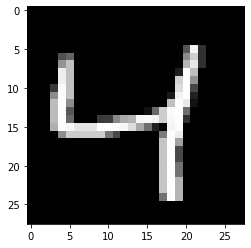

In [15]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

### imags　の数でデータの範囲をチェック
- 0 ～ 1　に正規化されている
- sigmoid　の出力範囲と一致している

In [17]:
print("imgs.shape   = ", imgs.shape)
print("np.max(imgs) = ", np.max(imgs))
print("np.min(imgs) = ", np.min(imgs))

imgs.shape   =  (1, 28, 28, 1)
np.max(imgs) =  1.0
np.min(imgs) =  0.0


## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by a factor of 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

### 入力フォーマット
- 初期値が無い項は、順番が決まっている
- tf.placeholder( dtype, shape=None, name=None )
- tf.layers.conv2d( inputs, filters, kernel_size, strides=(1, 1), padding='valid', activation=None)
- tf.layers.max_pooling2d( inputs, pool_size, strides, padding='valid' )
- padding= same  の時、 out = ceil(float(in) / float(strides))
- padding= valid の時、 out = ceil(float(in - filter + 1) / float(strides))

In [21]:
learning_rate = 0.001
# Input and target placeholders
inputs_  = tf.placeholder(tf.float32, (None, 28,28,1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28,28,1), name='targets')
#----------------------------------------------------------------
### Encoder
#----------------------------------------------------------------
# filter = 16 -> depth=16 になる
# kernel_size=(3,3) & stride=(1,1) & padding='same' -> サイズはそのまま(28x28)
conv1 = tf.layers.conv2d( inputs_, filters=16, kernel_size=(3,3), strides=(1, 1), padding='same', activation=tf.nn.relu )
# Now 28x28x16
#----------------------------------------------------------------
# depth　は　そのまま
# filter=(2,2) & stride=(2,2) -> サイズが半分(14,14)になる
maxpool1 = tf.layers.max_pooling2d( conv1, pool_size=(2,2), strides=(2,2), padding='same' )
# Now 14x14x16
#----------------------------------------------------------------
# filter = 8 -> depth=8になる
# kernel_size=(3,3) & stride=(1,1) & padding='same' -> サイズはそのまま(14x14)
conv2 = tf.layers.conv2d( maxpool1, filters=8, kernel_size=(3,3), strides=(1, 1), padding='same', activation=tf.nn.relu )
# Now 14x14x8
#----------------------------------------------------------------
# depth　は　そのまま
# filter=(2,2) & stride=(2,2) -> サイズが半分(7,7)になる
# validの時の計算式 ： ceil{(14-2+1)/2 + 1} = ceil( 4 ) = 4
maxpool2 = tf.layers.max_pooling2d( conv2, pool_size=(2,2), strides=(2,2), padding='same' )
# Now 7x7x8
#----------------------------------------------------------------
# filter = 8 -> depth=8になる
# kernel_size=(3,3) & stride=(1,1) & padding='same' -> サイズはそのまま(7x7)
conv3 = tf.layers.conv2d( maxpool2, filters=8, kernel_size=(3,3), strides=(1, 1), padding='same', activation=tf.nn.relu )
# Now 7x7x8
#----------------------------------------------------------------
# depth　は　そのまま
# filter=(2,2) & stride=(2,2) -> サイズが半分(7,7)になる
encoded = tf.layers.max_pooling2d( conv3, pool_size=(2,2), strides=(2,2), padding='same' )
# Now 4x4x8
#----------------------------------------------------------------

#----------------------------------------------------------------
### Decoder
#----------------------------------------------------------------
# depth　は　そのまま
# サイズを強制的に(7,7)にする
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x8
#----------------------------------------------------------------
# filter = 8 -> depth=8になる
# kernel_size=(3,3) & stride=(1,1) & padding='same' -> サイズはそのまま(7x7)
conv4 = tf.layers.conv2d( upsample1, filters=8, kernel_size=(3,3), strides=(1, 1), padding='same', activation=tf.nn.relu )
# Now 7x7x8
#----------------------------------------------------------------
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
# Now 14x14x8
#----------------------------------------------------------------
conv5 = tf.layers.conv2d( upsample2, filters=8, kernel_size=(3,3), strides=(1, 1), padding='same', activation=tf.nn.relu )
# Now 14x14x8
#----------------------------------------------------------------
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
# Now 28x28x8
#----------------------------------------------------------------
conv6 = tf.layers.conv2d( upsample3, filters=16, kernel_size=(3,3), strides=(1, 1), padding='same', activation=tf.nn.relu )
# Now 28x28x16
#----------------------------------------------------------------
# 最終層手前：activationは、次で実施
logits = tf.layers.conv2d( conv6, filters=1, kernel_size=(3,3), strides=(1, 1), padding='same', activation=None )
#Now 28x28x1

#----------------------------------------------------------------
# Pass logits through sigmoid to get reconstructed image
# 画像データが、0～1に正規化されている　かつ
# 28x28のそれぞれの位置に 0～1 が配置されて画像が作られているので
# 28x28のデータにsigmoidを適用しても、数値の判別が可能
# 出力がスカラーの時は、この方法では難しい
decoded = tf.nn.sigmoid(logits, name='decoded')
#----------------------------------------------------------------

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
# tf.reduce_mean -> reduce は全ての次元を減らし、デフォルトでは、スカラーにするという意味
cost = tf.reduce_mean(loss)
opt  = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training

As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [27]:
sess = tf.Session()

In [28]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.6872
Epoch: 1/20... Training loss: 0.6829
Epoch: 1/20... Training loss: 0.6773
Epoch: 1/20... Training loss: 0.6705
Epoch: 1/20... Training loss: 0.6622
Epoch: 1/20... Training loss: 0.6513
Epoch: 1/20... Training loss: 0.6398
Epoch: 1/20... Training loss: 0.6250
Epoch: 1/20... Training loss: 0.6094
Epoch: 1/20... Training loss: 0.5905
Epoch: 1/20... Training loss: 0.5729
Epoch: 1/20... Training loss: 0.5484
Epoch: 1/20... Training loss: 0.5363
Epoch: 1/20... Training loss: 0.5247
Epoch: 1/20... Training loss: 0.5252
Epoch: 1/20... Training loss: 0.5228
Epoch: 1/20... Training loss: 0.5271
Epoch: 1/20... Training loss: 0.5324
Epoch: 1/20... Training loss: 0.5175
Epoch: 1/20... Training loss: 0.5140
Epoch: 1/20... Training loss: 0.4955
Epoch: 1/20... Training loss: 0.4881
Epoch: 1/20... Training loss: 0.4751
Epoch: 1/20... Training loss: 0.4748
Epoch: 1/20... Training loss: 0.4727
Epoch: 1/20... Training loss: 0.4482
Epoch: 1/20... Training loss: 0.4564
E

Epoch: 1/20... Training loss: 0.1629
Epoch: 1/20... Training loss: 0.1586
Epoch: 1/20... Training loss: 0.1597
Epoch: 1/20... Training loss: 0.1617
Epoch: 1/20... Training loss: 0.1561
Epoch: 1/20... Training loss: 0.1585
Epoch: 1/20... Training loss: 0.1631
Epoch: 1/20... Training loss: 0.1567
Epoch: 1/20... Training loss: 0.1542
Epoch: 1/20... Training loss: 0.1565
Epoch: 1/20... Training loss: 0.1630
Epoch: 1/20... Training loss: 0.1549
Epoch: 1/20... Training loss: 0.1578
Epoch: 1/20... Training loss: 0.1578
Epoch: 1/20... Training loss: 0.1568
Epoch: 1/20... Training loss: 0.1551
Epoch: 1/20... Training loss: 0.1605
Epoch: 1/20... Training loss: 0.1524
Epoch: 1/20... Training loss: 0.1562
Epoch: 1/20... Training loss: 0.1575
Epoch: 1/20... Training loss: 0.1567
Epoch: 1/20... Training loss: 0.1589
Epoch: 1/20... Training loss: 0.1562
Epoch: 1/20... Training loss: 0.1549
Epoch: 1/20... Training loss: 0.1567
Epoch: 1/20... Training loss: 0.1560
Epoch: 1/20... Training loss: 0.1535
E

Epoch: 2/20... Training loss: 0.1353
Epoch: 2/20... Training loss: 0.1384
Epoch: 2/20... Training loss: 0.1304
Epoch: 2/20... Training loss: 0.1339
Epoch: 2/20... Training loss: 0.1351
Epoch: 2/20... Training loss: 0.1324
Epoch: 2/20... Training loss: 0.1328
Epoch: 2/20... Training loss: 0.1363
Epoch: 2/20... Training loss: 0.1361
Epoch: 2/20... Training loss: 0.1359
Epoch: 2/20... Training loss: 0.1311
Epoch: 2/20... Training loss: 0.1383
Epoch: 2/20... Training loss: 0.1367
Epoch: 2/20... Training loss: 0.1337
Epoch: 2/20... Training loss: 0.1364
Epoch: 2/20... Training loss: 0.1366
Epoch: 2/20... Training loss: 0.1350
Epoch: 2/20... Training loss: 0.1329
Epoch: 2/20... Training loss: 0.1326
Epoch: 2/20... Training loss: 0.1275
Epoch: 2/20... Training loss: 0.1365
Epoch: 2/20... Training loss: 0.1332
Epoch: 2/20... Training loss: 0.1360
Epoch: 2/20... Training loss: 0.1336
Epoch: 2/20... Training loss: 0.1260
Epoch: 2/20... Training loss: 0.1373
Epoch: 2/20... Training loss: 0.1395
E

Epoch: 3/20... Training loss: 0.1238
Epoch: 3/20... Training loss: 0.1305
Epoch: 3/20... Training loss: 0.1284
Epoch: 3/20... Training loss: 0.1228
Epoch: 3/20... Training loss: 0.1263
Epoch: 3/20... Training loss: 0.1280
Epoch: 3/20... Training loss: 0.1243
Epoch: 3/20... Training loss: 0.1251
Epoch: 3/20... Training loss: 0.1252
Epoch: 3/20... Training loss: 0.1271
Epoch: 3/20... Training loss: 0.1241
Epoch: 3/20... Training loss: 0.1242
Epoch: 3/20... Training loss: 0.1285
Epoch: 3/20... Training loss: 0.1257
Epoch: 3/20... Training loss: 0.1252
Epoch: 3/20... Training loss: 0.1254
Epoch: 3/20... Training loss: 0.1289
Epoch: 3/20... Training loss: 0.1269
Epoch: 3/20... Training loss: 0.1196
Epoch: 3/20... Training loss: 0.1235
Epoch: 3/20... Training loss: 0.1253
Epoch: 3/20... Training loss: 0.1225
Epoch: 3/20... Training loss: 0.1241
Epoch: 3/20... Training loss: 0.1293
Epoch: 3/20... Training loss: 0.1308
Epoch: 3/20... Training loss: 0.1236
Epoch: 3/20... Training loss: 0.1238
E

Epoch: 4/20... Training loss: 0.1195
Epoch: 4/20... Training loss: 0.1236
Epoch: 4/20... Training loss: 0.1220
Epoch: 4/20... Training loss: 0.1180
Epoch: 4/20... Training loss: 0.1228
Epoch: 4/20... Training loss: 0.1187
Epoch: 4/20... Training loss: 0.1132
Epoch: 4/20... Training loss: 0.1203
Epoch: 4/20... Training loss: 0.1174
Epoch: 4/20... Training loss: 0.1197
Epoch: 4/20... Training loss: 0.1167
Epoch: 4/20... Training loss: 0.1211
Epoch: 4/20... Training loss: 0.1198
Epoch: 4/20... Training loss: 0.1182
Epoch: 4/20... Training loss: 0.1257
Epoch: 4/20... Training loss: 0.1166
Epoch: 4/20... Training loss: 0.1206
Epoch: 4/20... Training loss: 0.1205
Epoch: 4/20... Training loss: 0.1175
Epoch: 4/20... Training loss: 0.1218
Epoch: 4/20... Training loss: 0.1152
Epoch: 4/20... Training loss: 0.1159
Epoch: 4/20... Training loss: 0.1230
Epoch: 4/20... Training loss: 0.1232
Epoch: 4/20... Training loss: 0.1225
Epoch: 4/20... Training loss: 0.1245
Epoch: 4/20... Training loss: 0.1224
E

Epoch: 4/20... Training loss: 0.1209
Epoch: 4/20... Training loss: 0.1144
Epoch: 4/20... Training loss: 0.1165
Epoch: 4/20... Training loss: 0.1220
Epoch: 4/20... Training loss: 0.1191
Epoch: 4/20... Training loss: 0.1174
Epoch: 4/20... Training loss: 0.1168
Epoch: 4/20... Training loss: 0.1163
Epoch: 4/20... Training loss: 0.1134
Epoch: 4/20... Training loss: 0.1099
Epoch: 4/20... Training loss: 0.1149
Epoch: 4/20... Training loss: 0.1197
Epoch: 4/20... Training loss: 0.1160
Epoch: 4/20... Training loss: 0.1186
Epoch: 4/20... Training loss: 0.1194
Epoch: 5/20... Training loss: 0.1212
Epoch: 5/20... Training loss: 0.1165
Epoch: 5/20... Training loss: 0.1171
Epoch: 5/20... Training loss: 0.1154
Epoch: 5/20... Training loss: 0.1137
Epoch: 5/20... Training loss: 0.1171
Epoch: 5/20... Training loss: 0.1126
Epoch: 5/20... Training loss: 0.1178
Epoch: 5/20... Training loss: 0.1192
Epoch: 5/20... Training loss: 0.1170
Epoch: 5/20... Training loss: 0.1186
Epoch: 5/20... Training loss: 0.1162
E

Epoch: 5/20... Training loss: 0.1146
Epoch: 5/20... Training loss: 0.1224
Epoch: 5/20... Training loss: 0.1201
Epoch: 5/20... Training loss: 0.1119
Epoch: 5/20... Training loss: 0.1164
Epoch: 5/20... Training loss: 0.1154
Epoch: 5/20... Training loss: 0.1120
Epoch: 5/20... Training loss: 0.1127
Epoch: 5/20... Training loss: 0.1086
Epoch: 5/20... Training loss: 0.1147
Epoch: 5/20... Training loss: 0.1148
Epoch: 5/20... Training loss: 0.1139
Epoch: 5/20... Training loss: 0.1152
Epoch: 5/20... Training loss: 0.1161
Epoch: 5/20... Training loss: 0.1106
Epoch: 5/20... Training loss: 0.1208
Epoch: 5/20... Training loss: 0.1148
Epoch: 5/20... Training loss: 0.1123
Epoch: 5/20... Training loss: 0.1097
Epoch: 5/20... Training loss: 0.1172
Epoch: 5/20... Training loss: 0.1187
Epoch: 5/20... Training loss: 0.1081
Epoch: 5/20... Training loss: 0.1165
Epoch: 5/20... Training loss: 0.1153
Epoch: 5/20... Training loss: 0.1137
Epoch: 5/20... Training loss: 0.1110
Epoch: 5/20... Training loss: 0.1162
E

Epoch: 6/20... Training loss: 0.1101
Epoch: 6/20... Training loss: 0.1141
Epoch: 6/20... Training loss: 0.1063
Epoch: 6/20... Training loss: 0.1141
Epoch: 6/20... Training loss: 0.1169
Epoch: 6/20... Training loss: 0.1103
Epoch: 6/20... Training loss: 0.1101
Epoch: 6/20... Training loss: 0.1120
Epoch: 6/20... Training loss: 0.1112
Epoch: 6/20... Training loss: 0.1120
Epoch: 6/20... Training loss: 0.1150
Epoch: 6/20... Training loss: 0.1109
Epoch: 6/20... Training loss: 0.1147
Epoch: 6/20... Training loss: 0.1090
Epoch: 6/20... Training loss: 0.1124
Epoch: 6/20... Training loss: 0.1060
Epoch: 6/20... Training loss: 0.1109
Epoch: 6/20... Training loss: 0.1077
Epoch: 6/20... Training loss: 0.1092
Epoch: 6/20... Training loss: 0.1114
Epoch: 6/20... Training loss: 0.1141
Epoch: 6/20... Training loss: 0.1128
Epoch: 6/20... Training loss: 0.1139
Epoch: 6/20... Training loss: 0.1115
Epoch: 6/20... Training loss: 0.1093
Epoch: 6/20... Training loss: 0.1133
Epoch: 6/20... Training loss: 0.1141
E

Epoch: 7/20... Training loss: 0.1129
Epoch: 7/20... Training loss: 0.1122
Epoch: 7/20... Training loss: 0.1128
Epoch: 7/20... Training loss: 0.1089
Epoch: 7/20... Training loss: 0.1079
Epoch: 7/20... Training loss: 0.1106
Epoch: 7/20... Training loss: 0.1151
Epoch: 7/20... Training loss: 0.1107
Epoch: 7/20... Training loss: 0.1090
Epoch: 7/20... Training loss: 0.1115
Epoch: 7/20... Training loss: 0.1148
Epoch: 7/20... Training loss: 0.1101
Epoch: 7/20... Training loss: 0.1115
Epoch: 7/20... Training loss: 0.1141
Epoch: 7/20... Training loss: 0.1084
Epoch: 7/20... Training loss: 0.1143
Epoch: 7/20... Training loss: 0.1086
Epoch: 7/20... Training loss: 0.1107
Epoch: 7/20... Training loss: 0.1089
Epoch: 7/20... Training loss: 0.1111
Epoch: 7/20... Training loss: 0.1107
Epoch: 7/20... Training loss: 0.1110
Epoch: 7/20... Training loss: 0.1078
Epoch: 7/20... Training loss: 0.1148
Epoch: 7/20... Training loss: 0.1085
Epoch: 7/20... Training loss: 0.1037
Epoch: 7/20... Training loss: 0.1066
E

Epoch: 8/20... Training loss: 0.1062
Epoch: 8/20... Training loss: 0.1154
Epoch: 8/20... Training loss: 0.1145
Epoch: 8/20... Training loss: 0.1113
Epoch: 8/20... Training loss: 0.1104
Epoch: 8/20... Training loss: 0.1097
Epoch: 8/20... Training loss: 0.1111
Epoch: 8/20... Training loss: 0.1081
Epoch: 8/20... Training loss: 0.1116
Epoch: 8/20... Training loss: 0.1113
Epoch: 8/20... Training loss: 0.1091
Epoch: 8/20... Training loss: 0.1122
Epoch: 8/20... Training loss: 0.1067
Epoch: 8/20... Training loss: 0.1096
Epoch: 8/20... Training loss: 0.1114
Epoch: 8/20... Training loss: 0.1083
Epoch: 8/20... Training loss: 0.1088
Epoch: 8/20... Training loss: 0.1085
Epoch: 8/20... Training loss: 0.1110
Epoch: 8/20... Training loss: 0.1127
Epoch: 8/20... Training loss: 0.1070
Epoch: 8/20... Training loss: 0.1140
Epoch: 8/20... Training loss: 0.1091
Epoch: 8/20... Training loss: 0.1091
Epoch: 8/20... Training loss: 0.1017
Epoch: 8/20... Training loss: 0.1086
Epoch: 8/20... Training loss: 0.1089
E

Epoch: 8/20... Training loss: 0.1046
Epoch: 8/20... Training loss: 0.1076
Epoch: 8/20... Training loss: 0.1030
Epoch: 8/20... Training loss: 0.1130
Epoch: 8/20... Training loss: 0.1071
Epoch: 8/20... Training loss: 0.1068
Epoch: 8/20... Training loss: 0.1076
Epoch: 8/20... Training loss: 0.1082
Epoch: 8/20... Training loss: 0.1060
Epoch: 8/20... Training loss: 0.1090
Epoch: 8/20... Training loss: 0.1061
Epoch: 8/20... Training loss: 0.1059
Epoch: 8/20... Training loss: 0.1050
Epoch: 8/20... Training loss: 0.1119
Epoch: 8/20... Training loss: 0.1045
Epoch: 8/20... Training loss: 0.1073
Epoch: 8/20... Training loss: 0.1096
Epoch: 8/20... Training loss: 0.1110
Epoch: 8/20... Training loss: 0.1080
Epoch: 8/20... Training loss: 0.1071
Epoch: 8/20... Training loss: 0.1019
Epoch: 8/20... Training loss: 0.1051
Epoch: 8/20... Training loss: 0.1094
Epoch: 8/20... Training loss: 0.1122
Epoch: 8/20... Training loss: 0.1087
Epoch: 8/20... Training loss: 0.1059
Epoch: 8/20... Training loss: 0.1068
E

Epoch: 9/20... Training loss: 0.1078
Epoch: 9/20... Training loss: 0.1040
Epoch: 9/20... Training loss: 0.1056
Epoch: 9/20... Training loss: 0.1057
Epoch: 9/20... Training loss: 0.1072
Epoch: 9/20... Training loss: 0.1070
Epoch: 9/20... Training loss: 0.1053
Epoch: 9/20... Training loss: 0.1087
Epoch: 9/20... Training loss: 0.1058
Epoch: 9/20... Training loss: 0.1122
Epoch: 9/20... Training loss: 0.1061
Epoch: 9/20... Training loss: 0.1061
Epoch: 9/20... Training loss: 0.1102
Epoch: 9/20... Training loss: 0.1061
Epoch: 9/20... Training loss: 0.1081
Epoch: 9/20... Training loss: 0.1107
Epoch: 9/20... Training loss: 0.1060
Epoch: 9/20... Training loss: 0.1044
Epoch: 9/20... Training loss: 0.1087
Epoch: 9/20... Training loss: 0.1085
Epoch: 9/20... Training loss: 0.1052
Epoch: 9/20... Training loss: 0.1085
Epoch: 9/20... Training loss: 0.1072
Epoch: 9/20... Training loss: 0.1062
Epoch: 9/20... Training loss: 0.1129
Epoch: 9/20... Training loss: 0.1125
Epoch: 9/20... Training loss: 0.1075
E

Epoch: 10/20... Training loss: 0.1058
Epoch: 10/20... Training loss: 0.1073
Epoch: 10/20... Training loss: 0.1123
Epoch: 10/20... Training loss: 0.1068
Epoch: 10/20... Training loss: 0.1096
Epoch: 10/20... Training loss: 0.1083
Epoch: 10/20... Training loss: 0.1042
Epoch: 10/20... Training loss: 0.1069
Epoch: 10/20... Training loss: 0.1060
Epoch: 10/20... Training loss: 0.1050
Epoch: 10/20... Training loss: 0.1053
Epoch: 10/20... Training loss: 0.1076
Epoch: 10/20... Training loss: 0.1055
Epoch: 10/20... Training loss: 0.1062
Epoch: 10/20... Training loss: 0.1058
Epoch: 10/20... Training loss: 0.1050
Epoch: 10/20... Training loss: 0.1059
Epoch: 10/20... Training loss: 0.1047
Epoch: 10/20... Training loss: 0.1017
Epoch: 10/20... Training loss: 0.1100
Epoch: 10/20... Training loss: 0.1051
Epoch: 10/20... Training loss: 0.1104
Epoch: 10/20... Training loss: 0.1053
Epoch: 10/20... Training loss: 0.1071
Epoch: 10/20... Training loss: 0.1075
Epoch: 10/20... Training loss: 0.1056
Epoch: 10/20

Epoch: 11/20... Training loss: 0.1059
Epoch: 11/20... Training loss: 0.1076
Epoch: 11/20... Training loss: 0.1102
Epoch: 11/20... Training loss: 0.1069
Epoch: 11/20... Training loss: 0.1020
Epoch: 11/20... Training loss: 0.1081
Epoch: 11/20... Training loss: 0.1068
Epoch: 11/20... Training loss: 0.1064
Epoch: 11/20... Training loss: 0.1080
Epoch: 11/20... Training loss: 0.1065
Epoch: 11/20... Training loss: 0.1061
Epoch: 11/20... Training loss: 0.1041
Epoch: 11/20... Training loss: 0.1091
Epoch: 11/20... Training loss: 0.1034
Epoch: 11/20... Training loss: 0.1035
Epoch: 11/20... Training loss: 0.1053
Epoch: 11/20... Training loss: 0.1049
Epoch: 11/20... Training loss: 0.1071
Epoch: 11/20... Training loss: 0.1026
Epoch: 11/20... Training loss: 0.1059
Epoch: 11/20... Training loss: 0.1070
Epoch: 11/20... Training loss: 0.1068
Epoch: 11/20... Training loss: 0.1052
Epoch: 11/20... Training loss: 0.1054
Epoch: 11/20... Training loss: 0.1035
Epoch: 11/20... Training loss: 0.1039
Epoch: 11/20

Epoch: 12/20... Training loss: 0.1042
Epoch: 12/20... Training loss: 0.1028
Epoch: 12/20... Training loss: 0.1046
Epoch: 12/20... Training loss: 0.1043
Epoch: 12/20... Training loss: 0.1058
Epoch: 12/20... Training loss: 0.1014
Epoch: 12/20... Training loss: 0.1086
Epoch: 12/20... Training loss: 0.1085
Epoch: 12/20... Training loss: 0.1075
Epoch: 12/20... Training loss: 0.1065
Epoch: 12/20... Training loss: 0.1082
Epoch: 12/20... Training loss: 0.1031
Epoch: 12/20... Training loss: 0.1047
Epoch: 12/20... Training loss: 0.1049
Epoch: 12/20... Training loss: 0.1035
Epoch: 12/20... Training loss: 0.1059
Epoch: 12/20... Training loss: 0.1069
Epoch: 12/20... Training loss: 0.1053
Epoch: 12/20... Training loss: 0.1061
Epoch: 12/20... Training loss: 0.1061
Epoch: 12/20... Training loss: 0.1053
Epoch: 12/20... Training loss: 0.1042
Epoch: 12/20... Training loss: 0.1045
Epoch: 12/20... Training loss: 0.1101
Epoch: 12/20... Training loss: 0.1027
Epoch: 12/20... Training loss: 0.1062
Epoch: 12/20

Epoch: 12/20... Training loss: 0.1069
Epoch: 12/20... Training loss: 0.1042
Epoch: 12/20... Training loss: 0.1039
Epoch: 12/20... Training loss: 0.1066
Epoch: 12/20... Training loss: 0.1069
Epoch: 12/20... Training loss: 0.1002
Epoch: 12/20... Training loss: 0.1069
Epoch: 12/20... Training loss: 0.1051
Epoch: 12/20... Training loss: 0.1045
Epoch: 12/20... Training loss: 0.1038
Epoch: 12/20... Training loss: 0.1000
Epoch: 12/20... Training loss: 0.1042
Epoch: 12/20... Training loss: 0.1036
Epoch: 12/20... Training loss: 0.1047
Epoch: 12/20... Training loss: 0.1029
Epoch: 12/20... Training loss: 0.1001
Epoch: 12/20... Training loss: 0.1055
Epoch: 12/20... Training loss: 0.1029
Epoch: 12/20... Training loss: 0.1039
Epoch: 12/20... Training loss: 0.1046
Epoch: 12/20... Training loss: 0.1018
Epoch: 12/20... Training loss: 0.1036
Epoch: 12/20... Training loss: 0.1050
Epoch: 12/20... Training loss: 0.1067
Epoch: 12/20... Training loss: 0.1040
Epoch: 12/20... Training loss: 0.1040
Epoch: 12/20

Epoch: 13/20... Training loss: 0.1038
Epoch: 13/20... Training loss: 0.1078
Epoch: 13/20... Training loss: 0.0982
Epoch: 13/20... Training loss: 0.1036
Epoch: 13/20... Training loss: 0.1008
Epoch: 13/20... Training loss: 0.1099
Epoch: 13/20... Training loss: 0.1001
Epoch: 13/20... Training loss: 0.1045
Epoch: 13/20... Training loss: 0.1055
Epoch: 13/20... Training loss: 0.1045
Epoch: 13/20... Training loss: 0.1053
Epoch: 13/20... Training loss: 0.1028
Epoch: 13/20... Training loss: 0.1088
Epoch: 13/20... Training loss: 0.1021
Epoch: 13/20... Training loss: 0.1036
Epoch: 13/20... Training loss: 0.1038
Epoch: 13/20... Training loss: 0.1094
Epoch: 13/20... Training loss: 0.1067
Epoch: 13/20... Training loss: 0.1054
Epoch: 13/20... Training loss: 0.1038
Epoch: 13/20... Training loss: 0.1028
Epoch: 13/20... Training loss: 0.1065
Epoch: 13/20... Training loss: 0.1034
Epoch: 13/20... Training loss: 0.1015
Epoch: 13/20... Training loss: 0.1082
Epoch: 13/20... Training loss: 0.1057
Epoch: 13/20

Epoch: 14/20... Training loss: 0.1072
Epoch: 14/20... Training loss: 0.1046
Epoch: 14/20... Training loss: 0.1040
Epoch: 14/20... Training loss: 0.1065
Epoch: 14/20... Training loss: 0.1057
Epoch: 14/20... Training loss: 0.1035
Epoch: 14/20... Training loss: 0.1030
Epoch: 14/20... Training loss: 0.1023
Epoch: 14/20... Training loss: 0.1044
Epoch: 14/20... Training loss: 0.1013
Epoch: 14/20... Training loss: 0.1020
Epoch: 14/20... Training loss: 0.1040
Epoch: 14/20... Training loss: 0.1053
Epoch: 14/20... Training loss: 0.1029
Epoch: 14/20... Training loss: 0.1021
Epoch: 14/20... Training loss: 0.1065
Epoch: 14/20... Training loss: 0.1064
Epoch: 14/20... Training loss: 0.1045
Epoch: 14/20... Training loss: 0.1031
Epoch: 14/20... Training loss: 0.1030
Epoch: 14/20... Training loss: 0.1038
Epoch: 14/20... Training loss: 0.1047
Epoch: 14/20... Training loss: 0.1060
Epoch: 14/20... Training loss: 0.1027
Epoch: 14/20... Training loss: 0.0980
Epoch: 14/20... Training loss: 0.1020
Epoch: 14/20

Epoch: 15/20... Training loss: 0.1008
Epoch: 15/20... Training loss: 0.1001
Epoch: 15/20... Training loss: 0.0993
Epoch: 15/20... Training loss: 0.1048
Epoch: 15/20... Training loss: 0.1046
Epoch: 15/20... Training loss: 0.1008
Epoch: 15/20... Training loss: 0.1069
Epoch: 15/20... Training loss: 0.1030
Epoch: 15/20... Training loss: 0.1017
Epoch: 15/20... Training loss: 0.1021
Epoch: 15/20... Training loss: 0.1018
Epoch: 15/20... Training loss: 0.1011
Epoch: 15/20... Training loss: 0.1032
Epoch: 15/20... Training loss: 0.1065
Epoch: 15/20... Training loss: 0.1064
Epoch: 15/20... Training loss: 0.1013
Epoch: 15/20... Training loss: 0.1050
Epoch: 15/20... Training loss: 0.0986
Epoch: 15/20... Training loss: 0.1015
Epoch: 15/20... Training loss: 0.1093
Epoch: 15/20... Training loss: 0.1046
Epoch: 15/20... Training loss: 0.1035
Epoch: 15/20... Training loss: 0.1026
Epoch: 15/20... Training loss: 0.1053
Epoch: 15/20... Training loss: 0.1059
Epoch: 15/20... Training loss: 0.1037
Epoch: 15/20

Epoch: 15/20... Training loss: 0.1029
Epoch: 15/20... Training loss: 0.1036
Epoch: 15/20... Training loss: 0.1019
Epoch: 15/20... Training loss: 0.1038
Epoch: 15/20... Training loss: 0.1021
Epoch: 15/20... Training loss: 0.0978
Epoch: 15/20... Training loss: 0.1003
Epoch: 15/20... Training loss: 0.1003
Epoch: 15/20... Training loss: 0.1025
Epoch: 15/20... Training loss: 0.1026
Epoch: 15/20... Training loss: 0.1031
Epoch: 15/20... Training loss: 0.1005
Epoch: 15/20... Training loss: 0.1078
Epoch: 15/20... Training loss: 0.1041
Epoch: 15/20... Training loss: 0.1040
Epoch: 15/20... Training loss: 0.1014
Epoch: 15/20... Training loss: 0.1006
Epoch: 15/20... Training loss: 0.1046
Epoch: 15/20... Training loss: 0.1059
Epoch: 15/20... Training loss: 0.0996
Epoch: 15/20... Training loss: 0.1024
Epoch: 15/20... Training loss: 0.1010
Epoch: 15/20... Training loss: 0.1070
Epoch: 15/20... Training loss: 0.1055
Epoch: 15/20... Training loss: 0.1032
Epoch: 15/20... Training loss: 0.1026
Epoch: 15/20

Epoch: 16/20... Training loss: 0.1055
Epoch: 16/20... Training loss: 0.1016
Epoch: 16/20... Training loss: 0.1029
Epoch: 16/20... Training loss: 0.1058
Epoch: 16/20... Training loss: 0.1040
Epoch: 16/20... Training loss: 0.1044
Epoch: 16/20... Training loss: 0.1036
Epoch: 16/20... Training loss: 0.1008
Epoch: 16/20... Training loss: 0.1049
Epoch: 16/20... Training loss: 0.1044
Epoch: 16/20... Training loss: 0.1038
Epoch: 16/20... Training loss: 0.1040
Epoch: 16/20... Training loss: 0.0992
Epoch: 16/20... Training loss: 0.1028
Epoch: 16/20... Training loss: 0.1044
Epoch: 16/20... Training loss: 0.0986
Epoch: 16/20... Training loss: 0.1055
Epoch: 16/20... Training loss: 0.1021
Epoch: 16/20... Training loss: 0.1030
Epoch: 16/20... Training loss: 0.1015
Epoch: 16/20... Training loss: 0.1028
Epoch: 16/20... Training loss: 0.1043
Epoch: 16/20... Training loss: 0.0993
Epoch: 16/20... Training loss: 0.1009
Epoch: 16/20... Training loss: 0.0986
Epoch: 16/20... Training loss: 0.1040
Epoch: 16/20

Epoch: 17/20... Training loss: 0.1003
Epoch: 17/20... Training loss: 0.0998
Epoch: 17/20... Training loss: 0.1055
Epoch: 17/20... Training loss: 0.1017
Epoch: 17/20... Training loss: 0.1019
Epoch: 17/20... Training loss: 0.1026
Epoch: 17/20... Training loss: 0.0994
Epoch: 17/20... Training loss: 0.0971
Epoch: 17/20... Training loss: 0.1055
Epoch: 17/20... Training loss: 0.1015
Epoch: 17/20... Training loss: 0.1048
Epoch: 17/20... Training loss: 0.1044
Epoch: 17/20... Training loss: 0.1013
Epoch: 17/20... Training loss: 0.1015
Epoch: 17/20... Training loss: 0.1014
Epoch: 17/20... Training loss: 0.1040
Epoch: 17/20... Training loss: 0.1027
Epoch: 17/20... Training loss: 0.0990
Epoch: 17/20... Training loss: 0.0973
Epoch: 17/20... Training loss: 0.1011
Epoch: 17/20... Training loss: 0.1024
Epoch: 17/20... Training loss: 0.1055
Epoch: 17/20... Training loss: 0.1017
Epoch: 17/20... Training loss: 0.0989
Epoch: 17/20... Training loss: 0.1034
Epoch: 17/20... Training loss: 0.0973
Epoch: 17/20

Epoch: 18/20... Training loss: 0.1006
Epoch: 18/20... Training loss: 0.1053
Epoch: 18/20... Training loss: 0.0986
Epoch: 18/20... Training loss: 0.0984
Epoch: 18/20... Training loss: 0.1029
Epoch: 18/20... Training loss: 0.1034
Epoch: 18/20... Training loss: 0.1041
Epoch: 18/20... Training loss: 0.1031
Epoch: 18/20... Training loss: 0.1032
Epoch: 18/20... Training loss: 0.1008
Epoch: 18/20... Training loss: 0.0998
Epoch: 18/20... Training loss: 0.1006
Epoch: 18/20... Training loss: 0.0996
Epoch: 18/20... Training loss: 0.1038
Epoch: 18/20... Training loss: 0.1006
Epoch: 18/20... Training loss: 0.0977
Epoch: 18/20... Training loss: 0.0986
Epoch: 18/20... Training loss: 0.1007
Epoch: 18/20... Training loss: 0.0998
Epoch: 18/20... Training loss: 0.1036
Epoch: 18/20... Training loss: 0.0977
Epoch: 18/20... Training loss: 0.0984
Epoch: 18/20... Training loss: 0.1006
Epoch: 18/20... Training loss: 0.1074
Epoch: 18/20... Training loss: 0.1056
Epoch: 18/20... Training loss: 0.1003
Epoch: 18/20

Epoch: 18/20... Training loss: 0.1029
Epoch: 18/20... Training loss: 0.1013
Epoch: 18/20... Training loss: 0.0992
Epoch: 18/20... Training loss: 0.0947
Epoch: 18/20... Training loss: 0.0997
Epoch: 18/20... Training loss: 0.1027
Epoch: 18/20... Training loss: 0.1028
Epoch: 18/20... Training loss: 0.0991
Epoch: 18/20... Training loss: 0.0991
Epoch: 18/20... Training loss: 0.1000
Epoch: 18/20... Training loss: 0.1028
Epoch: 18/20... Training loss: 0.1004
Epoch: 18/20... Training loss: 0.1004
Epoch: 18/20... Training loss: 0.1046
Epoch: 18/20... Training loss: 0.1008
Epoch: 18/20... Training loss: 0.0979
Epoch: 18/20... Training loss: 0.1010
Epoch: 18/20... Training loss: 0.0977
Epoch: 18/20... Training loss: 0.1019
Epoch: 18/20... Training loss: 0.1012
Epoch: 18/20... Training loss: 0.1036
Epoch: 18/20... Training loss: 0.1019
Epoch: 18/20... Training loss: 0.1004
Epoch: 18/20... Training loss: 0.0998
Epoch: 18/20... Training loss: 0.0984
Epoch: 18/20... Training loss: 0.1028
Epoch: 18/20

Epoch: 19/20... Training loss: 0.0986
Epoch: 19/20... Training loss: 0.1010
Epoch: 19/20... Training loss: 0.1020
Epoch: 19/20... Training loss: 0.0996
Epoch: 19/20... Training loss: 0.1045
Epoch: 19/20... Training loss: 0.0984
Epoch: 19/20... Training loss: 0.0995
Epoch: 19/20... Training loss: 0.1006
Epoch: 19/20... Training loss: 0.1050
Epoch: 19/20... Training loss: 0.1045
Epoch: 19/20... Training loss: 0.1026
Epoch: 19/20... Training loss: 0.0998
Epoch: 19/20... Training loss: 0.0989
Epoch: 19/20... Training loss: 0.1001
Epoch: 19/20... Training loss: 0.0989
Epoch: 19/20... Training loss: 0.1006
Epoch: 19/20... Training loss: 0.1053
Epoch: 19/20... Training loss: 0.1010
Epoch: 19/20... Training loss: 0.1024
Epoch: 19/20... Training loss: 0.0985
Epoch: 19/20... Training loss: 0.1016
Epoch: 19/20... Training loss: 0.1016
Epoch: 19/20... Training loss: 0.0985
Epoch: 19/20... Training loss: 0.1001
Epoch: 19/20... Training loss: 0.1012
Epoch: 19/20... Training loss: 0.1005
Epoch: 19/20

Epoch: 20/20... Training loss: 0.0992
Epoch: 20/20... Training loss: 0.0980
Epoch: 20/20... Training loss: 0.0993
Epoch: 20/20... Training loss: 0.1004
Epoch: 20/20... Training loss: 0.1000
Epoch: 20/20... Training loss: 0.1007
Epoch: 20/20... Training loss: 0.0990
Epoch: 20/20... Training loss: 0.1000
Epoch: 20/20... Training loss: 0.0991
Epoch: 20/20... Training loss: 0.1028
Epoch: 20/20... Training loss: 0.1005
Epoch: 20/20... Training loss: 0.1031
Epoch: 20/20... Training loss: 0.0962
Epoch: 20/20... Training loss: 0.1026
Epoch: 20/20... Training loss: 0.0987
Epoch: 20/20... Training loss: 0.0976
Epoch: 20/20... Training loss: 0.1041
Epoch: 20/20... Training loss: 0.1000
Epoch: 20/20... Training loss: 0.0992
Epoch: 20/20... Training loss: 0.1039
Epoch: 20/20... Training loss: 0.1017
Epoch: 20/20... Training loss: 0.0992
Epoch: 20/20... Training loss: 0.1027
Epoch: 20/20... Training loss: 0.1000
Epoch: 20/20... Training loss: 0.0979
Epoch: 20/20... Training loss: 0.0975
Epoch: 20/20

in_imgs.shape       =  (10, 784)
reconstructed.shape =  (10, 28, 28, 1)


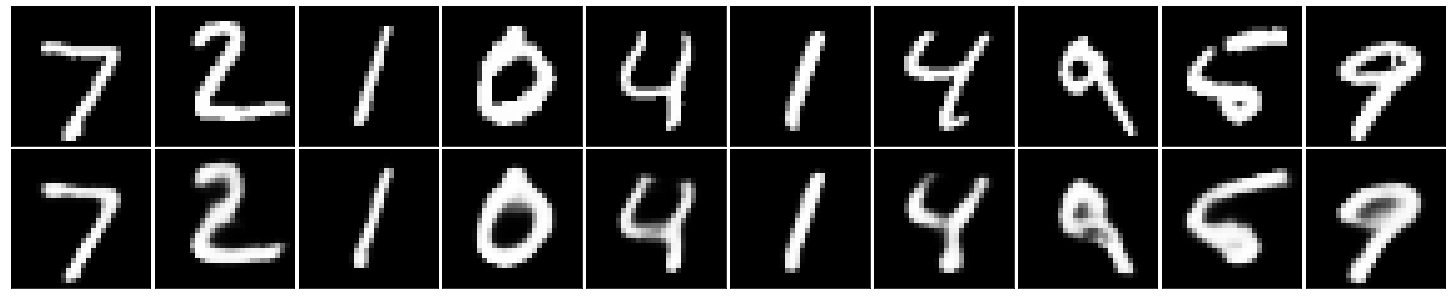

In [39]:
# 2行 10列　の　サブプロット
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))

# 最初の10個のテスト・データを用意
in_imgs = mnist.test.images[:10]
print("in_imgs.shape       = ", in_imgs.shape)

# バッチ数=10　として、テスト・データで予測する
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})
print("reconstructed.shape = ", reconstructed.shape)

# zip([in_imgs, reconstructed]　の意味
# list[0] -> 真値のデータ -> 1行目　に描画したい
# list[1] -> 予測結果     -> 2行目　に描画したい
# reshape　しているのは、テストデータが、(784,)だから
for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

In [40]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [42]:
learning_rate = 0.001
inputs_  = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1    = tf.layers.conv2d( inputs_, filters=32, kernel_size=(3,3), strides=(1,1), padding='same', activation=tf.nn.relu )
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d( conv1, pool_size=(2,2), strides=(2,2), padding='same')
# Now 14x14x32
conv2    = tf.layers.conv2d( maxpool1, filters=32, kernel_size=(3,3), strides=(1,1), padding='same', activation=tf.nn.relu) 
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2, pool_size=(2,2), strides=(2,2), padding='same') 
# Now 7x7x32
conv3    = tf.layers.conv2d(maxpool2, filters=16, kernel_size=(3,3), strides=(1,1), padding='same', activation=tf.nn.relu) 
# Now 7x7x16
encoded = tf.layers.max_pooling2d(conv3, pool_size=(2,2), strides=(2,2), padding='same')
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7) )
# Now 7x7x16
conv4     = tf.layers.conv2d(upsample1, filters=16, kernel_size=(3,3), strides=(1,1), padding='same', activation=tf.nn.relu) 
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
# Now 14x14x16
conv5     = tf.layers.conv2d(upsample2, filters=32, kernel_size=(3,3),strides=(1,1), padding='same', activation=tf.nn.relu) 
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
# Now 28x28x32
conv6     = tf.layers.conv2d(upsample3, filters=32, kernel_size=(3,3), strides=(1,1), padding='same', activation=tf.nn.relu) 
# Now 28x28x32
logits    = tf.layers.conv2d(conv6, filters=1, kernel_size=(3,3), strides=(1,1), padding='same', activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded   = tf.nn.sigmoid(logits, name='decoded')

# Pass logits through sigmoid and calculate the cross-entropy loss
loss      = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_,  logits=logits) 

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [43]:
sess = tf.Session()

In [44]:
epochs = 100
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/100... Training loss: 0.6851
Epoch: 1/100... Training loss: 0.6524
Epoch: 1/100... Training loss: 0.6125
Epoch: 1/100... Training loss: 0.5638
Epoch: 1/100... Training loss: 0.5103
Epoch: 1/100... Training loss: 0.4972
Epoch: 1/100... Training loss: 0.5233
Epoch: 1/100... Training loss: 0.5272
Epoch: 1/100... Training loss: 0.5025
Epoch: 1/100... Training loss: 0.4633
Epoch: 1/100... Training loss: 0.4572
Epoch: 1/100... Training loss: 0.4581
Epoch: 1/100... Training loss: 0.4514
Epoch: 1/100... Training loss: 0.4440
Epoch: 1/100... Training loss: 0.4293
Epoch: 1/100... Training loss: 0.4321
Epoch: 1/100... Training loss: 0.4188
Epoch: 1/100... Training loss: 0.3989
Epoch: 1/100... Training loss: 0.3857
Epoch: 1/100... Training loss: 0.3832
Epoch: 1/100... Training loss: 0.3536
Epoch: 1/100... Training loss: 0.3481
Epoch: 1/100... Training loss: 0.3277
Epoch: 1/100... Training loss: 0.3121
Epoch: 1/100... Training loss: 0.3014
Epoch: 1/100... Training loss: 0.2870
Epoch: 1/100

Epoch: 1/100... Training loss: 0.1779
Epoch: 1/100... Training loss: 0.1690
Epoch: 1/100... Training loss: 0.1745
Epoch: 1/100... Training loss: 0.1674
Epoch: 1/100... Training loss: 0.1753
Epoch: 1/100... Training loss: 0.1710
Epoch: 1/100... Training loss: 0.1649
Epoch: 1/100... Training loss: 0.1774
Epoch: 1/100... Training loss: 0.1679
Epoch: 1/100... Training loss: 0.1619
Epoch: 1/100... Training loss: 0.1677
Epoch: 1/100... Training loss: 0.1755
Epoch: 1/100... Training loss: 0.1698
Epoch: 1/100... Training loss: 0.1674
Epoch: 1/100... Training loss: 0.1720
Epoch: 1/100... Training loss: 0.1708
Epoch: 1/100... Training loss: 0.1711
Epoch: 1/100... Training loss: 0.1694
Epoch: 1/100... Training loss: 0.1690
Epoch: 1/100... Training loss: 0.1691
Epoch: 1/100... Training loss: 0.1727
Epoch: 1/100... Training loss: 0.1664
Epoch: 1/100... Training loss: 0.1686
Epoch: 1/100... Training loss: 0.1676
Epoch: 1/100... Training loss: 0.1672
Epoch: 1/100... Training loss: 0.1644
Epoch: 1/100

Epoch: 2/100... Training loss: 0.1460
Epoch: 2/100... Training loss: 0.1488
Epoch: 2/100... Training loss: 0.1419
Epoch: 2/100... Training loss: 0.1523
Epoch: 2/100... Training loss: 0.1494
Epoch: 2/100... Training loss: 0.1507
Epoch: 2/100... Training loss: 0.1536
Epoch: 2/100... Training loss: 0.1513
Epoch: 2/100... Training loss: 0.1483
Epoch: 2/100... Training loss: 0.1481
Epoch: 2/100... Training loss: 0.1466
Epoch: 2/100... Training loss: 0.1437
Epoch: 2/100... Training loss: 0.1528
Epoch: 2/100... Training loss: 0.1494
Epoch: 2/100... Training loss: 0.1475
Epoch: 2/100... Training loss: 0.1475
Epoch: 2/100... Training loss: 0.1506
Epoch: 2/100... Training loss: 0.1457
Epoch: 2/100... Training loss: 0.1480
Epoch: 2/100... Training loss: 0.1550
Epoch: 2/100... Training loss: 0.1481
Epoch: 2/100... Training loss: 0.1512
Epoch: 2/100... Training loss: 0.1495
Epoch: 2/100... Training loss: 0.1505
Epoch: 2/100... Training loss: 0.1518
Epoch: 2/100... Training loss: 0.1480
Epoch: 2/100

Epoch: 3/100... Training loss: 0.1412
Epoch: 3/100... Training loss: 0.1378
Epoch: 3/100... Training loss: 0.1381
Epoch: 3/100... Training loss: 0.1410
Epoch: 3/100... Training loss: 0.1346
Epoch: 3/100... Training loss: 0.1369
Epoch: 3/100... Training loss: 0.1406
Epoch: 3/100... Training loss: 0.1403
Epoch: 3/100... Training loss: 0.1436
Epoch: 3/100... Training loss: 0.1409
Epoch: 3/100... Training loss: 0.1431
Epoch: 3/100... Training loss: 0.1374
Epoch: 3/100... Training loss: 0.1410
Epoch: 3/100... Training loss: 0.1402
Epoch: 3/100... Training loss: 0.1358
Epoch: 3/100... Training loss: 0.1364
Epoch: 3/100... Training loss: 0.1413
Epoch: 3/100... Training loss: 0.1343
Epoch: 3/100... Training loss: 0.1373
Epoch: 3/100... Training loss: 0.1392
Epoch: 3/100... Training loss: 0.1377
Epoch: 3/100... Training loss: 0.1413
Epoch: 3/100... Training loss: 0.1371
Epoch: 3/100... Training loss: 0.1379
Epoch: 3/100... Training loss: 0.1413
Epoch: 3/100... Training loss: 0.1438
Epoch: 3/100

Epoch: 3/100... Training loss: 0.1246
Epoch: 3/100... Training loss: 0.1298
Epoch: 3/100... Training loss: 0.1306
Epoch: 3/100... Training loss: 0.1294
Epoch: 3/100... Training loss: 0.1330
Epoch: 3/100... Training loss: 0.1328
Epoch: 3/100... Training loss: 0.1294
Epoch: 3/100... Training loss: 0.1335
Epoch: 3/100... Training loss: 0.1294
Epoch: 3/100... Training loss: 0.1303
Epoch: 3/100... Training loss: 0.1331
Epoch: 3/100... Training loss: 0.1251
Epoch: 3/100... Training loss: 0.1309
Epoch: 3/100... Training loss: 0.1325
Epoch: 3/100... Training loss: 0.1324
Epoch: 3/100... Training loss: 0.1326
Epoch: 3/100... Training loss: 0.1326
Epoch: 3/100... Training loss: 0.1293
Epoch: 3/100... Training loss: 0.1307
Epoch: 3/100... Training loss: 0.1295
Epoch: 4/100... Training loss: 0.1325
Epoch: 4/100... Training loss: 0.1313
Epoch: 4/100... Training loss: 0.1334
Epoch: 4/100... Training loss: 0.1326
Epoch: 4/100... Training loss: 0.1310
Epoch: 4/100... Training loss: 0.1306
Epoch: 4/100

Epoch: 4/100... Training loss: 0.1216
Epoch: 4/100... Training loss: 0.1281
Epoch: 4/100... Training loss: 0.1306
Epoch: 4/100... Training loss: 0.1329
Epoch: 4/100... Training loss: 0.1289
Epoch: 4/100... Training loss: 0.1224
Epoch: 4/100... Training loss: 0.1274
Epoch: 4/100... Training loss: 0.1262
Epoch: 4/100... Training loss: 0.1295
Epoch: 4/100... Training loss: 0.1283
Epoch: 4/100... Training loss: 0.1292
Epoch: 4/100... Training loss: 0.1254
Epoch: 4/100... Training loss: 0.1259
Epoch: 4/100... Training loss: 0.1288
Epoch: 4/100... Training loss: 0.1279
Epoch: 4/100... Training loss: 0.1266
Epoch: 4/100... Training loss: 0.1293
Epoch: 4/100... Training loss: 0.1317
Epoch: 4/100... Training loss: 0.1334
Epoch: 4/100... Training loss: 0.1316
Epoch: 4/100... Training loss: 0.1270
Epoch: 4/100... Training loss: 0.1275
Epoch: 4/100... Training loss: 0.1276
Epoch: 4/100... Training loss: 0.1290
Epoch: 4/100... Training loss: 0.1268
Epoch: 4/100... Training loss: 0.1290
Epoch: 4/100

Epoch: 5/100... Training loss: 0.1229
Epoch: 5/100... Training loss: 0.1211
Epoch: 5/100... Training loss: 0.1246
Epoch: 5/100... Training loss: 0.1276
Epoch: 5/100... Training loss: 0.1225
Epoch: 5/100... Training loss: 0.1215
Epoch: 5/100... Training loss: 0.1253
Epoch: 5/100... Training loss: 0.1229
Epoch: 5/100... Training loss: 0.1255
Epoch: 5/100... Training loss: 0.1202
Epoch: 5/100... Training loss: 0.1275
Epoch: 5/100... Training loss: 0.1289
Epoch: 5/100... Training loss: 0.1234
Epoch: 5/100... Training loss: 0.1209
Epoch: 5/100... Training loss: 0.1237
Epoch: 5/100... Training loss: 0.1226
Epoch: 5/100... Training loss: 0.1281
Epoch: 5/100... Training loss: 0.1246
Epoch: 5/100... Training loss: 0.1241
Epoch: 5/100... Training loss: 0.1264
Epoch: 5/100... Training loss: 0.1214
Epoch: 5/100... Training loss: 0.1257
Epoch: 5/100... Training loss: 0.1245
Epoch: 5/100... Training loss: 0.1269
Epoch: 5/100... Training loss: 0.1247
Epoch: 5/100... Training loss: 0.1257
Epoch: 5/100

Epoch: 6/100... Training loss: 0.1177
Epoch: 6/100... Training loss: 0.1164
Epoch: 6/100... Training loss: 0.1256
Epoch: 6/100... Training loss: 0.1214
Epoch: 6/100... Training loss: 0.1233
Epoch: 6/100... Training loss: 0.1248
Epoch: 6/100... Training loss: 0.1188
Epoch: 6/100... Training loss: 0.1248
Epoch: 6/100... Training loss: 0.1211
Epoch: 6/100... Training loss: 0.1252
Epoch: 6/100... Training loss: 0.1205
Epoch: 6/100... Training loss: 0.1224
Epoch: 6/100... Training loss: 0.1217
Epoch: 6/100... Training loss: 0.1218
Epoch: 6/100... Training loss: 0.1244
Epoch: 6/100... Training loss: 0.1208
Epoch: 6/100... Training loss: 0.1157
Epoch: 6/100... Training loss: 0.1228
Epoch: 6/100... Training loss: 0.1222
Epoch: 6/100... Training loss: 0.1209
Epoch: 6/100... Training loss: 0.1174
Epoch: 6/100... Training loss: 0.1183
Epoch: 6/100... Training loss: 0.1236
Epoch: 6/100... Training loss: 0.1207
Epoch: 6/100... Training loss: 0.1257
Epoch: 6/100... Training loss: 0.1242
Epoch: 6/100

Epoch: 6/100... Training loss: 0.1213
Epoch: 6/100... Training loss: 0.1152
Epoch: 6/100... Training loss: 0.1226
Epoch: 6/100... Training loss: 0.1201
Epoch: 6/100... Training loss: 0.1227
Epoch: 6/100... Training loss: 0.1127
Epoch: 6/100... Training loss: 0.1213
Epoch: 6/100... Training loss: 0.1231
Epoch: 6/100... Training loss: 0.1216
Epoch: 6/100... Training loss: 0.1247
Epoch: 6/100... Training loss: 0.1199
Epoch: 6/100... Training loss: 0.1193
Epoch: 6/100... Training loss: 0.1171
Epoch: 6/100... Training loss: 0.1193
Epoch: 6/100... Training loss: 0.1203
Epoch: 6/100... Training loss: 0.1193
Epoch: 6/100... Training loss: 0.1202
Epoch: 6/100... Training loss: 0.1181
Epoch: 6/100... Training loss: 0.1181
Epoch: 6/100... Training loss: 0.1221
Epoch: 6/100... Training loss: 0.1192
Epoch: 6/100... Training loss: 0.1176
Epoch: 6/100... Training loss: 0.1214
Epoch: 6/100... Training loss: 0.1178
Epoch: 6/100... Training loss: 0.1161
Epoch: 6/100... Training loss: 0.1249
Epoch: 6/100

Epoch: 7/100... Training loss: 0.1185
Epoch: 7/100... Training loss: 0.1212
Epoch: 7/100... Training loss: 0.1173
Epoch: 7/100... Training loss: 0.1190
Epoch: 7/100... Training loss: 0.1191
Epoch: 7/100... Training loss: 0.1167
Epoch: 7/100... Training loss: 0.1178
Epoch: 7/100... Training loss: 0.1199
Epoch: 7/100... Training loss: 0.1184
Epoch: 7/100... Training loss: 0.1204
Epoch: 7/100... Training loss: 0.1192
Epoch: 7/100... Training loss: 0.1196
Epoch: 7/100... Training loss: 0.1156
Epoch: 7/100... Training loss: 0.1191
Epoch: 7/100... Training loss: 0.1194
Epoch: 7/100... Training loss: 0.1123
Epoch: 7/100... Training loss: 0.1184
Epoch: 7/100... Training loss: 0.1186
Epoch: 7/100... Training loss: 0.1149
Epoch: 7/100... Training loss: 0.1177
Epoch: 7/100... Training loss: 0.1243
Epoch: 7/100... Training loss: 0.1171
Epoch: 7/100... Training loss: 0.1166
Epoch: 7/100... Training loss: 0.1133
Epoch: 7/100... Training loss: 0.1145
Epoch: 7/100... Training loss: 0.1166
Epoch: 7/100

Epoch: 8/100... Training loss: 0.1148
Epoch: 8/100... Training loss: 0.1142
Epoch: 8/100... Training loss: 0.1195
Epoch: 8/100... Training loss: 0.1151
Epoch: 8/100... Training loss: 0.1152
Epoch: 8/100... Training loss: 0.1186
Epoch: 8/100... Training loss: 0.1166
Epoch: 8/100... Training loss: 0.1144
Epoch: 8/100... Training loss: 0.1175
Epoch: 8/100... Training loss: 0.1133
Epoch: 8/100... Training loss: 0.1149
Epoch: 8/100... Training loss: 0.1121
Epoch: 8/100... Training loss: 0.1145
Epoch: 8/100... Training loss: 0.1153
Epoch: 8/100... Training loss: 0.1165
Epoch: 8/100... Training loss: 0.1165
Epoch: 8/100... Training loss: 0.1189
Epoch: 8/100... Training loss: 0.1168
Epoch: 8/100... Training loss: 0.1170
Epoch: 8/100... Training loss: 0.1172
Epoch: 8/100... Training loss: 0.1151
Epoch: 8/100... Training loss: 0.1153
Epoch: 8/100... Training loss: 0.1146
Epoch: 8/100... Training loss: 0.1130
Epoch: 8/100... Training loss: 0.1162
Epoch: 8/100... Training loss: 0.1158
Epoch: 8/100

Epoch: 9/100... Training loss: 0.1126
Epoch: 9/100... Training loss: 0.1131
Epoch: 9/100... Training loss: 0.1133
Epoch: 9/100... Training loss: 0.1164
Epoch: 9/100... Training loss: 0.1160
Epoch: 9/100... Training loss: 0.1156
Epoch: 9/100... Training loss: 0.1129
Epoch: 9/100... Training loss: 0.1160
Epoch: 9/100... Training loss: 0.1178
Epoch: 9/100... Training loss: 0.1139
Epoch: 9/100... Training loss: 0.1168
Epoch: 9/100... Training loss: 0.1145
Epoch: 9/100... Training loss: 0.1138
Epoch: 9/100... Training loss: 0.1124
Epoch: 9/100... Training loss: 0.1155
Epoch: 9/100... Training loss: 0.1158
Epoch: 9/100... Training loss: 0.1159
Epoch: 9/100... Training loss: 0.1173
Epoch: 9/100... Training loss: 0.1175
Epoch: 9/100... Training loss: 0.1148
Epoch: 9/100... Training loss: 0.1149
Epoch: 9/100... Training loss: 0.1161
Epoch: 9/100... Training loss: 0.1135
Epoch: 9/100... Training loss: 0.1157
Epoch: 9/100... Training loss: 0.1123
Epoch: 9/100... Training loss: 0.1143
Epoch: 9/100

Epoch: 9/100... Training loss: 0.1143
Epoch: 9/100... Training loss: 0.1170
Epoch: 9/100... Training loss: 0.1190
Epoch: 9/100... Training loss: 0.1126
Epoch: 9/100... Training loss: 0.1172
Epoch: 9/100... Training loss: 0.1149
Epoch: 9/100... Training loss: 0.1122
Epoch: 9/100... Training loss: 0.1157
Epoch: 9/100... Training loss: 0.1211
Epoch: 9/100... Training loss: 0.1144
Epoch: 9/100... Training loss: 0.1189
Epoch: 9/100... Training loss: 0.1181
Epoch: 9/100... Training loss: 0.1173
Epoch: 9/100... Training loss: 0.1103
Epoch: 9/100... Training loss: 0.1106
Epoch: 9/100... Training loss: 0.1136
Epoch: 9/100... Training loss: 0.1174
Epoch: 9/100... Training loss: 0.1160
Epoch: 9/100... Training loss: 0.1158
Epoch: 9/100... Training loss: 0.1165
Epoch: 9/100... Training loss: 0.1146
Epoch: 9/100... Training loss: 0.1146
Epoch: 9/100... Training loss: 0.1117
Epoch: 9/100... Training loss: 0.1146
Epoch: 9/100... Training loss: 0.1114
Epoch: 9/100... Training loss: 0.1129
Epoch: 9/100

Epoch: 10/100... Training loss: 0.1126
Epoch: 10/100... Training loss: 0.1107
Epoch: 10/100... Training loss: 0.1136
Epoch: 10/100... Training loss: 0.1104
Epoch: 10/100... Training loss: 0.1158
Epoch: 10/100... Training loss: 0.1113
Epoch: 10/100... Training loss: 0.1152
Epoch: 10/100... Training loss: 0.1110
Epoch: 10/100... Training loss: 0.1090
Epoch: 10/100... Training loss: 0.1155
Epoch: 10/100... Training loss: 0.1156
Epoch: 10/100... Training loss: 0.1129
Epoch: 10/100... Training loss: 0.1148
Epoch: 10/100... Training loss: 0.1127
Epoch: 10/100... Training loss: 0.1150
Epoch: 10/100... Training loss: 0.1155
Epoch: 10/100... Training loss: 0.1124
Epoch: 10/100... Training loss: 0.1113
Epoch: 10/100... Training loss: 0.1098
Epoch: 10/100... Training loss: 0.1116
Epoch: 10/100... Training loss: 0.1109
Epoch: 10/100... Training loss: 0.1143
Epoch: 10/100... Training loss: 0.1126
Epoch: 10/100... Training loss: 0.1150
Epoch: 10/100... Training loss: 0.1129
Epoch: 10/100... Training

Epoch: 11/100... Training loss: 0.1125
Epoch: 11/100... Training loss: 0.1097
Epoch: 11/100... Training loss: 0.1118
Epoch: 11/100... Training loss: 0.1117
Epoch: 11/100... Training loss: 0.1125
Epoch: 11/100... Training loss: 0.1107
Epoch: 11/100... Training loss: 0.1125
Epoch: 11/100... Training loss: 0.1112
Epoch: 11/100... Training loss: 0.1157
Epoch: 11/100... Training loss: 0.1122
Epoch: 11/100... Training loss: 0.1096
Epoch: 11/100... Training loss: 0.1134
Epoch: 11/100... Training loss: 0.1124
Epoch: 11/100... Training loss: 0.1097
Epoch: 11/100... Training loss: 0.1104
Epoch: 11/100... Training loss: 0.1105
Epoch: 11/100... Training loss: 0.1083
Epoch: 11/100... Training loss: 0.1106
Epoch: 11/100... Training loss: 0.1100
Epoch: 11/100... Training loss: 0.1149
Epoch: 11/100... Training loss: 0.1116
Epoch: 11/100... Training loss: 0.1114
Epoch: 11/100... Training loss: 0.1122
Epoch: 11/100... Training loss: 0.1110
Epoch: 11/100... Training loss: 0.1119
Epoch: 11/100... Training

Epoch: 11/100... Training loss: 0.1082
Epoch: 11/100... Training loss: 0.1085
Epoch: 11/100... Training loss: 0.1115
Epoch: 11/100... Training loss: 0.1067
Epoch: 11/100... Training loss: 0.1094
Epoch: 11/100... Training loss: 0.1146
Epoch: 11/100... Training loss: 0.1134
Epoch: 11/100... Training loss: 0.1131
Epoch: 11/100... Training loss: 0.1121
Epoch: 11/100... Training loss: 0.1158
Epoch: 11/100... Training loss: 0.1128
Epoch: 11/100... Training loss: 0.1111
Epoch: 11/100... Training loss: 0.1093
Epoch: 11/100... Training loss: 0.1122
Epoch: 11/100... Training loss: 0.1145
Epoch: 11/100... Training loss: 0.1111
Epoch: 11/100... Training loss: 0.1085
Epoch: 12/100... Training loss: 0.1124
Epoch: 12/100... Training loss: 0.1156
Epoch: 12/100... Training loss: 0.1140
Epoch: 12/100... Training loss: 0.1133
Epoch: 12/100... Training loss: 0.1147
Epoch: 12/100... Training loss: 0.1132
Epoch: 12/100... Training loss: 0.1102
Epoch: 12/100... Training loss: 0.1126
Epoch: 12/100... Training

Epoch: 12/100... Training loss: 0.1130
Epoch: 12/100... Training loss: 0.1145
Epoch: 12/100... Training loss: 0.1130
Epoch: 12/100... Training loss: 0.1120
Epoch: 12/100... Training loss: 0.1117
Epoch: 12/100... Training loss: 0.1104
Epoch: 12/100... Training loss: 0.1124
Epoch: 12/100... Training loss: 0.1086
Epoch: 12/100... Training loss: 0.1093
Epoch: 12/100... Training loss: 0.1133
Epoch: 12/100... Training loss: 0.1108
Epoch: 12/100... Training loss: 0.1100
Epoch: 12/100... Training loss: 0.1127
Epoch: 12/100... Training loss: 0.1135
Epoch: 12/100... Training loss: 0.1070
Epoch: 12/100... Training loss: 0.1061
Epoch: 12/100... Training loss: 0.1091
Epoch: 12/100... Training loss: 0.1054
Epoch: 12/100... Training loss: 0.1146
Epoch: 12/100... Training loss: 0.1091
Epoch: 12/100... Training loss: 0.1105
Epoch: 12/100... Training loss: 0.1118
Epoch: 12/100... Training loss: 0.1109
Epoch: 12/100... Training loss: 0.1097
Epoch: 12/100... Training loss: 0.1108
Epoch: 12/100... Training

Epoch: 13/100... Training loss: 0.1087
Epoch: 13/100... Training loss: 0.1063
Epoch: 13/100... Training loss: 0.1072
Epoch: 13/100... Training loss: 0.1109
Epoch: 13/100... Training loss: 0.1089
Epoch: 13/100... Training loss: 0.1108
Epoch: 13/100... Training loss: 0.1076
Epoch: 13/100... Training loss: 0.1090
Epoch: 13/100... Training loss: 0.1112
Epoch: 13/100... Training loss: 0.1122
Epoch: 13/100... Training loss: 0.1083
Epoch: 13/100... Training loss: 0.1114
Epoch: 13/100... Training loss: 0.1046
Epoch: 13/100... Training loss: 0.1108
Epoch: 13/100... Training loss: 0.1130
Epoch: 13/100... Training loss: 0.1094
Epoch: 13/100... Training loss: 0.1126
Epoch: 13/100... Training loss: 0.1141
Epoch: 13/100... Training loss: 0.1101
Epoch: 13/100... Training loss: 0.1112
Epoch: 13/100... Training loss: 0.1075
Epoch: 13/100... Training loss: 0.1074
Epoch: 13/100... Training loss: 0.1110
Epoch: 13/100... Training loss: 0.1112
Epoch: 13/100... Training loss: 0.1086
Epoch: 13/100... Training

Epoch: 14/100... Training loss: 0.1103
Epoch: 14/100... Training loss: 0.1075
Epoch: 14/100... Training loss: 0.1090
Epoch: 14/100... Training loss: 0.1173
Epoch: 14/100... Training loss: 0.1090
Epoch: 14/100... Training loss: 0.1109
Epoch: 14/100... Training loss: 0.1132
Epoch: 14/100... Training loss: 0.1075
Epoch: 14/100... Training loss: 0.1109
Epoch: 14/100... Training loss: 0.1079
Epoch: 14/100... Training loss: 0.1122
Epoch: 14/100... Training loss: 0.1116
Epoch: 14/100... Training loss: 0.1113
Epoch: 14/100... Training loss: 0.1094
Epoch: 14/100... Training loss: 0.1086
Epoch: 14/100... Training loss: 0.1048
Epoch: 14/100... Training loss: 0.1100
Epoch: 14/100... Training loss: 0.1130
Epoch: 14/100... Training loss: 0.1094
Epoch: 14/100... Training loss: 0.1097
Epoch: 14/100... Training loss: 0.1091
Epoch: 14/100... Training loss: 0.1106
Epoch: 14/100... Training loss: 0.1094
Epoch: 14/100... Training loss: 0.1121
Epoch: 14/100... Training loss: 0.1137
Epoch: 14/100... Training

Epoch: 14/100... Training loss: 0.1102
Epoch: 14/100... Training loss: 0.1091
Epoch: 14/100... Training loss: 0.1048
Epoch: 14/100... Training loss: 0.1124
Epoch: 14/100... Training loss: 0.1133
Epoch: 14/100... Training loss: 0.1062
Epoch: 14/100... Training loss: 0.1070
Epoch: 14/100... Training loss: 0.1043
Epoch: 14/100... Training loss: 0.1068
Epoch: 14/100... Training loss: 0.1080
Epoch: 14/100... Training loss: 0.1110
Epoch: 14/100... Training loss: 0.1126
Epoch: 14/100... Training loss: 0.1071
Epoch: 14/100... Training loss: 0.1098
Epoch: 14/100... Training loss: 0.1068
Epoch: 14/100... Training loss: 0.1126
Epoch: 14/100... Training loss: 0.1103
Epoch: 14/100... Training loss: 0.1074
Epoch: 14/100... Training loss: 0.1120
Epoch: 14/100... Training loss: 0.1083
Epoch: 14/100... Training loss: 0.1076
Epoch: 14/100... Training loss: 0.1076
Epoch: 14/100... Training loss: 0.1120
Epoch: 14/100... Training loss: 0.1116
Epoch: 14/100... Training loss: 0.1033
Epoch: 14/100... Training

Epoch: 15/100... Training loss: 0.1072
Epoch: 15/100... Training loss: 0.1095
Epoch: 15/100... Training loss: 0.1125
Epoch: 15/100... Training loss: 0.1087
Epoch: 15/100... Training loss: 0.1075
Epoch: 15/100... Training loss: 0.1097
Epoch: 15/100... Training loss: 0.1079
Epoch: 15/100... Training loss: 0.1093
Epoch: 15/100... Training loss: 0.1060
Epoch: 15/100... Training loss: 0.1081
Epoch: 15/100... Training loss: 0.1110
Epoch: 15/100... Training loss: 0.1078
Epoch: 15/100... Training loss: 0.1080
Epoch: 15/100... Training loss: 0.1087
Epoch: 15/100... Training loss: 0.1085
Epoch: 15/100... Training loss: 0.1065
Epoch: 15/100... Training loss: 0.1088
Epoch: 15/100... Training loss: 0.1072
Epoch: 15/100... Training loss: 0.1140
Epoch: 15/100... Training loss: 0.1079
Epoch: 15/100... Training loss: 0.1078
Epoch: 15/100... Training loss: 0.1120
Epoch: 15/100... Training loss: 0.1104
Epoch: 15/100... Training loss: 0.1101
Epoch: 15/100... Training loss: 0.1051
Epoch: 15/100... Training

Epoch: 16/100... Training loss: 0.1084
Epoch: 16/100... Training loss: 0.1054
Epoch: 16/100... Training loss: 0.1065
Epoch: 16/100... Training loss: 0.1083
Epoch: 16/100... Training loss: 0.1064
Epoch: 16/100... Training loss: 0.1076
Epoch: 16/100... Training loss: 0.1164
Epoch: 16/100... Training loss: 0.1080
Epoch: 16/100... Training loss: 0.1076
Epoch: 16/100... Training loss: 0.1086
Epoch: 16/100... Training loss: 0.1092
Epoch: 16/100... Training loss: 0.1062
Epoch: 16/100... Training loss: 0.1076
Epoch: 16/100... Training loss: 0.1100
Epoch: 16/100... Training loss: 0.1124
Epoch: 16/100... Training loss: 0.1080
Epoch: 16/100... Training loss: 0.1040
Epoch: 16/100... Training loss: 0.1081
Epoch: 16/100... Training loss: 0.1081
Epoch: 16/100... Training loss: 0.1087
Epoch: 16/100... Training loss: 0.1061
Epoch: 16/100... Training loss: 0.1123
Epoch: 16/100... Training loss: 0.1064
Epoch: 16/100... Training loss: 0.1086
Epoch: 16/100... Training loss: 0.1103
Epoch: 16/100... Training

Epoch: 16/100... Training loss: 0.1079
Epoch: 16/100... Training loss: 0.1016
Epoch: 16/100... Training loss: 0.1107
Epoch: 16/100... Training loss: 0.1087
Epoch: 16/100... Training loss: 0.1066
Epoch: 16/100... Training loss: 0.1093
Epoch: 17/100... Training loss: 0.1077
Epoch: 17/100... Training loss: 0.1096
Epoch: 17/100... Training loss: 0.1093
Epoch: 17/100... Training loss: 0.1071
Epoch: 17/100... Training loss: 0.1050
Epoch: 17/100... Training loss: 0.1101
Epoch: 17/100... Training loss: 0.1087
Epoch: 17/100... Training loss: 0.1040
Epoch: 17/100... Training loss: 0.1048
Epoch: 17/100... Training loss: 0.1069
Epoch: 17/100... Training loss: 0.1048
Epoch: 17/100... Training loss: 0.1079
Epoch: 17/100... Training loss: 0.1074
Epoch: 17/100... Training loss: 0.1096
Epoch: 17/100... Training loss: 0.1060
Epoch: 17/100... Training loss: 0.1073
Epoch: 17/100... Training loss: 0.1072
Epoch: 17/100... Training loss: 0.1051
Epoch: 17/100... Training loss: 0.1055
Epoch: 17/100... Training

Epoch: 17/100... Training loss: 0.1098
Epoch: 17/100... Training loss: 0.1074
Epoch: 17/100... Training loss: 0.1079
Epoch: 17/100... Training loss: 0.1078
Epoch: 17/100... Training loss: 0.1051
Epoch: 17/100... Training loss: 0.1092
Epoch: 17/100... Training loss: 0.1104
Epoch: 17/100... Training loss: 0.1073
Epoch: 17/100... Training loss: 0.1041
Epoch: 17/100... Training loss: 0.1083
Epoch: 17/100... Training loss: 0.1119
Epoch: 17/100... Training loss: 0.1077
Epoch: 17/100... Training loss: 0.1055
Epoch: 17/100... Training loss: 0.1087
Epoch: 17/100... Training loss: 0.1099
Epoch: 17/100... Training loss: 0.1073
Epoch: 17/100... Training loss: 0.1093
Epoch: 17/100... Training loss: 0.1023
Epoch: 17/100... Training loss: 0.1072
Epoch: 17/100... Training loss: 0.1088
Epoch: 17/100... Training loss: 0.1064
Epoch: 17/100... Training loss: 0.1084
Epoch: 17/100... Training loss: 0.1081
Epoch: 17/100... Training loss: 0.1122
Epoch: 17/100... Training loss: 0.1051
Epoch: 17/100... Training

Epoch: 18/100... Training loss: 0.1097
Epoch: 18/100... Training loss: 0.1057
Epoch: 18/100... Training loss: 0.1060
Epoch: 18/100... Training loss: 0.1035
Epoch: 18/100... Training loss: 0.1078
Epoch: 18/100... Training loss: 0.1057
Epoch: 18/100... Training loss: 0.1073
Epoch: 18/100... Training loss: 0.1076
Epoch: 18/100... Training loss: 0.1092
Epoch: 18/100... Training loss: 0.1053
Epoch: 18/100... Training loss: 0.1095
Epoch: 18/100... Training loss: 0.1080
Epoch: 18/100... Training loss: 0.1057
Epoch: 18/100... Training loss: 0.1043
Epoch: 18/100... Training loss: 0.1046
Epoch: 18/100... Training loss: 0.1065
Epoch: 18/100... Training loss: 0.1063
Epoch: 18/100... Training loss: 0.1052
Epoch: 18/100... Training loss: 0.1078
Epoch: 18/100... Training loss: 0.1068
Epoch: 18/100... Training loss: 0.1048
Epoch: 18/100... Training loss: 0.1038
Epoch: 18/100... Training loss: 0.1048
Epoch: 18/100... Training loss: 0.1055
Epoch: 18/100... Training loss: 0.1090
Epoch: 18/100... Training

Epoch: 19/100... Training loss: 0.1118
Epoch: 19/100... Training loss: 0.1074
Epoch: 19/100... Training loss: 0.1057
Epoch: 19/100... Training loss: 0.1066
Epoch: 19/100... Training loss: 0.1086
Epoch: 19/100... Training loss: 0.1075
Epoch: 19/100... Training loss: 0.1016
Epoch: 19/100... Training loss: 0.1078
Epoch: 19/100... Training loss: 0.1077
Epoch: 19/100... Training loss: 0.1075
Epoch: 19/100... Training loss: 0.1051
Epoch: 19/100... Training loss: 0.1056
Epoch: 19/100... Training loss: 0.1044
Epoch: 19/100... Training loss: 0.1069
Epoch: 19/100... Training loss: 0.1048
Epoch: 19/100... Training loss: 0.1022
Epoch: 19/100... Training loss: 0.1092
Epoch: 19/100... Training loss: 0.1045
Epoch: 19/100... Training loss: 0.1044
Epoch: 19/100... Training loss: 0.1033
Epoch: 19/100... Training loss: 0.1042
Epoch: 19/100... Training loss: 0.1099
Epoch: 19/100... Training loss: 0.1088
Epoch: 19/100... Training loss: 0.1038
Epoch: 19/100... Training loss: 0.1050
Epoch: 19/100... Training

Epoch: 19/100... Training loss: 0.1030
Epoch: 19/100... Training loss: 0.1109
Epoch: 19/100... Training loss: 0.1087
Epoch: 19/100... Training loss: 0.1029
Epoch: 19/100... Training loss: 0.1030
Epoch: 19/100... Training loss: 0.1043
Epoch: 19/100... Training loss: 0.1058
Epoch: 19/100... Training loss: 0.1059
Epoch: 19/100... Training loss: 0.1073
Epoch: 19/100... Training loss: 0.1079
Epoch: 19/100... Training loss: 0.1037
Epoch: 19/100... Training loss: 0.1050
Epoch: 19/100... Training loss: 0.1047
Epoch: 19/100... Training loss: 0.1093
Epoch: 19/100... Training loss: 0.1073
Epoch: 19/100... Training loss: 0.1036
Epoch: 19/100... Training loss: 0.1098
Epoch: 19/100... Training loss: 0.1090
Epoch: 19/100... Training loss: 0.1084
Epoch: 19/100... Training loss: 0.1075
Epoch: 19/100... Training loss: 0.1050
Epoch: 19/100... Training loss: 0.1061
Epoch: 19/100... Training loss: 0.1087
Epoch: 19/100... Training loss: 0.1071
Epoch: 19/100... Training loss: 0.1074
Epoch: 19/100... Training

Epoch: 20/100... Training loss: 0.1060
Epoch: 20/100... Training loss: 0.1025
Epoch: 20/100... Training loss: 0.1085
Epoch: 20/100... Training loss: 0.1045
Epoch: 20/100... Training loss: 0.1037
Epoch: 20/100... Training loss: 0.1094
Epoch: 20/100... Training loss: 0.1054
Epoch: 20/100... Training loss: 0.1069
Epoch: 20/100... Training loss: 0.1069
Epoch: 20/100... Training loss: 0.1050
Epoch: 20/100... Training loss: 0.1074
Epoch: 20/100... Training loss: 0.1075
Epoch: 20/100... Training loss: 0.1065
Epoch: 20/100... Training loss: 0.1050
Epoch: 20/100... Training loss: 0.1048
Epoch: 20/100... Training loss: 0.1066
Epoch: 20/100... Training loss: 0.1040
Epoch: 20/100... Training loss: 0.1092
Epoch: 20/100... Training loss: 0.1080
Epoch: 20/100... Training loss: 0.1038
Epoch: 20/100... Training loss: 0.1022
Epoch: 20/100... Training loss: 0.1022
Epoch: 20/100... Training loss: 0.1042
Epoch: 20/100... Training loss: 0.1042
Epoch: 20/100... Training loss: 0.1058
Epoch: 20/100... Training

Epoch: 21/100... Training loss: 0.1089
Epoch: 21/100... Training loss: 0.1033
Epoch: 21/100... Training loss: 0.1039
Epoch: 21/100... Training loss: 0.1063
Epoch: 21/100... Training loss: 0.1090
Epoch: 21/100... Training loss: 0.1060
Epoch: 21/100... Training loss: 0.1038
Epoch: 21/100... Training loss: 0.1076
Epoch: 21/100... Training loss: 0.1054
Epoch: 21/100... Training loss: 0.1041
Epoch: 21/100... Training loss: 0.1027
Epoch: 21/100... Training loss: 0.1042
Epoch: 21/100... Training loss: 0.1047
Epoch: 21/100... Training loss: 0.1069
Epoch: 21/100... Training loss: 0.1043
Epoch: 21/100... Training loss: 0.1030
Epoch: 21/100... Training loss: 0.1069
Epoch: 21/100... Training loss: 0.1054
Epoch: 21/100... Training loss: 0.1103
Epoch: 21/100... Training loss: 0.1072
Epoch: 21/100... Training loss: 0.1047
Epoch: 21/100... Training loss: 0.1061
Epoch: 21/100... Training loss: 0.1095
Epoch: 21/100... Training loss: 0.1093
Epoch: 21/100... Training loss: 0.1029
Epoch: 21/100... Training

Epoch: 22/100... Training loss: 0.1095
Epoch: 22/100... Training loss: 0.1073
Epoch: 22/100... Training loss: 0.1049
Epoch: 22/100... Training loss: 0.1076
Epoch: 22/100... Training loss: 0.1038
Epoch: 22/100... Training loss: 0.1068
Epoch: 22/100... Training loss: 0.1000
Epoch: 22/100... Training loss: 0.1046
Epoch: 22/100... Training loss: 0.1074
Epoch: 22/100... Training loss: 0.1040
Epoch: 22/100... Training loss: 0.1029
Epoch: 22/100... Training loss: 0.1039
Epoch: 22/100... Training loss: 0.1056
Epoch: 22/100... Training loss: 0.1048
Epoch: 22/100... Training loss: 0.1044
Epoch: 22/100... Training loss: 0.1020
Epoch: 22/100... Training loss: 0.1029
Epoch: 22/100... Training loss: 0.1067
Epoch: 22/100... Training loss: 0.1052
Epoch: 22/100... Training loss: 0.1024
Epoch: 22/100... Training loss: 0.1051
Epoch: 22/100... Training loss: 0.1051
Epoch: 22/100... Training loss: 0.1053
Epoch: 22/100... Training loss: 0.1066
Epoch: 22/100... Training loss: 0.1051
Epoch: 22/100... Training

Epoch: 22/100... Training loss: 0.1040
Epoch: 22/100... Training loss: 0.1062
Epoch: 22/100... Training loss: 0.1076
Epoch: 22/100... Training loss: 0.1050
Epoch: 22/100... Training loss: 0.1039
Epoch: 22/100... Training loss: 0.1064
Epoch: 22/100... Training loss: 0.1055
Epoch: 22/100... Training loss: 0.1068
Epoch: 22/100... Training loss: 0.1054
Epoch: 22/100... Training loss: 0.1027
Epoch: 22/100... Training loss: 0.1041
Epoch: 22/100... Training loss: 0.1053
Epoch: 22/100... Training loss: 0.1041
Epoch: 22/100... Training loss: 0.1019
Epoch: 22/100... Training loss: 0.1063
Epoch: 22/100... Training loss: 0.1042
Epoch: 22/100... Training loss: 0.1086
Epoch: 22/100... Training loss: 0.1064
Epoch: 22/100... Training loss: 0.1038
Epoch: 22/100... Training loss: 0.1067
Epoch: 22/100... Training loss: 0.1058
Epoch: 22/100... Training loss: 0.1081
Epoch: 22/100... Training loss: 0.1031
Epoch: 22/100... Training loss: 0.1052
Epoch: 22/100... Training loss: 0.1038
Epoch: 22/100... Training

Epoch: 23/100... Training loss: 0.1059
Epoch: 23/100... Training loss: 0.1052
Epoch: 23/100... Training loss: 0.1052
Epoch: 23/100... Training loss: 0.1074
Epoch: 23/100... Training loss: 0.1037
Epoch: 23/100... Training loss: 0.1058
Epoch: 23/100... Training loss: 0.1055
Epoch: 23/100... Training loss: 0.1067
Epoch: 23/100... Training loss: 0.1035
Epoch: 23/100... Training loss: 0.1027
Epoch: 23/100... Training loss: 0.1031
Epoch: 23/100... Training loss: 0.1023
Epoch: 23/100... Training loss: 0.1061
Epoch: 23/100... Training loss: 0.1063
Epoch: 23/100... Training loss: 0.1080
Epoch: 23/100... Training loss: 0.1023
Epoch: 23/100... Training loss: 0.1033
Epoch: 23/100... Training loss: 0.1044
Epoch: 23/100... Training loss: 0.1040
Epoch: 23/100... Training loss: 0.1051
Epoch: 23/100... Training loss: 0.1036
Epoch: 23/100... Training loss: 0.1026
Epoch: 23/100... Training loss: 0.1026
Epoch: 23/100... Training loss: 0.1016
Epoch: 23/100... Training loss: 0.1067
Epoch: 23/100... Training

Epoch: 24/100... Training loss: 0.1034
Epoch: 24/100... Training loss: 0.0997
Epoch: 24/100... Training loss: 0.1059
Epoch: 24/100... Training loss: 0.1078
Epoch: 24/100... Training loss: 0.1004
Epoch: 24/100... Training loss: 0.1074
Epoch: 24/100... Training loss: 0.1078
Epoch: 24/100... Training loss: 0.1033
Epoch: 24/100... Training loss: 0.1035
Epoch: 24/100... Training loss: 0.1072
Epoch: 24/100... Training loss: 0.1078
Epoch: 24/100... Training loss: 0.1046
Epoch: 24/100... Training loss: 0.1032
Epoch: 24/100... Training loss: 0.1060
Epoch: 24/100... Training loss: 0.1041
Epoch: 24/100... Training loss: 0.1040
Epoch: 24/100... Training loss: 0.1044
Epoch: 24/100... Training loss: 0.1041
Epoch: 24/100... Training loss: 0.1039
Epoch: 24/100... Training loss: 0.1040
Epoch: 24/100... Training loss: 0.1033
Epoch: 24/100... Training loss: 0.0994
Epoch: 24/100... Training loss: 0.1051
Epoch: 24/100... Training loss: 0.1052
Epoch: 24/100... Training loss: 0.1056
Epoch: 24/100... Training

Epoch: 24/100... Training loss: 0.1069
Epoch: 24/100... Training loss: 0.1066
Epoch: 24/100... Training loss: 0.1059
Epoch: 24/100... Training loss: 0.1051
Epoch: 24/100... Training loss: 0.1054
Epoch: 24/100... Training loss: 0.1035
Epoch: 24/100... Training loss: 0.1042
Epoch: 24/100... Training loss: 0.1014
Epoch: 24/100... Training loss: 0.1004
Epoch: 24/100... Training loss: 0.1011
Epoch: 24/100... Training loss: 0.1041
Epoch: 24/100... Training loss: 0.1051
Epoch: 24/100... Training loss: 0.1062
Epoch: 24/100... Training loss: 0.0984
Epoch: 24/100... Training loss: 0.1055
Epoch: 24/100... Training loss: 0.1047
Epoch: 24/100... Training loss: 0.1030
Epoch: 24/100... Training loss: 0.1055
Epoch: 24/100... Training loss: 0.1030
Epoch: 24/100... Training loss: 0.1046
Epoch: 24/100... Training loss: 0.0999
Epoch: 24/100... Training loss: 0.1047
Epoch: 24/100... Training loss: 0.1036
Epoch: 24/100... Training loss: 0.1039
Epoch: 24/100... Training loss: 0.1055
Epoch: 24/100... Training

Epoch: 25/100... Training loss: 0.1045
Epoch: 25/100... Training loss: 0.1041
Epoch: 25/100... Training loss: 0.1045
Epoch: 25/100... Training loss: 0.1070
Epoch: 25/100... Training loss: 0.1026
Epoch: 25/100... Training loss: 0.1048
Epoch: 25/100... Training loss: 0.1024
Epoch: 25/100... Training loss: 0.1061
Epoch: 25/100... Training loss: 0.1030
Epoch: 25/100... Training loss: 0.1035
Epoch: 25/100... Training loss: 0.1050
Epoch: 25/100... Training loss: 0.1020
Epoch: 25/100... Training loss: 0.1036
Epoch: 25/100... Training loss: 0.1028
Epoch: 25/100... Training loss: 0.1046
Epoch: 25/100... Training loss: 0.1031
Epoch: 25/100... Training loss: 0.1024
Epoch: 25/100... Training loss: 0.1046
Epoch: 25/100... Training loss: 0.1058
Epoch: 25/100... Training loss: 0.1035
Epoch: 25/100... Training loss: 0.1058
Epoch: 25/100... Training loss: 0.1044
Epoch: 25/100... Training loss: 0.1074
Epoch: 25/100... Training loss: 0.1024
Epoch: 25/100... Training loss: 0.1048
Epoch: 25/100... Training

Epoch: 26/100... Training loss: 0.1061
Epoch: 26/100... Training loss: 0.1034
Epoch: 26/100... Training loss: 0.1047
Epoch: 26/100... Training loss: 0.1070
Epoch: 26/100... Training loss: 0.1024
Epoch: 26/100... Training loss: 0.1006
Epoch: 26/100... Training loss: 0.1042
Epoch: 26/100... Training loss: 0.1043
Epoch: 26/100... Training loss: 0.1051
Epoch: 26/100... Training loss: 0.1017
Epoch: 26/100... Training loss: 0.1001
Epoch: 26/100... Training loss: 0.1044
Epoch: 26/100... Training loss: 0.1045
Epoch: 26/100... Training loss: 0.1061
Epoch: 26/100... Training loss: 0.1033
Epoch: 26/100... Training loss: 0.1054
Epoch: 26/100... Training loss: 0.1066
Epoch: 26/100... Training loss: 0.1045
Epoch: 26/100... Training loss: 0.0997
Epoch: 26/100... Training loss: 0.1045
Epoch: 26/100... Training loss: 0.1023
Epoch: 26/100... Training loss: 0.1081
Epoch: 26/100... Training loss: 0.1019
Epoch: 26/100... Training loss: 0.1063
Epoch: 26/100... Training loss: 0.1032
Epoch: 26/100... Training

Epoch: 27/100... Training loss: 0.1031
Epoch: 27/100... Training loss: 0.1055
Epoch: 27/100... Training loss: 0.1039
Epoch: 27/100... Training loss: 0.1013
Epoch: 27/100... Training loss: 0.1041
Epoch: 27/100... Training loss: 0.1025
Epoch: 27/100... Training loss: 0.1037
Epoch: 27/100... Training loss: 0.1049
Epoch: 27/100... Training loss: 0.1090
Epoch: 27/100... Training loss: 0.1047
Epoch: 27/100... Training loss: 0.1050
Epoch: 27/100... Training loss: 0.1009
Epoch: 27/100... Training loss: 0.1043
Epoch: 27/100... Training loss: 0.1035
Epoch: 27/100... Training loss: 0.1048
Epoch: 27/100... Training loss: 0.1057
Epoch: 27/100... Training loss: 0.1014
Epoch: 27/100... Training loss: 0.1028
Epoch: 27/100... Training loss: 0.1040
Epoch: 27/100... Training loss: 0.1029
Epoch: 27/100... Training loss: 0.1054
Epoch: 27/100... Training loss: 0.1032
Epoch: 27/100... Training loss: 0.1069
Epoch: 27/100... Training loss: 0.1060
Epoch: 27/100... Training loss: 0.1034
Epoch: 27/100... Training

Epoch: 27/100... Training loss: 0.1012
Epoch: 27/100... Training loss: 0.1032
Epoch: 27/100... Training loss: 0.1003
Epoch: 27/100... Training loss: 0.1071
Epoch: 27/100... Training loss: 0.1070
Epoch: 27/100... Training loss: 0.1059
Epoch: 27/100... Training loss: 0.1068
Epoch: 27/100... Training loss: 0.1071
Epoch: 27/100... Training loss: 0.1058
Epoch: 27/100... Training loss: 0.1055
Epoch: 27/100... Training loss: 0.1014
Epoch: 27/100... Training loss: 0.1048
Epoch: 27/100... Training loss: 0.1045
Epoch: 27/100... Training loss: 0.1033
Epoch: 27/100... Training loss: 0.1028
Epoch: 27/100... Training loss: 0.1004
Epoch: 27/100... Training loss: 0.1029
Epoch: 27/100... Training loss: 0.1013
Epoch: 27/100... Training loss: 0.1038
Epoch: 27/100... Training loss: 0.1116
Epoch: 27/100... Training loss: 0.1072
Epoch: 27/100... Training loss: 0.0992
Epoch: 27/100... Training loss: 0.1053
Epoch: 27/100... Training loss: 0.1028
Epoch: 27/100... Training loss: 0.1070
Epoch: 27/100... Training

Epoch: 28/100... Training loss: 0.1036
Epoch: 28/100... Training loss: 0.1055
Epoch: 28/100... Training loss: 0.1054
Epoch: 28/100... Training loss: 0.1000
Epoch: 28/100... Training loss: 0.1021
Epoch: 28/100... Training loss: 0.0996
Epoch: 28/100... Training loss: 0.1015
Epoch: 28/100... Training loss: 0.1045
Epoch: 28/100... Training loss: 0.1019
Epoch: 28/100... Training loss: 0.1045
Epoch: 28/100... Training loss: 0.1011
Epoch: 28/100... Training loss: 0.1044
Epoch: 28/100... Training loss: 0.0987
Epoch: 28/100... Training loss: 0.1033
Epoch: 28/100... Training loss: 0.1036
Epoch: 28/100... Training loss: 0.1014
Epoch: 28/100... Training loss: 0.1034
Epoch: 28/100... Training loss: 0.1034
Epoch: 28/100... Training loss: 0.1033
Epoch: 28/100... Training loss: 0.1033
Epoch: 28/100... Training loss: 0.1024
Epoch: 28/100... Training loss: 0.1019
Epoch: 28/100... Training loss: 0.1039
Epoch: 28/100... Training loss: 0.1016
Epoch: 28/100... Training loss: 0.1007
Epoch: 28/100... Training

Epoch: 29/100... Training loss: 0.1025
Epoch: 29/100... Training loss: 0.1085
Epoch: 29/100... Training loss: 0.0999
Epoch: 29/100... Training loss: 0.1024
Epoch: 29/100... Training loss: 0.1044
Epoch: 29/100... Training loss: 0.1032
Epoch: 29/100... Training loss: 0.1036
Epoch: 29/100... Training loss: 0.1033
Epoch: 29/100... Training loss: 0.1007
Epoch: 29/100... Training loss: 0.1046
Epoch: 29/100... Training loss: 0.1009
Epoch: 29/100... Training loss: 0.1042
Epoch: 29/100... Training loss: 0.1028
Epoch: 29/100... Training loss: 0.1012
Epoch: 29/100... Training loss: 0.1035
Epoch: 29/100... Training loss: 0.1074
Epoch: 29/100... Training loss: 0.1059
Epoch: 29/100... Training loss: 0.1030
Epoch: 29/100... Training loss: 0.1019
Epoch: 29/100... Training loss: 0.1028
Epoch: 29/100... Training loss: 0.1033
Epoch: 29/100... Training loss: 0.1001
Epoch: 29/100... Training loss: 0.1009
Epoch: 29/100... Training loss: 0.1075
Epoch: 29/100... Training loss: 0.1019
Epoch: 29/100... Training

Epoch: 29/100... Training loss: 0.1016
Epoch: 29/100... Training loss: 0.1039
Epoch: 29/100... Training loss: 0.1031
Epoch: 29/100... Training loss: 0.1020
Epoch: 29/100... Training loss: 0.1030
Epoch: 29/100... Training loss: 0.1055
Epoch: 29/100... Training loss: 0.1054
Epoch: 29/100... Training loss: 0.1026
Epoch: 29/100... Training loss: 0.1045
Epoch: 29/100... Training loss: 0.1021
Epoch: 29/100... Training loss: 0.1004
Epoch: 29/100... Training loss: 0.0990
Epoch: 29/100... Training loss: 0.1010
Epoch: 29/100... Training loss: 0.1008
Epoch: 29/100... Training loss: 0.1010
Epoch: 29/100... Training loss: 0.1061
Epoch: 29/100... Training loss: 0.1021
Epoch: 29/100... Training loss: 0.1046
Epoch: 29/100... Training loss: 0.1024
Epoch: 29/100... Training loss: 0.1034
Epoch: 29/100... Training loss: 0.1077
Epoch: 29/100... Training loss: 0.1050
Epoch: 29/100... Training loss: 0.1011
Epoch: 29/100... Training loss: 0.1044
Epoch: 29/100... Training loss: 0.1050
Epoch: 29/100... Training

Epoch: 30/100... Training loss: 0.1020
Epoch: 30/100... Training loss: 0.1038
Epoch: 30/100... Training loss: 0.1035
Epoch: 30/100... Training loss: 0.1034
Epoch: 30/100... Training loss: 0.1035
Epoch: 30/100... Training loss: 0.1041
Epoch: 30/100... Training loss: 0.1065
Epoch: 30/100... Training loss: 0.1036
Epoch: 30/100... Training loss: 0.1087
Epoch: 30/100... Training loss: 0.0984
Epoch: 30/100... Training loss: 0.1006
Epoch: 30/100... Training loss: 0.1033
Epoch: 30/100... Training loss: 0.1022
Epoch: 30/100... Training loss: 0.1038
Epoch: 30/100... Training loss: 0.1008
Epoch: 30/100... Training loss: 0.1053
Epoch: 30/100... Training loss: 0.1021
Epoch: 30/100... Training loss: 0.1059
Epoch: 30/100... Training loss: 0.1016
Epoch: 30/100... Training loss: 0.1028
Epoch: 30/100... Training loss: 0.1044
Epoch: 30/100... Training loss: 0.0995
Epoch: 30/100... Training loss: 0.1052
Epoch: 30/100... Training loss: 0.1014
Epoch: 30/100... Training loss: 0.1048
Epoch: 30/100... Training

Epoch: 31/100... Training loss: 0.1021
Epoch: 31/100... Training loss: 0.1049
Epoch: 31/100... Training loss: 0.1011
Epoch: 31/100... Training loss: 0.1052
Epoch: 31/100... Training loss: 0.1016
Epoch: 31/100... Training loss: 0.1029
Epoch: 31/100... Training loss: 0.0963
Epoch: 31/100... Training loss: 0.1044
Epoch: 31/100... Training loss: 0.1034
Epoch: 31/100... Training loss: 0.1042
Epoch: 31/100... Training loss: 0.1054
Epoch: 31/100... Training loss: 0.1038
Epoch: 31/100... Training loss: 0.1036
Epoch: 31/100... Training loss: 0.1011
Epoch: 31/100... Training loss: 0.1035
Epoch: 31/100... Training loss: 0.1000
Epoch: 31/100... Training loss: 0.1027
Epoch: 31/100... Training loss: 0.1016
Epoch: 31/100... Training loss: 0.1036
Epoch: 31/100... Training loss: 0.1072
Epoch: 31/100... Training loss: 0.1042
Epoch: 31/100... Training loss: 0.1045
Epoch: 31/100... Training loss: 0.1044
Epoch: 31/100... Training loss: 0.1030
Epoch: 31/100... Training loss: 0.1009
Epoch: 31/100... Training

Epoch: 31/100... Training loss: 0.1029
Epoch: 31/100... Training loss: 0.1026
Epoch: 31/100... Training loss: 0.1041
Epoch: 31/100... Training loss: 0.1024
Epoch: 31/100... Training loss: 0.1042
Epoch: 31/100... Training loss: 0.1030
Epoch: 31/100... Training loss: 0.1029
Epoch: 31/100... Training loss: 0.0981
Epoch: 31/100... Training loss: 0.1014
Epoch: 31/100... Training loss: 0.1025
Epoch: 31/100... Training loss: 0.1006
Epoch: 32/100... Training loss: 0.1014
Epoch: 32/100... Training loss: 0.1027
Epoch: 32/100... Training loss: 0.1016
Epoch: 32/100... Training loss: 0.1040
Epoch: 32/100... Training loss: 0.0998
Epoch: 32/100... Training loss: 0.1019
Epoch: 32/100... Training loss: 0.1027
Epoch: 32/100... Training loss: 0.1009
Epoch: 32/100... Training loss: 0.1048
Epoch: 32/100... Training loss: 0.1055
Epoch: 32/100... Training loss: 0.1042
Epoch: 32/100... Training loss: 0.1039
Epoch: 32/100... Training loss: 0.0999
Epoch: 32/100... Training loss: 0.1002
Epoch: 32/100... Training

Epoch: 32/100... Training loss: 0.0988
Epoch: 32/100... Training loss: 0.1051
Epoch: 32/100... Training loss: 0.1031
Epoch: 32/100... Training loss: 0.1031
Epoch: 32/100... Training loss: 0.1029
Epoch: 32/100... Training loss: 0.1026
Epoch: 32/100... Training loss: 0.1056
Epoch: 32/100... Training loss: 0.1087
Epoch: 32/100... Training loss: 0.1032
Epoch: 32/100... Training loss: 0.1025
Epoch: 32/100... Training loss: 0.1058
Epoch: 32/100... Training loss: 0.1048
Epoch: 32/100... Training loss: 0.1048
Epoch: 32/100... Training loss: 0.1008
Epoch: 32/100... Training loss: 0.1028
Epoch: 32/100... Training loss: 0.1040
Epoch: 32/100... Training loss: 0.0992
Epoch: 32/100... Training loss: 0.1038
Epoch: 32/100... Training loss: 0.0995
Epoch: 32/100... Training loss: 0.1000
Epoch: 32/100... Training loss: 0.1036
Epoch: 32/100... Training loss: 0.1037
Epoch: 32/100... Training loss: 0.0995
Epoch: 32/100... Training loss: 0.1050
Epoch: 32/100... Training loss: 0.1044
Epoch: 32/100... Training

Epoch: 33/100... Training loss: 0.1041
Epoch: 33/100... Training loss: 0.1015
Epoch: 33/100... Training loss: 0.1029
Epoch: 33/100... Training loss: 0.1054
Epoch: 33/100... Training loss: 0.1027
Epoch: 33/100... Training loss: 0.1009
Epoch: 33/100... Training loss: 0.1006
Epoch: 33/100... Training loss: 0.1047
Epoch: 33/100... Training loss: 0.1049
Epoch: 33/100... Training loss: 0.0958
Epoch: 33/100... Training loss: 0.1032
Epoch: 33/100... Training loss: 0.1006
Epoch: 33/100... Training loss: 0.1011
Epoch: 33/100... Training loss: 0.1011
Epoch: 33/100... Training loss: 0.1051
Epoch: 33/100... Training loss: 0.1026
Epoch: 33/100... Training loss: 0.0973
Epoch: 33/100... Training loss: 0.1029
Epoch: 33/100... Training loss: 0.1037
Epoch: 33/100... Training loss: 0.1017
Epoch: 33/100... Training loss: 0.1036
Epoch: 33/100... Training loss: 0.1027
Epoch: 33/100... Training loss: 0.1031
Epoch: 33/100... Training loss: 0.1033
Epoch: 33/100... Training loss: 0.1078
Epoch: 33/100... Training

Epoch: 34/100... Training loss: 0.0999
Epoch: 34/100... Training loss: 0.1003
Epoch: 34/100... Training loss: 0.1050
Epoch: 34/100... Training loss: 0.1028
Epoch: 34/100... Training loss: 0.1020
Epoch: 34/100... Training loss: 0.1027
Epoch: 34/100... Training loss: 0.1056
Epoch: 34/100... Training loss: 0.1021
Epoch: 34/100... Training loss: 0.1063
Epoch: 34/100... Training loss: 0.1053
Epoch: 34/100... Training loss: 0.1016
Epoch: 34/100... Training loss: 0.1037
Epoch: 34/100... Training loss: 0.1008
Epoch: 34/100... Training loss: 0.1023
Epoch: 34/100... Training loss: 0.1044
Epoch: 34/100... Training loss: 0.1024
Epoch: 34/100... Training loss: 0.1030
Epoch: 34/100... Training loss: 0.1007
Epoch: 34/100... Training loss: 0.1026
Epoch: 34/100... Training loss: 0.1065
Epoch: 34/100... Training loss: 0.1050
Epoch: 34/100... Training loss: 0.1019
Epoch: 34/100... Training loss: 0.1008
Epoch: 34/100... Training loss: 0.1041
Epoch: 34/100... Training loss: 0.1032
Epoch: 34/100... Training

Epoch: 34/100... Training loss: 0.1016
Epoch: 34/100... Training loss: 0.1045
Epoch: 34/100... Training loss: 0.1049
Epoch: 34/100... Training loss: 0.1004
Epoch: 34/100... Training loss: 0.1057
Epoch: 34/100... Training loss: 0.1012
Epoch: 34/100... Training loss: 0.0989
Epoch: 34/100... Training loss: 0.1018
Epoch: 34/100... Training loss: 0.1042
Epoch: 34/100... Training loss: 0.1029
Epoch: 34/100... Training loss: 0.1034
Epoch: 34/100... Training loss: 0.1024
Epoch: 34/100... Training loss: 0.1012
Epoch: 34/100... Training loss: 0.1011
Epoch: 34/100... Training loss: 0.1051
Epoch: 34/100... Training loss: 0.1021
Epoch: 34/100... Training loss: 0.0973
Epoch: 34/100... Training loss: 0.1057
Epoch: 34/100... Training loss: 0.0984
Epoch: 34/100... Training loss: 0.1056
Epoch: 34/100... Training loss: 0.0995
Epoch: 34/100... Training loss: 0.1008
Epoch: 34/100... Training loss: 0.1031
Epoch: 34/100... Training loss: 0.1000
Epoch: 34/100... Training loss: 0.1052
Epoch: 34/100... Training

Epoch: 35/100... Training loss: 0.1032
Epoch: 35/100... Training loss: 0.1006
Epoch: 35/100... Training loss: 0.0993
Epoch: 35/100... Training loss: 0.1049
Epoch: 35/100... Training loss: 0.1008
Epoch: 35/100... Training loss: 0.1024
Epoch: 35/100... Training loss: 0.1015
Epoch: 35/100... Training loss: 0.1026
Epoch: 35/100... Training loss: 0.1028
Epoch: 35/100... Training loss: 0.0988
Epoch: 35/100... Training loss: 0.0977
Epoch: 35/100... Training loss: 0.1053
Epoch: 35/100... Training loss: 0.1023
Epoch: 35/100... Training loss: 0.1002
Epoch: 35/100... Training loss: 0.0997
Epoch: 35/100... Training loss: 0.1036
Epoch: 35/100... Training loss: 0.1028
Epoch: 35/100... Training loss: 0.1022
Epoch: 35/100... Training loss: 0.0989
Epoch: 35/100... Training loss: 0.1027
Epoch: 35/100... Training loss: 0.1023
Epoch: 35/100... Training loss: 0.1027
Epoch: 35/100... Training loss: 0.1029
Epoch: 35/100... Training loss: 0.1034
Epoch: 35/100... Training loss: 0.1003
Epoch: 35/100... Training

Epoch: 36/100... Training loss: 0.1004
Epoch: 36/100... Training loss: 0.1010
Epoch: 36/100... Training loss: 0.0969
Epoch: 36/100... Training loss: 0.0996
Epoch: 36/100... Training loss: 0.1036
Epoch: 36/100... Training loss: 0.0998
Epoch: 36/100... Training loss: 0.1010
Epoch: 36/100... Training loss: 0.1009
Epoch: 36/100... Training loss: 0.1001
Epoch: 36/100... Training loss: 0.1034
Epoch: 36/100... Training loss: 0.1023
Epoch: 36/100... Training loss: 0.1018
Epoch: 36/100... Training loss: 0.1017
Epoch: 36/100... Training loss: 0.1039
Epoch: 36/100... Training loss: 0.1006
Epoch: 36/100... Training loss: 0.0994
Epoch: 36/100... Training loss: 0.1015
Epoch: 36/100... Training loss: 0.1009
Epoch: 36/100... Training loss: 0.0994
Epoch: 36/100... Training loss: 0.1043
Epoch: 36/100... Training loss: 0.0997
Epoch: 36/100... Training loss: 0.1016
Epoch: 36/100... Training loss: 0.1013
Epoch: 36/100... Training loss: 0.1035
Epoch: 36/100... Training loss: 0.0995
Epoch: 36/100... Training

Epoch: 36/100... Training loss: 0.1021
Epoch: 36/100... Training loss: 0.1047
Epoch: 36/100... Training loss: 0.0990
Epoch: 36/100... Training loss: 0.1036
Epoch: 36/100... Training loss: 0.1013
Epoch: 36/100... Training loss: 0.0993
Epoch: 36/100... Training loss: 0.0997
Epoch: 36/100... Training loss: 0.1008
Epoch: 36/100... Training loss: 0.1004
Epoch: 37/100... Training loss: 0.1027
Epoch: 37/100... Training loss: 0.1032
Epoch: 37/100... Training loss: 0.0999
Epoch: 37/100... Training loss: 0.1015
Epoch: 37/100... Training loss: 0.1019
Epoch: 37/100... Training loss: 0.1008
Epoch: 37/100... Training loss: 0.1033
Epoch: 37/100... Training loss: 0.1030
Epoch: 37/100... Training loss: 0.0996
Epoch: 37/100... Training loss: 0.0983
Epoch: 37/100... Training loss: 0.0987
Epoch: 37/100... Training loss: 0.1035
Epoch: 37/100... Training loss: 0.1030
Epoch: 37/100... Training loss: 0.0986
Epoch: 37/100... Training loss: 0.1011
Epoch: 37/100... Training loss: 0.1018
Epoch: 37/100... Training

Epoch: 37/100... Training loss: 0.1055
Epoch: 37/100... Training loss: 0.1010
Epoch: 37/100... Training loss: 0.1072
Epoch: 37/100... Training loss: 0.0989
Epoch: 37/100... Training loss: 0.1010
Epoch: 37/100... Training loss: 0.0989
Epoch: 37/100... Training loss: 0.1037
Epoch: 37/100... Training loss: 0.1017
Epoch: 37/100... Training loss: 0.1014
Epoch: 37/100... Training loss: 0.1028
Epoch: 37/100... Training loss: 0.1028
Epoch: 37/100... Training loss: 0.1011
Epoch: 37/100... Training loss: 0.1020
Epoch: 37/100... Training loss: 0.1039
Epoch: 37/100... Training loss: 0.1021
Epoch: 37/100... Training loss: 0.1019
Epoch: 37/100... Training loss: 0.1024
Epoch: 37/100... Training loss: 0.1021
Epoch: 37/100... Training loss: 0.1046
Epoch: 37/100... Training loss: 0.0981
Epoch: 37/100... Training loss: 0.1018
Epoch: 37/100... Training loss: 0.1060
Epoch: 37/100... Training loss: 0.1002
Epoch: 37/100... Training loss: 0.1012
Epoch: 37/100... Training loss: 0.1017
Epoch: 37/100... Training

Epoch: 38/100... Training loss: 0.1013
Epoch: 38/100... Training loss: 0.1059
Epoch: 38/100... Training loss: 0.1003
Epoch: 38/100... Training loss: 0.0997
Epoch: 38/100... Training loss: 0.0989
Epoch: 38/100... Training loss: 0.1026
Epoch: 38/100... Training loss: 0.1019
Epoch: 38/100... Training loss: 0.1007
Epoch: 38/100... Training loss: 0.1010
Epoch: 38/100... Training loss: 0.1014
Epoch: 38/100... Training loss: 0.0984
Epoch: 38/100... Training loss: 0.0986
Epoch: 38/100... Training loss: 0.0996
Epoch: 38/100... Training loss: 0.1022
Epoch: 38/100... Training loss: 0.0986
Epoch: 38/100... Training loss: 0.0970
Epoch: 38/100... Training loss: 0.1013
Epoch: 38/100... Training loss: 0.0955
Epoch: 38/100... Training loss: 0.1013
Epoch: 38/100... Training loss: 0.1029
Epoch: 38/100... Training loss: 0.1014
Epoch: 38/100... Training loss: 0.1021
Epoch: 38/100... Training loss: 0.1008
Epoch: 38/100... Training loss: 0.0997
Epoch: 38/100... Training loss: 0.1000
Epoch: 38/100... Training

Epoch: 39/100... Training loss: 0.1014
Epoch: 39/100... Training loss: 0.1027
Epoch: 39/100... Training loss: 0.1027
Epoch: 39/100... Training loss: 0.1002
Epoch: 39/100... Training loss: 0.1033
Epoch: 39/100... Training loss: 0.1025
Epoch: 39/100... Training loss: 0.1020
Epoch: 39/100... Training loss: 0.1004
Epoch: 39/100... Training loss: 0.1015
Epoch: 39/100... Training loss: 0.1000
Epoch: 39/100... Training loss: 0.0973
Epoch: 39/100... Training loss: 0.1019
Epoch: 39/100... Training loss: 0.1034
Epoch: 39/100... Training loss: 0.1005
Epoch: 39/100... Training loss: 0.1032
Epoch: 39/100... Training loss: 0.1030
Epoch: 39/100... Training loss: 0.1019
Epoch: 39/100... Training loss: 0.0992
Epoch: 39/100... Training loss: 0.1002
Epoch: 39/100... Training loss: 0.1024
Epoch: 39/100... Training loss: 0.0988
Epoch: 39/100... Training loss: 0.1020
Epoch: 39/100... Training loss: 0.1008
Epoch: 39/100... Training loss: 0.1017
Epoch: 39/100... Training loss: 0.1026
Epoch: 39/100... Training

Epoch: 39/100... Training loss: 0.0990
Epoch: 39/100... Training loss: 0.1004
Epoch: 39/100... Training loss: 0.1047
Epoch: 39/100... Training loss: 0.1021
Epoch: 39/100... Training loss: 0.1043
Epoch: 39/100... Training loss: 0.1027
Epoch: 39/100... Training loss: 0.1020
Epoch: 39/100... Training loss: 0.0996
Epoch: 39/100... Training loss: 0.0999
Epoch: 39/100... Training loss: 0.1008
Epoch: 39/100... Training loss: 0.1019
Epoch: 39/100... Training loss: 0.0977
Epoch: 39/100... Training loss: 0.0988
Epoch: 39/100... Training loss: 0.1036
Epoch: 39/100... Training loss: 0.0992
Epoch: 39/100... Training loss: 0.1021
Epoch: 39/100... Training loss: 0.1011
Epoch: 39/100... Training loss: 0.1015
Epoch: 39/100... Training loss: 0.0991
Epoch: 39/100... Training loss: 0.1015
Epoch: 39/100... Training loss: 0.0998
Epoch: 39/100... Training loss: 0.1007
Epoch: 39/100... Training loss: 0.0978
Epoch: 39/100... Training loss: 0.0981
Epoch: 39/100... Training loss: 0.1016
Epoch: 39/100... Training

Epoch: 40/100... Training loss: 0.1005
Epoch: 40/100... Training loss: 0.1003
Epoch: 40/100... Training loss: 0.1004
Epoch: 40/100... Training loss: 0.1013
Epoch: 40/100... Training loss: 0.1033
Epoch: 40/100... Training loss: 0.1013
Epoch: 40/100... Training loss: 0.1012
Epoch: 40/100... Training loss: 0.1069
Epoch: 40/100... Training loss: 0.0997
Epoch: 40/100... Training loss: 0.1028
Epoch: 40/100... Training loss: 0.1048
Epoch: 40/100... Training loss: 0.1004
Epoch: 40/100... Training loss: 0.0988
Epoch: 40/100... Training loss: 0.1053
Epoch: 40/100... Training loss: 0.1004
Epoch: 40/100... Training loss: 0.1005
Epoch: 40/100... Training loss: 0.0998
Epoch: 40/100... Training loss: 0.1018
Epoch: 40/100... Training loss: 0.1009
Epoch: 40/100... Training loss: 0.0997
Epoch: 40/100... Training loss: 0.0985
Epoch: 40/100... Training loss: 0.1033
Epoch: 40/100... Training loss: 0.0997
Epoch: 40/100... Training loss: 0.1052
Epoch: 40/100... Training loss: 0.1018
Epoch: 40/100... Training

Epoch: 41/100... Training loss: 0.1015
Epoch: 41/100... Training loss: 0.1005
Epoch: 41/100... Training loss: 0.0965
Epoch: 41/100... Training loss: 0.1024
Epoch: 41/100... Training loss: 0.0986
Epoch: 41/100... Training loss: 0.1008
Epoch: 41/100... Training loss: 0.1012
Epoch: 41/100... Training loss: 0.1008
Epoch: 41/100... Training loss: 0.1034
Epoch: 41/100... Training loss: 0.1004
Epoch: 41/100... Training loss: 0.1008
Epoch: 41/100... Training loss: 0.1010
Epoch: 41/100... Training loss: 0.0999
Epoch: 41/100... Training loss: 0.1019
Epoch: 41/100... Training loss: 0.0993
Epoch: 41/100... Training loss: 0.1019
Epoch: 41/100... Training loss: 0.1046
Epoch: 41/100... Training loss: 0.1006
Epoch: 41/100... Training loss: 0.1024
Epoch: 41/100... Training loss: 0.0979
Epoch: 41/100... Training loss: 0.1003
Epoch: 41/100... Training loss: 0.1027
Epoch: 41/100... Training loss: 0.0978
Epoch: 41/100... Training loss: 0.1040
Epoch: 41/100... Training loss: 0.1004
Epoch: 41/100... Training

Epoch: 41/100... Training loss: 0.1035
Epoch: 41/100... Training loss: 0.1012
Epoch: 41/100... Training loss: 0.1062
Epoch: 41/100... Training loss: 0.1005
Epoch: 41/100... Training loss: 0.1011
Epoch: 41/100... Training loss: 0.0981
Epoch: 41/100... Training loss: 0.1004
Epoch: 41/100... Training loss: 0.1060
Epoch: 41/100... Training loss: 0.1018
Epoch: 41/100... Training loss: 0.1036
Epoch: 41/100... Training loss: 0.0996
Epoch: 42/100... Training loss: 0.1004
Epoch: 42/100... Training loss: 0.1039
Epoch: 42/100... Training loss: 0.1020
Epoch: 42/100... Training loss: 0.1022
Epoch: 42/100... Training loss: 0.1005
Epoch: 42/100... Training loss: 0.1006
Epoch: 42/100... Training loss: 0.1010
Epoch: 42/100... Training loss: 0.1019
Epoch: 42/100... Training loss: 0.0994
Epoch: 42/100... Training loss: 0.1005
Epoch: 42/100... Training loss: 0.0996
Epoch: 42/100... Training loss: 0.1042
Epoch: 42/100... Training loss: 0.1028
Epoch: 42/100... Training loss: 0.0997
Epoch: 42/100... Training

Epoch: 42/100... Training loss: 0.0990
Epoch: 42/100... Training loss: 0.0981
Epoch: 42/100... Training loss: 0.1029
Epoch: 42/100... Training loss: 0.1021
Epoch: 42/100... Training loss: 0.1014
Epoch: 42/100... Training loss: 0.1008
Epoch: 42/100... Training loss: 0.1003
Epoch: 42/100... Training loss: 0.1015
Epoch: 42/100... Training loss: 0.1016
Epoch: 42/100... Training loss: 0.0988
Epoch: 42/100... Training loss: 0.1005
Epoch: 42/100... Training loss: 0.1030
Epoch: 42/100... Training loss: 0.1030
Epoch: 42/100... Training loss: 0.0991
Epoch: 42/100... Training loss: 0.1015
Epoch: 42/100... Training loss: 0.1007
Epoch: 42/100... Training loss: 0.1064
Epoch: 42/100... Training loss: 0.1004
Epoch: 42/100... Training loss: 0.1019
Epoch: 42/100... Training loss: 0.1046
Epoch: 42/100... Training loss: 0.0993
Epoch: 42/100... Training loss: 0.1000
Epoch: 42/100... Training loss: 0.1026
Epoch: 42/100... Training loss: 0.1027
Epoch: 42/100... Training loss: 0.1004
Epoch: 42/100... Training

Epoch: 43/100... Training loss: 0.1010
Epoch: 43/100... Training loss: 0.1023
Epoch: 43/100... Training loss: 0.0972
Epoch: 43/100... Training loss: 0.0999
Epoch: 43/100... Training loss: 0.0994
Epoch: 43/100... Training loss: 0.0995
Epoch: 43/100... Training loss: 0.1009
Epoch: 43/100... Training loss: 0.1021
Epoch: 43/100... Training loss: 0.1022
Epoch: 43/100... Training loss: 0.0994
Epoch: 43/100... Training loss: 0.0957
Epoch: 43/100... Training loss: 0.1008
Epoch: 43/100... Training loss: 0.1044
Epoch: 43/100... Training loss: 0.1010
Epoch: 43/100... Training loss: 0.1022
Epoch: 43/100... Training loss: 0.1026
Epoch: 43/100... Training loss: 0.0987
Epoch: 43/100... Training loss: 0.0979
Epoch: 43/100... Training loss: 0.0987
Epoch: 43/100... Training loss: 0.1003
Epoch: 43/100... Training loss: 0.1010
Epoch: 43/100... Training loss: 0.1008
Epoch: 43/100... Training loss: 0.1023
Epoch: 43/100... Training loss: 0.0998
Epoch: 43/100... Training loss: 0.1009
Epoch: 43/100... Training

Epoch: 44/100... Training loss: 0.0989
Epoch: 44/100... Training loss: 0.1026
Epoch: 44/100... Training loss: 0.1030
Epoch: 44/100... Training loss: 0.1040
Epoch: 44/100... Training loss: 0.0979
Epoch: 44/100... Training loss: 0.1043
Epoch: 44/100... Training loss: 0.1004
Epoch: 44/100... Training loss: 0.1013
Epoch: 44/100... Training loss: 0.1013
Epoch: 44/100... Training loss: 0.1032
Epoch: 44/100... Training loss: 0.1027
Epoch: 44/100... Training loss: 0.1002
Epoch: 44/100... Training loss: 0.1027
Epoch: 44/100... Training loss: 0.1019
Epoch: 44/100... Training loss: 0.1057
Epoch: 44/100... Training loss: 0.1013
Epoch: 44/100... Training loss: 0.1022
Epoch: 44/100... Training loss: 0.1011
Epoch: 44/100... Training loss: 0.1001
Epoch: 44/100... Training loss: 0.1021
Epoch: 44/100... Training loss: 0.1000
Epoch: 44/100... Training loss: 0.0966
Epoch: 44/100... Training loss: 0.1030
Epoch: 44/100... Training loss: 0.1022
Epoch: 44/100... Training loss: 0.1010
Epoch: 44/100... Training

Epoch: 44/100... Training loss: 0.1016
Epoch: 44/100... Training loss: 0.1020
Epoch: 44/100... Training loss: 0.0990
Epoch: 44/100... Training loss: 0.1002
Epoch: 44/100... Training loss: 0.0994
Epoch: 44/100... Training loss: 0.1019
Epoch: 44/100... Training loss: 0.0984
Epoch: 44/100... Training loss: 0.1053
Epoch: 44/100... Training loss: 0.0996
Epoch: 44/100... Training loss: 0.1012
Epoch: 44/100... Training loss: 0.0997
Epoch: 44/100... Training loss: 0.1003
Epoch: 44/100... Training loss: 0.1042
Epoch: 44/100... Training loss: 0.1023
Epoch: 44/100... Training loss: 0.0998
Epoch: 44/100... Training loss: 0.0983
Epoch: 44/100... Training loss: 0.1008
Epoch: 44/100... Training loss: 0.1019
Epoch: 44/100... Training loss: 0.0997
Epoch: 44/100... Training loss: 0.0987
Epoch: 44/100... Training loss: 0.1024
Epoch: 44/100... Training loss: 0.1001
Epoch: 44/100... Training loss: 0.1020
Epoch: 44/100... Training loss: 0.0988
Epoch: 44/100... Training loss: 0.0985
Epoch: 44/100... Training

Epoch: 45/100... Training loss: 0.0985
Epoch: 45/100... Training loss: 0.1029
Epoch: 45/100... Training loss: 0.1025
Epoch: 45/100... Training loss: 0.0974
Epoch: 45/100... Training loss: 0.1015
Epoch: 45/100... Training loss: 0.0996
Epoch: 45/100... Training loss: 0.1005
Epoch: 45/100... Training loss: 0.0985
Epoch: 45/100... Training loss: 0.1020
Epoch: 45/100... Training loss: 0.0998
Epoch: 45/100... Training loss: 0.0997
Epoch: 45/100... Training loss: 0.1029
Epoch: 45/100... Training loss: 0.0995
Epoch: 45/100... Training loss: 0.1022
Epoch: 45/100... Training loss: 0.0982
Epoch: 45/100... Training loss: 0.1004
Epoch: 45/100... Training loss: 0.1030
Epoch: 45/100... Training loss: 0.0993
Epoch: 45/100... Training loss: 0.1026
Epoch: 45/100... Training loss: 0.1000
Epoch: 45/100... Training loss: 0.0995
Epoch: 45/100... Training loss: 0.1013
Epoch: 45/100... Training loss: 0.0984
Epoch: 45/100... Training loss: 0.1050
Epoch: 45/100... Training loss: 0.1004
Epoch: 45/100... Training

Epoch: 46/100... Training loss: 0.1013
Epoch: 46/100... Training loss: 0.1025
Epoch: 46/100... Training loss: 0.0984
Epoch: 46/100... Training loss: 0.0994
Epoch: 46/100... Training loss: 0.0990
Epoch: 46/100... Training loss: 0.0985
Epoch: 46/100... Training loss: 0.1010
Epoch: 46/100... Training loss: 0.1012
Epoch: 46/100... Training loss: 0.0995
Epoch: 46/100... Training loss: 0.0995
Epoch: 46/100... Training loss: 0.1008
Epoch: 46/100... Training loss: 0.1005
Epoch: 46/100... Training loss: 0.0992
Epoch: 46/100... Training loss: 0.1001
Epoch: 46/100... Training loss: 0.1068
Epoch: 46/100... Training loss: 0.1006
Epoch: 46/100... Training loss: 0.1015
Epoch: 46/100... Training loss: 0.1009
Epoch: 46/100... Training loss: 0.0984
Epoch: 46/100... Training loss: 0.1029
Epoch: 46/100... Training loss: 0.1031
Epoch: 46/100... Training loss: 0.1027
Epoch: 46/100... Training loss: 0.0995
Epoch: 46/100... Training loss: 0.0987
Epoch: 46/100... Training loss: 0.1007
Epoch: 46/100... Training

Epoch: 46/100... Training loss: 0.1030
Epoch: 46/100... Training loss: 0.1012
Epoch: 46/100... Training loss: 0.0991
Epoch: 46/100... Training loss: 0.0998
Epoch: 46/100... Training loss: 0.0999
Epoch: 46/100... Training loss: 0.1038
Epoch: 46/100... Training loss: 0.0987
Epoch: 46/100... Training loss: 0.1021
Epoch: 46/100... Training loss: 0.0983
Epoch: 46/100... Training loss: 0.0999
Epoch: 46/100... Training loss: 0.1065
Epoch: 46/100... Training loss: 0.1031
Epoch: 46/100... Training loss: 0.0998
Epoch: 46/100... Training loss: 0.1019
Epoch: 46/100... Training loss: 0.1020
Epoch: 46/100... Training loss: 0.1018
Epoch: 46/100... Training loss: 0.0970
Epoch: 46/100... Training loss: 0.1021
Epoch: 46/100... Training loss: 0.1022
Epoch: 47/100... Training loss: 0.0998
Epoch: 47/100... Training loss: 0.1039
Epoch: 47/100... Training loss: 0.1019
Epoch: 47/100... Training loss: 0.1016
Epoch: 47/100... Training loss: 0.1018
Epoch: 47/100... Training loss: 0.1038
Epoch: 47/100... Training

Epoch: 47/100... Training loss: 0.0990
Epoch: 47/100... Training loss: 0.1010
Epoch: 47/100... Training loss: 0.1015
Epoch: 47/100... Training loss: 0.1033
Epoch: 47/100... Training loss: 0.1012
Epoch: 47/100... Training loss: 0.1012
Epoch: 47/100... Training loss: 0.1005
Epoch: 47/100... Training loss: 0.0981
Epoch: 47/100... Training loss: 0.1000
Epoch: 47/100... Training loss: 0.1007
Epoch: 47/100... Training loss: 0.1020
Epoch: 47/100... Training loss: 0.1014
Epoch: 47/100... Training loss: 0.0994
Epoch: 47/100... Training loss: 0.1025
Epoch: 47/100... Training loss: 0.1003
Epoch: 47/100... Training loss: 0.0992
Epoch: 47/100... Training loss: 0.1058
Epoch: 47/100... Training loss: 0.1008
Epoch: 47/100... Training loss: 0.1008
Epoch: 47/100... Training loss: 0.1034
Epoch: 47/100... Training loss: 0.0965
Epoch: 47/100... Training loss: 0.1027
Epoch: 47/100... Training loss: 0.1005
Epoch: 47/100... Training loss: 0.1030
Epoch: 47/100... Training loss: 0.1018
Epoch: 47/100... Training

Epoch: 48/100... Training loss: 0.0996
Epoch: 48/100... Training loss: 0.1016
Epoch: 48/100... Training loss: 0.1025
Epoch: 48/100... Training loss: 0.0999
Epoch: 48/100... Training loss: 0.1035
Epoch: 48/100... Training loss: 0.1056
Epoch: 48/100... Training loss: 0.1023
Epoch: 48/100... Training loss: 0.1002
Epoch: 48/100... Training loss: 0.1013
Epoch: 48/100... Training loss: 0.0965
Epoch: 48/100... Training loss: 0.1029
Epoch: 48/100... Training loss: 0.0994
Epoch: 48/100... Training loss: 0.1046
Epoch: 48/100... Training loss: 0.1036
Epoch: 48/100... Training loss: 0.0997
Epoch: 48/100... Training loss: 0.1036
Epoch: 48/100... Training loss: 0.0972
Epoch: 48/100... Training loss: 0.1026
Epoch: 48/100... Training loss: 0.1010
Epoch: 48/100... Training loss: 0.0993
Epoch: 48/100... Training loss: 0.0965
Epoch: 48/100... Training loss: 0.1019
Epoch: 48/100... Training loss: 0.1004
Epoch: 48/100... Training loss: 0.1002
Epoch: 48/100... Training loss: 0.0976
Epoch: 48/100... Training

Epoch: 49/100... Training loss: 0.1034
Epoch: 49/100... Training loss: 0.1037
Epoch: 49/100... Training loss: 0.0968
Epoch: 49/100... Training loss: 0.1004
Epoch: 49/100... Training loss: 0.0972
Epoch: 49/100... Training loss: 0.0990
Epoch: 49/100... Training loss: 0.1014
Epoch: 49/100... Training loss: 0.0973
Epoch: 49/100... Training loss: 0.1030
Epoch: 49/100... Training loss: 0.0991
Epoch: 49/100... Training loss: 0.1024
Epoch: 49/100... Training loss: 0.1000
Epoch: 49/100... Training loss: 0.0996
Epoch: 49/100... Training loss: 0.0992
Epoch: 49/100... Training loss: 0.1005
Epoch: 49/100... Training loss: 0.0964
Epoch: 49/100... Training loss: 0.1017
Epoch: 49/100... Training loss: 0.1000
Epoch: 49/100... Training loss: 0.1000
Epoch: 49/100... Training loss: 0.0966
Epoch: 49/100... Training loss: 0.1011
Epoch: 49/100... Training loss: 0.1027
Epoch: 49/100... Training loss: 0.0998
Epoch: 49/100... Training loss: 0.0978
Epoch: 49/100... Training loss: 0.0985
Epoch: 49/100... Training

Epoch: 49/100... Training loss: 0.1024
Epoch: 49/100... Training loss: 0.1003
Epoch: 49/100... Training loss: 0.1013
Epoch: 49/100... Training loss: 0.0985
Epoch: 49/100... Training loss: 0.1021
Epoch: 49/100... Training loss: 0.1010
Epoch: 49/100... Training loss: 0.0996
Epoch: 49/100... Training loss: 0.1017
Epoch: 49/100... Training loss: 0.1010
Epoch: 49/100... Training loss: 0.1016
Epoch: 49/100... Training loss: 0.0985
Epoch: 49/100... Training loss: 0.0997
Epoch: 49/100... Training loss: 0.0987
Epoch: 49/100... Training loss: 0.0988
Epoch: 49/100... Training loss: 0.1018
Epoch: 49/100... Training loss: 0.0994
Epoch: 49/100... Training loss: 0.0995
Epoch: 49/100... Training loss: 0.0988
Epoch: 49/100... Training loss: 0.1005
Epoch: 49/100... Training loss: 0.1025
Epoch: 49/100... Training loss: 0.1028
Epoch: 49/100... Training loss: 0.1000
Epoch: 49/100... Training loss: 0.1020
Epoch: 49/100... Training loss: 0.0967
Epoch: 49/100... Training loss: 0.1008
Epoch: 49/100... Training

Epoch: 50/100... Training loss: 0.1008
Epoch: 50/100... Training loss: 0.0995
Epoch: 50/100... Training loss: 0.1009
Epoch: 50/100... Training loss: 0.0984
Epoch: 50/100... Training loss: 0.1058
Epoch: 50/100... Training loss: 0.0971
Epoch: 50/100... Training loss: 0.0982
Epoch: 50/100... Training loss: 0.0981
Epoch: 50/100... Training loss: 0.1009
Epoch: 50/100... Training loss: 0.0962
Epoch: 50/100... Training loss: 0.1002
Epoch: 50/100... Training loss: 0.0971
Epoch: 50/100... Training loss: 0.1004
Epoch: 50/100... Training loss: 0.0981
Epoch: 50/100... Training loss: 0.1038
Epoch: 50/100... Training loss: 0.1016
Epoch: 50/100... Training loss: 0.0990
Epoch: 50/100... Training loss: 0.0991
Epoch: 50/100... Training loss: 0.0967
Epoch: 50/100... Training loss: 0.0989
Epoch: 50/100... Training loss: 0.1009
Epoch: 50/100... Training loss: 0.0982
Epoch: 50/100... Training loss: 0.1009
Epoch: 50/100... Training loss: 0.0989
Epoch: 50/100... Training loss: 0.1017
Epoch: 50/100... Training

Epoch: 51/100... Training loss: 0.1036
Epoch: 51/100... Training loss: 0.1040
Epoch: 51/100... Training loss: 0.1026
Epoch: 51/100... Training loss: 0.1043
Epoch: 51/100... Training loss: 0.0998
Epoch: 51/100... Training loss: 0.1010
Epoch: 51/100... Training loss: 0.1012
Epoch: 51/100... Training loss: 0.1006
Epoch: 51/100... Training loss: 0.0998
Epoch: 51/100... Training loss: 0.0997
Epoch: 51/100... Training loss: 0.0983
Epoch: 51/100... Training loss: 0.1004
Epoch: 51/100... Training loss: 0.1017
Epoch: 51/100... Training loss: 0.1009
Epoch: 51/100... Training loss: 0.1030
Epoch: 51/100... Training loss: 0.0985
Epoch: 51/100... Training loss: 0.0989
Epoch: 51/100... Training loss: 0.0971
Epoch: 51/100... Training loss: 0.1013
Epoch: 51/100... Training loss: 0.0998
Epoch: 51/100... Training loss: 0.0996
Epoch: 51/100... Training loss: 0.1015
Epoch: 51/100... Training loss: 0.1014
Epoch: 51/100... Training loss: 0.0982
Epoch: 51/100... Training loss: 0.1005
Epoch: 51/100... Training

Epoch: 51/100... Training loss: 0.1013
Epoch: 51/100... Training loss: 0.1031
Epoch: 51/100... Training loss: 0.0988
Epoch: 52/100... Training loss: 0.1015
Epoch: 52/100... Training loss: 0.1002
Epoch: 52/100... Training loss: 0.1018
Epoch: 52/100... Training loss: 0.1013
Epoch: 52/100... Training loss: 0.1032
Epoch: 52/100... Training loss: 0.1004
Epoch: 52/100... Training loss: 0.0978
Epoch: 52/100... Training loss: 0.0971
Epoch: 52/100... Training loss: 0.1003
Epoch: 52/100... Training loss: 0.0997
Epoch: 52/100... Training loss: 0.1027
Epoch: 52/100... Training loss: 0.1004
Epoch: 52/100... Training loss: 0.1013
Epoch: 52/100... Training loss: 0.1023
Epoch: 52/100... Training loss: 0.0996
Epoch: 52/100... Training loss: 0.1011
Epoch: 52/100... Training loss: 0.0997
Epoch: 52/100... Training loss: 0.1009
Epoch: 52/100... Training loss: 0.0996
Epoch: 52/100... Training loss: 0.1004
Epoch: 52/100... Training loss: 0.1041
Epoch: 52/100... Training loss: 0.1009
Epoch: 52/100... Training

Epoch: 52/100... Training loss: 0.1005
Epoch: 52/100... Training loss: 0.1034
Epoch: 52/100... Training loss: 0.0993
Epoch: 52/100... Training loss: 0.1008
Epoch: 52/100... Training loss: 0.0974
Epoch: 52/100... Training loss: 0.1006
Epoch: 52/100... Training loss: 0.1013
Epoch: 52/100... Training loss: 0.1041
Epoch: 52/100... Training loss: 0.0992
Epoch: 52/100... Training loss: 0.1031
Epoch: 52/100... Training loss: 0.0998
Epoch: 52/100... Training loss: 0.1042
Epoch: 52/100... Training loss: 0.1005
Epoch: 52/100... Training loss: 0.1035
Epoch: 52/100... Training loss: 0.1017
Epoch: 52/100... Training loss: 0.1018
Epoch: 52/100... Training loss: 0.0984
Epoch: 52/100... Training loss: 0.0972
Epoch: 52/100... Training loss: 0.1007
Epoch: 52/100... Training loss: 0.1020
Epoch: 52/100... Training loss: 0.0993
Epoch: 52/100... Training loss: 0.1036
Epoch: 52/100... Training loss: 0.0989
Epoch: 52/100... Training loss: 0.1004
Epoch: 52/100... Training loss: 0.1009
Epoch: 52/100... Training

Epoch: 53/100... Training loss: 0.0979
Epoch: 53/100... Training loss: 0.1030
Epoch: 53/100... Training loss: 0.1004
Epoch: 53/100... Training loss: 0.0990
Epoch: 53/100... Training loss: 0.0981
Epoch: 53/100... Training loss: 0.1002
Epoch: 53/100... Training loss: 0.0975
Epoch: 53/100... Training loss: 0.1021
Epoch: 53/100... Training loss: 0.0997
Epoch: 53/100... Training loss: 0.1034
Epoch: 53/100... Training loss: 0.0981
Epoch: 53/100... Training loss: 0.1004
Epoch: 53/100... Training loss: 0.0972
Epoch: 53/100... Training loss: 0.1005
Epoch: 53/100... Training loss: 0.0992
Epoch: 53/100... Training loss: 0.1000
Epoch: 53/100... Training loss: 0.0989
Epoch: 53/100... Training loss: 0.1020
Epoch: 53/100... Training loss: 0.1007
Epoch: 53/100... Training loss: 0.0962
Epoch: 53/100... Training loss: 0.1014
Epoch: 53/100... Training loss: 0.0989
Epoch: 53/100... Training loss: 0.1038
Epoch: 53/100... Training loss: 0.1037
Epoch: 53/100... Training loss: 0.1006
Epoch: 53/100... Training

Epoch: 54/100... Training loss: 0.0981
Epoch: 54/100... Training loss: 0.1006
Epoch: 54/100... Training loss: 0.0997
Epoch: 54/100... Training loss: 0.0998
Epoch: 54/100... Training loss: 0.0973
Epoch: 54/100... Training loss: 0.0972
Epoch: 54/100... Training loss: 0.1000
Epoch: 54/100... Training loss: 0.1019
Epoch: 54/100... Training loss: 0.1015
Epoch: 54/100... Training loss: 0.1001
Epoch: 54/100... Training loss: 0.0998
Epoch: 54/100... Training loss: 0.0986
Epoch: 54/100... Training loss: 0.1001
Epoch: 54/100... Training loss: 0.0997
Epoch: 54/100... Training loss: 0.1015
Epoch: 54/100... Training loss: 0.0994
Epoch: 54/100... Training loss: 0.0984
Epoch: 54/100... Training loss: 0.1014
Epoch: 54/100... Training loss: 0.0997
Epoch: 54/100... Training loss: 0.1027
Epoch: 54/100... Training loss: 0.0990
Epoch: 54/100... Training loss: 0.1014
Epoch: 54/100... Training loss: 0.0985
Epoch: 54/100... Training loss: 0.0958
Epoch: 54/100... Training loss: 0.0999
Epoch: 54/100... Training

Epoch: 54/100... Training loss: 0.1014
Epoch: 54/100... Training loss: 0.0991
Epoch: 54/100... Training loss: 0.1025
Epoch: 54/100... Training loss: 0.1001
Epoch: 54/100... Training loss: 0.1045
Epoch: 54/100... Training loss: 0.0980
Epoch: 54/100... Training loss: 0.1016
Epoch: 54/100... Training loss: 0.1004
Epoch: 54/100... Training loss: 0.0994
Epoch: 54/100... Training loss: 0.0987
Epoch: 54/100... Training loss: 0.0999
Epoch: 54/100... Training loss: 0.1005
Epoch: 54/100... Training loss: 0.1004
Epoch: 54/100... Training loss: 0.1009
Epoch: 54/100... Training loss: 0.0996
Epoch: 54/100... Training loss: 0.1009
Epoch: 54/100... Training loss: 0.0987
Epoch: 54/100... Training loss: 0.0979
Epoch: 54/100... Training loss: 0.1002
Epoch: 54/100... Training loss: 0.0983
Epoch: 54/100... Training loss: 0.1006
Epoch: 54/100... Training loss: 0.1027
Epoch: 54/100... Training loss: 0.0945
Epoch: 54/100... Training loss: 0.0999
Epoch: 54/100... Training loss: 0.1001
Epoch: 54/100... Training

Epoch: 55/100... Training loss: 0.0990
Epoch: 55/100... Training loss: 0.0991
Epoch: 55/100... Training loss: 0.0995
Epoch: 55/100... Training loss: 0.1008
Epoch: 55/100... Training loss: 0.1014
Epoch: 55/100... Training loss: 0.1008
Epoch: 55/100... Training loss: 0.0983
Epoch: 55/100... Training loss: 0.0969
Epoch: 55/100... Training loss: 0.1025
Epoch: 55/100... Training loss: 0.1046
Epoch: 55/100... Training loss: 0.0996
Epoch: 55/100... Training loss: 0.0965
Epoch: 55/100... Training loss: 0.0999
Epoch: 55/100... Training loss: 0.0982
Epoch: 55/100... Training loss: 0.0996
Epoch: 55/100... Training loss: 0.0946
Epoch: 55/100... Training loss: 0.1000
Epoch: 55/100... Training loss: 0.1027
Epoch: 55/100... Training loss: 0.0998
Epoch: 55/100... Training loss: 0.1013
Epoch: 55/100... Training loss: 0.0971
Epoch: 55/100... Training loss: 0.1020
Epoch: 55/100... Training loss: 0.1002
Epoch: 55/100... Training loss: 0.1009
Epoch: 55/100... Training loss: 0.1008
Epoch: 55/100... Training

Epoch: 56/100... Training loss: 0.0970
Epoch: 56/100... Training loss: 0.0989
Epoch: 56/100... Training loss: 0.0980
Epoch: 56/100... Training loss: 0.0983
Epoch: 56/100... Training loss: 0.1009
Epoch: 56/100... Training loss: 0.0968
Epoch: 56/100... Training loss: 0.1002
Epoch: 56/100... Training loss: 0.1008
Epoch: 56/100... Training loss: 0.0980
Epoch: 56/100... Training loss: 0.0987
Epoch: 56/100... Training loss: 0.1019
Epoch: 56/100... Training loss: 0.0997
Epoch: 56/100... Training loss: 0.1012
Epoch: 56/100... Training loss: 0.1027
Epoch: 56/100... Training loss: 0.1013
Epoch: 56/100... Training loss: 0.0999
Epoch: 56/100... Training loss: 0.0989
Epoch: 56/100... Training loss: 0.1000
Epoch: 56/100... Training loss: 0.0989
Epoch: 56/100... Training loss: 0.0989
Epoch: 56/100... Training loss: 0.1018
Epoch: 56/100... Training loss: 0.0992
Epoch: 56/100... Training loss: 0.0952
Epoch: 56/100... Training loss: 0.1049
Epoch: 56/100... Training loss: 0.0998
Epoch: 56/100... Training

Epoch: 57/100... Training loss: 0.1005
Epoch: 57/100... Training loss: 0.1013
Epoch: 57/100... Training loss: 0.0961
Epoch: 57/100... Training loss: 0.1011
Epoch: 57/100... Training loss: 0.0987
Epoch: 57/100... Training loss: 0.1022
Epoch: 57/100... Training loss: 0.0980
Epoch: 57/100... Training loss: 0.1031
Epoch: 57/100... Training loss: 0.0982
Epoch: 57/100... Training loss: 0.1012
Epoch: 57/100... Training loss: 0.1008
Epoch: 57/100... Training loss: 0.0950
Epoch: 57/100... Training loss: 0.1044
Epoch: 57/100... Training loss: 0.1016
Epoch: 57/100... Training loss: 0.0984
Epoch: 57/100... Training loss: 0.0985
Epoch: 57/100... Training loss: 0.0955
Epoch: 57/100... Training loss: 0.1025
Epoch: 57/100... Training loss: 0.1001
Epoch: 57/100... Training loss: 0.1014
Epoch: 57/100... Training loss: 0.1022
Epoch: 57/100... Training loss: 0.1029
Epoch: 57/100... Training loss: 0.1018
Epoch: 57/100... Training loss: 0.1019
Epoch: 57/100... Training loss: 0.0989
Epoch: 57/100... Training

Epoch: 57/100... Training loss: 0.1020
Epoch: 57/100... Training loss: 0.1001
Epoch: 57/100... Training loss: 0.0993
Epoch: 57/100... Training loss: 0.0990
Epoch: 57/100... Training loss: 0.0978
Epoch: 57/100... Training loss: 0.1003
Epoch: 57/100... Training loss: 0.0992
Epoch: 57/100... Training loss: 0.0969
Epoch: 57/100... Training loss: 0.0994
Epoch: 57/100... Training loss: 0.0980
Epoch: 57/100... Training loss: 0.1009
Epoch: 57/100... Training loss: 0.1018
Epoch: 57/100... Training loss: 0.1011
Epoch: 57/100... Training loss: 0.0987
Epoch: 57/100... Training loss: 0.1005
Epoch: 57/100... Training loss: 0.1021
Epoch: 57/100... Training loss: 0.0982
Epoch: 57/100... Training loss: 0.0992
Epoch: 57/100... Training loss: 0.1002
Epoch: 57/100... Training loss: 0.1029
Epoch: 57/100... Training loss: 0.0974
Epoch: 57/100... Training loss: 0.0997
Epoch: 57/100... Training loss: 0.0964
Epoch: 57/100... Training loss: 0.1010
Epoch: 57/100... Training loss: 0.0963
Epoch: 57/100... Training

Epoch: 58/100... Training loss: 0.1011
Epoch: 58/100... Training loss: 0.0991
Epoch: 58/100... Training loss: 0.1002
Epoch: 58/100... Training loss: 0.1016
Epoch: 58/100... Training loss: 0.0992
Epoch: 58/100... Training loss: 0.0975
Epoch: 58/100... Training loss: 0.0990
Epoch: 58/100... Training loss: 0.0985
Epoch: 58/100... Training loss: 0.0982
Epoch: 58/100... Training loss: 0.1006
Epoch: 58/100... Training loss: 0.1019
Epoch: 58/100... Training loss: 0.1016
Epoch: 58/100... Training loss: 0.0996
Epoch: 58/100... Training loss: 0.0997
Epoch: 58/100... Training loss: 0.1039
Epoch: 58/100... Training loss: 0.1015
Epoch: 58/100... Training loss: 0.1012
Epoch: 58/100... Training loss: 0.1024
Epoch: 58/100... Training loss: 0.0993
Epoch: 58/100... Training loss: 0.1004
Epoch: 58/100... Training loss: 0.1000
Epoch: 58/100... Training loss: 0.1010
Epoch: 58/100... Training loss: 0.0958
Epoch: 58/100... Training loss: 0.1016
Epoch: 58/100... Training loss: 0.1015
Epoch: 58/100... Training

Epoch: 59/100... Training loss: 0.0998
Epoch: 59/100... Training loss: 0.0999
Epoch: 59/100... Training loss: 0.0988
Epoch: 59/100... Training loss: 0.1002
Epoch: 59/100... Training loss: 0.0996
Epoch: 59/100... Training loss: 0.1022
Epoch: 59/100... Training loss: 0.1009
Epoch: 59/100... Training loss: 0.0973
Epoch: 59/100... Training loss: 0.1002
Epoch: 59/100... Training loss: 0.1014
Epoch: 59/100... Training loss: 0.0979
Epoch: 59/100... Training loss: 0.0989
Epoch: 59/100... Training loss: 0.0993
Epoch: 59/100... Training loss: 0.0984
Epoch: 59/100... Training loss: 0.0980
Epoch: 59/100... Training loss: 0.1023
Epoch: 59/100... Training loss: 0.0974
Epoch: 59/100... Training loss: 0.1010
Epoch: 59/100... Training loss: 0.0940
Epoch: 59/100... Training loss: 0.0982
Epoch: 59/100... Training loss: 0.0946
Epoch: 59/100... Training loss: 0.1033
Epoch: 59/100... Training loss: 0.1006
Epoch: 59/100... Training loss: 0.1014
Epoch: 59/100... Training loss: 0.0987
Epoch: 59/100... Training

Epoch: 59/100... Training loss: 0.1002
Epoch: 59/100... Training loss: 0.0996
Epoch: 59/100... Training loss: 0.1026
Epoch: 59/100... Training loss: 0.1009
Epoch: 59/100... Training loss: 0.1031
Epoch: 59/100... Training loss: 0.1004
Epoch: 59/100... Training loss: 0.0991
Epoch: 59/100... Training loss: 0.0992
Epoch: 59/100... Training loss: 0.0975
Epoch: 59/100... Training loss: 0.0974
Epoch: 59/100... Training loss: 0.0998
Epoch: 59/100... Training loss: 0.1030
Epoch: 59/100... Training loss: 0.1002
Epoch: 59/100... Training loss: 0.0998
Epoch: 59/100... Training loss: 0.1020
Epoch: 59/100... Training loss: 0.0994
Epoch: 59/100... Training loss: 0.1011
Epoch: 59/100... Training loss: 0.0996
Epoch: 59/100... Training loss: 0.0996
Epoch: 59/100... Training loss: 0.0985
Epoch: 59/100... Training loss: 0.0994
Epoch: 59/100... Training loss: 0.1022
Epoch: 59/100... Training loss: 0.0987
Epoch: 59/100... Training loss: 0.1002
Epoch: 59/100... Training loss: 0.0981
Epoch: 59/100... Training

Epoch: 60/100... Training loss: 0.0996
Epoch: 60/100... Training loss: 0.0996
Epoch: 60/100... Training loss: 0.1010
Epoch: 60/100... Training loss: 0.1034
Epoch: 60/100... Training loss: 0.0996
Epoch: 60/100... Training loss: 0.0968
Epoch: 60/100... Training loss: 0.0994
Epoch: 60/100... Training loss: 0.1021
Epoch: 60/100... Training loss: 0.0993
Epoch: 60/100... Training loss: 0.0986
Epoch: 60/100... Training loss: 0.1005
Epoch: 60/100... Training loss: 0.0991
Epoch: 60/100... Training loss: 0.0988
Epoch: 60/100... Training loss: 0.1018
Epoch: 60/100... Training loss: 0.0972
Epoch: 60/100... Training loss: 0.1007
Epoch: 60/100... Training loss: 0.1027
Epoch: 60/100... Training loss: 0.0994
Epoch: 60/100... Training loss: 0.0999
Epoch: 60/100... Training loss: 0.0992
Epoch: 60/100... Training loss: 0.0985
Epoch: 60/100... Training loss: 0.0988
Epoch: 60/100... Training loss: 0.0982
Epoch: 60/100... Training loss: 0.1006
Epoch: 60/100... Training loss: 0.1064
Epoch: 60/100... Training

Epoch: 61/100... Training loss: 0.1002
Epoch: 61/100... Training loss: 0.0990
Epoch: 61/100... Training loss: 0.1025
Epoch: 61/100... Training loss: 0.0980
Epoch: 61/100... Training loss: 0.1019
Epoch: 61/100... Training loss: 0.0984
Epoch: 61/100... Training loss: 0.1008
Epoch: 61/100... Training loss: 0.0980
Epoch: 61/100... Training loss: 0.1047
Epoch: 61/100... Training loss: 0.0973
Epoch: 61/100... Training loss: 0.0987
Epoch: 61/100... Training loss: 0.1000
Epoch: 61/100... Training loss: 0.0980
Epoch: 61/100... Training loss: 0.0990
Epoch: 61/100... Training loss: 0.1008
Epoch: 61/100... Training loss: 0.1013
Epoch: 61/100... Training loss: 0.0997
Epoch: 61/100... Training loss: 0.0994
Epoch: 61/100... Training loss: 0.0989
Epoch: 61/100... Training loss: 0.1003
Epoch: 61/100... Training loss: 0.0996
Epoch: 61/100... Training loss: 0.1014
Epoch: 61/100... Training loss: 0.0982
Epoch: 61/100... Training loss: 0.0996
Epoch: 61/100... Training loss: 0.1006
Epoch: 61/100... Training

Epoch: 62/100... Training loss: 0.1008
Epoch: 62/100... Training loss: 0.0992
Epoch: 62/100... Training loss: 0.0978
Epoch: 62/100... Training loss: 0.0983
Epoch: 62/100... Training loss: 0.1007
Epoch: 62/100... Training loss: 0.0976
Epoch: 62/100... Training loss: 0.1003
Epoch: 62/100... Training loss: 0.1004
Epoch: 62/100... Training loss: 0.0994
Epoch: 62/100... Training loss: 0.1030
Epoch: 62/100... Training loss: 0.1004
Epoch: 62/100... Training loss: 0.1016
Epoch: 62/100... Training loss: 0.0980
Epoch: 62/100... Training loss: 0.0982
Epoch: 62/100... Training loss: 0.0994
Epoch: 62/100... Training loss: 0.1000
Epoch: 62/100... Training loss: 0.0997
Epoch: 62/100... Training loss: 0.0994
Epoch: 62/100... Training loss: 0.0972
Epoch: 62/100... Training loss: 0.0978
Epoch: 62/100... Training loss: 0.1002
Epoch: 62/100... Training loss: 0.0977
Epoch: 62/100... Training loss: 0.1018
Epoch: 62/100... Training loss: 0.0982
Epoch: 62/100... Training loss: 0.1020
Epoch: 62/100... Training

Epoch: 62/100... Training loss: 0.0979
Epoch: 62/100... Training loss: 0.0979
Epoch: 62/100... Training loss: 0.0973
Epoch: 62/100... Training loss: 0.0987
Epoch: 62/100... Training loss: 0.1022
Epoch: 62/100... Training loss: 0.1004
Epoch: 62/100... Training loss: 0.0983
Epoch: 62/100... Training loss: 0.0997
Epoch: 62/100... Training loss: 0.1022
Epoch: 62/100... Training loss: 0.1002
Epoch: 62/100... Training loss: 0.0972
Epoch: 62/100... Training loss: 0.0969
Epoch: 62/100... Training loss: 0.0964
Epoch: 62/100... Training loss: 0.0976
Epoch: 62/100... Training loss: 0.0996
Epoch: 62/100... Training loss: 0.1032
Epoch: 62/100... Training loss: 0.0999
Epoch: 62/100... Training loss: 0.1006
Epoch: 62/100... Training loss: 0.1025
Epoch: 62/100... Training loss: 0.0988
Epoch: 62/100... Training loss: 0.1006
Epoch: 62/100... Training loss: 0.0987
Epoch: 62/100... Training loss: 0.1036
Epoch: 62/100... Training loss: 0.0963
Epoch: 62/100... Training loss: 0.1018
Epoch: 62/100... Training

Epoch: 63/100... Training loss: 0.0966
Epoch: 63/100... Training loss: 0.0991
Epoch: 63/100... Training loss: 0.0960
Epoch: 63/100... Training loss: 0.1016
Epoch: 63/100... Training loss: 0.0988
Epoch: 63/100... Training loss: 0.0972
Epoch: 63/100... Training loss: 0.0999
Epoch: 63/100... Training loss: 0.1029
Epoch: 63/100... Training loss: 0.1016
Epoch: 63/100... Training loss: 0.1013
Epoch: 63/100... Training loss: 0.0999
Epoch: 63/100... Training loss: 0.0960
Epoch: 63/100... Training loss: 0.1000
Epoch: 63/100... Training loss: 0.0991
Epoch: 63/100... Training loss: 0.0980
Epoch: 63/100... Training loss: 0.0995
Epoch: 63/100... Training loss: 0.0994
Epoch: 63/100... Training loss: 0.0995
Epoch: 63/100... Training loss: 0.0969
Epoch: 63/100... Training loss: 0.0976
Epoch: 63/100... Training loss: 0.1002
Epoch: 63/100... Training loss: 0.1002
Epoch: 63/100... Training loss: 0.1005
Epoch: 63/100... Training loss: 0.1005
Epoch: 63/100... Training loss: 0.1007
Epoch: 63/100... Training

Epoch: 64/100... Training loss: 0.1003
Epoch: 64/100... Training loss: 0.1009
Epoch: 64/100... Training loss: 0.0976
Epoch: 64/100... Training loss: 0.0989
Epoch: 64/100... Training loss: 0.1014
Epoch: 64/100... Training loss: 0.0975
Epoch: 64/100... Training loss: 0.1017
Epoch: 64/100... Training loss: 0.0983
Epoch: 64/100... Training loss: 0.0992
Epoch: 64/100... Training loss: 0.0993
Epoch: 64/100... Training loss: 0.0995
Epoch: 64/100... Training loss: 0.0985
Epoch: 64/100... Training loss: 0.0995
Epoch: 64/100... Training loss: 0.0994
Epoch: 64/100... Training loss: 0.1002
Epoch: 64/100... Training loss: 0.1002
Epoch: 64/100... Training loss: 0.0991
Epoch: 64/100... Training loss: 0.0978
Epoch: 64/100... Training loss: 0.0982
Epoch: 64/100... Training loss: 0.1022
Epoch: 64/100... Training loss: 0.0971
Epoch: 64/100... Training loss: 0.1020
Epoch: 64/100... Training loss: 0.0980
Epoch: 64/100... Training loss: 0.0981
Epoch: 64/100... Training loss: 0.0968
Epoch: 64/100... Training

Epoch: 64/100... Training loss: 0.0982
Epoch: 64/100... Training loss: 0.0981
Epoch: 64/100... Training loss: 0.1011
Epoch: 64/100... Training loss: 0.0988
Epoch: 64/100... Training loss: 0.1018
Epoch: 64/100... Training loss: 0.1037
Epoch: 64/100... Training loss: 0.1032
Epoch: 64/100... Training loss: 0.0995
Epoch: 64/100... Training loss: 0.1023
Epoch: 64/100... Training loss: 0.1021
Epoch: 64/100... Training loss: 0.0977
Epoch: 64/100... Training loss: 0.1009
Epoch: 64/100... Training loss: 0.0967
Epoch: 64/100... Training loss: 0.1005
Epoch: 64/100... Training loss: 0.1002
Epoch: 64/100... Training loss: 0.0957
Epoch: 64/100... Training loss: 0.0996
Epoch: 64/100... Training loss: 0.0999
Epoch: 64/100... Training loss: 0.0990
Epoch: 64/100... Training loss: 0.1026
Epoch: 64/100... Training loss: 0.0980
Epoch: 64/100... Training loss: 0.0999
Epoch: 64/100... Training loss: 0.0965
Epoch: 64/100... Training loss: 0.0978
Epoch: 64/100... Training loss: 0.0999
Epoch: 64/100... Training

Epoch: 65/100... Training loss: 0.1018
Epoch: 65/100... Training loss: 0.0948
Epoch: 65/100... Training loss: 0.0975
Epoch: 65/100... Training loss: 0.0995
Epoch: 65/100... Training loss: 0.0997
Epoch: 65/100... Training loss: 0.1017
Epoch: 65/100... Training loss: 0.0995
Epoch: 65/100... Training loss: 0.1015
Epoch: 65/100... Training loss: 0.1021
Epoch: 65/100... Training loss: 0.0995
Epoch: 65/100... Training loss: 0.0985
Epoch: 65/100... Training loss: 0.1011
Epoch: 65/100... Training loss: 0.0980
Epoch: 65/100... Training loss: 0.0992
Epoch: 65/100... Training loss: 0.0984
Epoch: 65/100... Training loss: 0.0979
Epoch: 65/100... Training loss: 0.1013
Epoch: 65/100... Training loss: 0.1027
Epoch: 65/100... Training loss: 0.0984
Epoch: 65/100... Training loss: 0.1008
Epoch: 65/100... Training loss: 0.0970
Epoch: 65/100... Training loss: 0.1004
Epoch: 65/100... Training loss: 0.0999
Epoch: 65/100... Training loss: 0.1004
Epoch: 65/100... Training loss: 0.1003
Epoch: 65/100... Training

Epoch: 66/100... Training loss: 0.0983
Epoch: 66/100... Training loss: 0.1007
Epoch: 66/100... Training loss: 0.1005
Epoch: 66/100... Training loss: 0.1014
Epoch: 66/100... Training loss: 0.0994
Epoch: 66/100... Training loss: 0.0986
Epoch: 66/100... Training loss: 0.0981
Epoch: 66/100... Training loss: 0.0980
Epoch: 66/100... Training loss: 0.1009
Epoch: 66/100... Training loss: 0.1000
Epoch: 66/100... Training loss: 0.0998
Epoch: 66/100... Training loss: 0.0982
Epoch: 66/100... Training loss: 0.0969
Epoch: 66/100... Training loss: 0.0973
Epoch: 66/100... Training loss: 0.0972
Epoch: 66/100... Training loss: 0.0970
Epoch: 66/100... Training loss: 0.0985
Epoch: 66/100... Training loss: 0.1011
Epoch: 66/100... Training loss: 0.0971
Epoch: 66/100... Training loss: 0.1004
Epoch: 66/100... Training loss: 0.1022
Epoch: 66/100... Training loss: 0.1019
Epoch: 66/100... Training loss: 0.1039
Epoch: 66/100... Training loss: 0.1030
Epoch: 66/100... Training loss: 0.1012
Epoch: 66/100... Training

Epoch: 67/100... Training loss: 0.0958
Epoch: 67/100... Training loss: 0.0978
Epoch: 67/100... Training loss: 0.0997
Epoch: 67/100... Training loss: 0.1000
Epoch: 67/100... Training loss: 0.0989
Epoch: 67/100... Training loss: 0.0951
Epoch: 67/100... Training loss: 0.1010
Epoch: 67/100... Training loss: 0.0980
Epoch: 67/100... Training loss: 0.0975
Epoch: 67/100... Training loss: 0.1018
Epoch: 67/100... Training loss: 0.1002
Epoch: 67/100... Training loss: 0.0977
Epoch: 67/100... Training loss: 0.1013
Epoch: 67/100... Training loss: 0.0978
Epoch: 67/100... Training loss: 0.0958
Epoch: 67/100... Training loss: 0.0994
Epoch: 67/100... Training loss: 0.1006
Epoch: 67/100... Training loss: 0.0981
Epoch: 67/100... Training loss: 0.0971
Epoch: 67/100... Training loss: 0.0970
Epoch: 67/100... Training loss: 0.0979
Epoch: 67/100... Training loss: 0.1026
Epoch: 67/100... Training loss: 0.0977
Epoch: 67/100... Training loss: 0.0982
Epoch: 67/100... Training loss: 0.1027
Epoch: 67/100... Training

Epoch: 67/100... Training loss: 0.1021
Epoch: 67/100... Training loss: 0.0950
Epoch: 67/100... Training loss: 0.0999
Epoch: 67/100... Training loss: 0.0987
Epoch: 67/100... Training loss: 0.1016
Epoch: 67/100... Training loss: 0.0982
Epoch: 67/100... Training loss: 0.1018
Epoch: 67/100... Training loss: 0.0971
Epoch: 67/100... Training loss: 0.0980
Epoch: 67/100... Training loss: 0.1005
Epoch: 67/100... Training loss: 0.0983
Epoch: 67/100... Training loss: 0.0998
Epoch: 67/100... Training loss: 0.0989
Epoch: 67/100... Training loss: 0.1014
Epoch: 67/100... Training loss: 0.0967
Epoch: 67/100... Training loss: 0.0976
Epoch: 67/100... Training loss: 0.1001
Epoch: 67/100... Training loss: 0.1056
Epoch: 67/100... Training loss: 0.1010
Epoch: 67/100... Training loss: 0.0983
Epoch: 67/100... Training loss: 0.0967
Epoch: 67/100... Training loss: 0.0988
Epoch: 67/100... Training loss: 0.1003
Epoch: 67/100... Training loss: 0.1008
Epoch: 67/100... Training loss: 0.1003
Epoch: 67/100... Training

Epoch: 68/100... Training loss: 0.0974
Epoch: 68/100... Training loss: 0.0982
Epoch: 68/100... Training loss: 0.0981
Epoch: 68/100... Training loss: 0.0977
Epoch: 68/100... Training loss: 0.0986
Epoch: 68/100... Training loss: 0.1013
Epoch: 68/100... Training loss: 0.0993
Epoch: 68/100... Training loss: 0.0980
Epoch: 68/100... Training loss: 0.0999
Epoch: 68/100... Training loss: 0.0988
Epoch: 68/100... Training loss: 0.0970
Epoch: 68/100... Training loss: 0.1006
Epoch: 68/100... Training loss: 0.1016
Epoch: 68/100... Training loss: 0.0970
Epoch: 68/100... Training loss: 0.1019
Epoch: 68/100... Training loss: 0.0968
Epoch: 68/100... Training loss: 0.0978
Epoch: 68/100... Training loss: 0.0999
Epoch: 68/100... Training loss: 0.1011
Epoch: 68/100... Training loss: 0.0993
Epoch: 68/100... Training loss: 0.0980
Epoch: 68/100... Training loss: 0.1011
Epoch: 68/100... Training loss: 0.0998
Epoch: 68/100... Training loss: 0.1011
Epoch: 68/100... Training loss: 0.0999
Epoch: 68/100... Training

Epoch: 69/100... Training loss: 0.0978
Epoch: 69/100... Training loss: 0.1000
Epoch: 69/100... Training loss: 0.0964
Epoch: 69/100... Training loss: 0.1020
Epoch: 69/100... Training loss: 0.1027
Epoch: 69/100... Training loss: 0.0981
Epoch: 69/100... Training loss: 0.1015
Epoch: 69/100... Training loss: 0.0999
Epoch: 69/100... Training loss: 0.1016
Epoch: 69/100... Training loss: 0.0993
Epoch: 69/100... Training loss: 0.0989
Epoch: 69/100... Training loss: 0.0977
Epoch: 69/100... Training loss: 0.0999
Epoch: 69/100... Training loss: 0.1007
Epoch: 69/100... Training loss: 0.0999
Epoch: 69/100... Training loss: 0.0984
Epoch: 69/100... Training loss: 0.0968
Epoch: 69/100... Training loss: 0.1008
Epoch: 69/100... Training loss: 0.0990
Epoch: 69/100... Training loss: 0.0973
Epoch: 69/100... Training loss: 0.0992
Epoch: 69/100... Training loss: 0.1002
Epoch: 69/100... Training loss: 0.0977
Epoch: 69/100... Training loss: 0.1028
Epoch: 69/100... Training loss: 0.0991
Epoch: 69/100... Training

Epoch: 69/100... Training loss: 0.0978
Epoch: 69/100... Training loss: 0.0988
Epoch: 69/100... Training loss: 0.0986
Epoch: 69/100... Training loss: 0.0984
Epoch: 69/100... Training loss: 0.0983
Epoch: 69/100... Training loss: 0.0953
Epoch: 69/100... Training loss: 0.0979
Epoch: 69/100... Training loss: 0.0999
Epoch: 69/100... Training loss: 0.0966
Epoch: 69/100... Training loss: 0.0959
Epoch: 69/100... Training loss: 0.0982
Epoch: 69/100... Training loss: 0.0980
Epoch: 69/100... Training loss: 0.0994
Epoch: 69/100... Training loss: 0.0968
Epoch: 69/100... Training loss: 0.0997
Epoch: 69/100... Training loss: 0.0979
Epoch: 69/100... Training loss: 0.0968
Epoch: 69/100... Training loss: 0.0998
Epoch: 69/100... Training loss: 0.0963
Epoch: 69/100... Training loss: 0.1019
Epoch: 69/100... Training loss: 0.0987
Epoch: 69/100... Training loss: 0.0974
Epoch: 70/100... Training loss: 0.0981
Epoch: 70/100... Training loss: 0.0980
Epoch: 70/100... Training loss: 0.1007
Epoch: 70/100... Training

Epoch: 70/100... Training loss: 0.0985
Epoch: 70/100... Training loss: 0.0989
Epoch: 70/100... Training loss: 0.0994
Epoch: 70/100... Training loss: 0.1000
Epoch: 70/100... Training loss: 0.1015
Epoch: 70/100... Training loss: 0.0968
Epoch: 70/100... Training loss: 0.0957
Epoch: 70/100... Training loss: 0.0987
Epoch: 70/100... Training loss: 0.0996
Epoch: 70/100... Training loss: 0.1007
Epoch: 70/100... Training loss: 0.0962
Epoch: 70/100... Training loss: 0.0952
Epoch: 70/100... Training loss: 0.0998
Epoch: 70/100... Training loss: 0.0979
Epoch: 70/100... Training loss: 0.0972
Epoch: 70/100... Training loss: 0.1024
Epoch: 70/100... Training loss: 0.0979
Epoch: 70/100... Training loss: 0.0992
Epoch: 70/100... Training loss: 0.0962
Epoch: 70/100... Training loss: 0.0998
Epoch: 70/100... Training loss: 0.1004
Epoch: 70/100... Training loss: 0.0995
Epoch: 70/100... Training loss: 0.0993
Epoch: 70/100... Training loss: 0.0996
Epoch: 70/100... Training loss: 0.0972
Epoch: 70/100... Training

Epoch: 71/100... Training loss: 0.1019
Epoch: 71/100... Training loss: 0.0966
Epoch: 71/100... Training loss: 0.1005
Epoch: 71/100... Training loss: 0.0979
Epoch: 71/100... Training loss: 0.0958
Epoch: 71/100... Training loss: 0.0980
Epoch: 71/100... Training loss: 0.0959
Epoch: 71/100... Training loss: 0.0971
Epoch: 71/100... Training loss: 0.1016
Epoch: 71/100... Training loss: 0.0984
Epoch: 71/100... Training loss: 0.0991
Epoch: 71/100... Training loss: 0.1008
Epoch: 71/100... Training loss: 0.0972
Epoch: 71/100... Training loss: 0.1001
Epoch: 71/100... Training loss: 0.0999
Epoch: 71/100... Training loss: 0.0995
Epoch: 71/100... Training loss: 0.1024
Epoch: 71/100... Training loss: 0.0985
Epoch: 71/100... Training loss: 0.0966
Epoch: 71/100... Training loss: 0.0983
Epoch: 71/100... Training loss: 0.0998
Epoch: 71/100... Training loss: 0.0958
Epoch: 71/100... Training loss: 0.0973
Epoch: 71/100... Training loss: 0.1003
Epoch: 71/100... Training loss: 0.1014
Epoch: 71/100... Training

Epoch: 72/100... Training loss: 0.0997
Epoch: 72/100... Training loss: 0.1002
Epoch: 72/100... Training loss: 0.0986
Epoch: 72/100... Training loss: 0.0985
Epoch: 72/100... Training loss: 0.1023
Epoch: 72/100... Training loss: 0.0967
Epoch: 72/100... Training loss: 0.0993
Epoch: 72/100... Training loss: 0.1002
Epoch: 72/100... Training loss: 0.1009
Epoch: 72/100... Training loss: 0.0981
Epoch: 72/100... Training loss: 0.1013
Epoch: 72/100... Training loss: 0.0996
Epoch: 72/100... Training loss: 0.0987
Epoch: 72/100... Training loss: 0.0986
Epoch: 72/100... Training loss: 0.0992
Epoch: 72/100... Training loss: 0.1006
Epoch: 72/100... Training loss: 0.1007
Epoch: 72/100... Training loss: 0.0969
Epoch: 72/100... Training loss: 0.1011
Epoch: 72/100... Training loss: 0.1012
Epoch: 72/100... Training loss: 0.1015
Epoch: 72/100... Training loss: 0.0994
Epoch: 72/100... Training loss: 0.1011
Epoch: 72/100... Training loss: 0.0998
Epoch: 72/100... Training loss: 0.1013
Epoch: 72/100... Training

Epoch: 72/100... Training loss: 0.1007
Epoch: 72/100... Training loss: 0.0975
Epoch: 72/100... Training loss: 0.0978
Epoch: 72/100... Training loss: 0.0994
Epoch: 72/100... Training loss: 0.0955
Epoch: 72/100... Training loss: 0.0975
Epoch: 72/100... Training loss: 0.1010
Epoch: 72/100... Training loss: 0.0982
Epoch: 72/100... Training loss: 0.0964
Epoch: 72/100... Training loss: 0.0999
Epoch: 72/100... Training loss: 0.1007
Epoch: 72/100... Training loss: 0.0975
Epoch: 72/100... Training loss: 0.0992
Epoch: 72/100... Training loss: 0.1000
Epoch: 72/100... Training loss: 0.0982
Epoch: 72/100... Training loss: 0.1036
Epoch: 72/100... Training loss: 0.1012
Epoch: 72/100... Training loss: 0.0995
Epoch: 72/100... Training loss: 0.0984
Epoch: 72/100... Training loss: 0.0976
Epoch: 72/100... Training loss: 0.1002
Epoch: 72/100... Training loss: 0.1009
Epoch: 72/100... Training loss: 0.0996
Epoch: 72/100... Training loss: 0.1007
Epoch: 72/100... Training loss: 0.0987
Epoch: 72/100... Training

Epoch: 73/100... Training loss: 0.0984
Epoch: 73/100... Training loss: 0.1013
Epoch: 73/100... Training loss: 0.0986
Epoch: 73/100... Training loss: 0.0981
Epoch: 73/100... Training loss: 0.1031
Epoch: 73/100... Training loss: 0.0986
Epoch: 73/100... Training loss: 0.0977
Epoch: 73/100... Training loss: 0.0976
Epoch: 73/100... Training loss: 0.0958
Epoch: 73/100... Training loss: 0.1005
Epoch: 73/100... Training loss: 0.1007
Epoch: 73/100... Training loss: 0.0992
Epoch: 73/100... Training loss: 0.0960
Epoch: 73/100... Training loss: 0.1004
Epoch: 73/100... Training loss: 0.0996
Epoch: 73/100... Training loss: 0.0986
Epoch: 73/100... Training loss: 0.1029
Epoch: 73/100... Training loss: 0.1028
Epoch: 73/100... Training loss: 0.1019
Epoch: 73/100... Training loss: 0.1007
Epoch: 73/100... Training loss: 0.0997
Epoch: 73/100... Training loss: 0.0966
Epoch: 73/100... Training loss: 0.0995
Epoch: 73/100... Training loss: 0.1008
Epoch: 73/100... Training loss: 0.1014
Epoch: 73/100... Training

Epoch: 74/100... Training loss: 0.0952
Epoch: 74/100... Training loss: 0.1005
Epoch: 74/100... Training loss: 0.0992
Epoch: 74/100... Training loss: 0.0977
Epoch: 74/100... Training loss: 0.1006
Epoch: 74/100... Training loss: 0.0983
Epoch: 74/100... Training loss: 0.0989
Epoch: 74/100... Training loss: 0.0988
Epoch: 74/100... Training loss: 0.0963
Epoch: 74/100... Training loss: 0.0986
Epoch: 74/100... Training loss: 0.0978
Epoch: 74/100... Training loss: 0.0991
Epoch: 74/100... Training loss: 0.0991
Epoch: 74/100... Training loss: 0.0965
Epoch: 74/100... Training loss: 0.0994
Epoch: 74/100... Training loss: 0.1011
Epoch: 74/100... Training loss: 0.0972
Epoch: 74/100... Training loss: 0.1008
Epoch: 74/100... Training loss: 0.0981
Epoch: 74/100... Training loss: 0.0996
Epoch: 74/100... Training loss: 0.0991
Epoch: 74/100... Training loss: 0.1010
Epoch: 74/100... Training loss: 0.0982
Epoch: 74/100... Training loss: 0.0977
Epoch: 74/100... Training loss: 0.0997
Epoch: 74/100... Training

Epoch: 74/100... Training loss: 0.1022
Epoch: 74/100... Training loss: 0.0985
Epoch: 74/100... Training loss: 0.0976
Epoch: 74/100... Training loss: 0.1009
Epoch: 74/100... Training loss: 0.1007
Epoch: 74/100... Training loss: 0.0992
Epoch: 74/100... Training loss: 0.0993
Epoch: 74/100... Training loss: 0.0999
Epoch: 74/100... Training loss: 0.1001
Epoch: 74/100... Training loss: 0.0985
Epoch: 74/100... Training loss: 0.0971
Epoch: 74/100... Training loss: 0.1020
Epoch: 74/100... Training loss: 0.1000
Epoch: 74/100... Training loss: 0.0991
Epoch: 74/100... Training loss: 0.0974
Epoch: 74/100... Training loss: 0.0976
Epoch: 74/100... Training loss: 0.0982
Epoch: 74/100... Training loss: 0.0965
Epoch: 74/100... Training loss: 0.0996
Epoch: 74/100... Training loss: 0.0978
Epoch: 74/100... Training loss: 0.0978
Epoch: 74/100... Training loss: 0.0975
Epoch: 74/100... Training loss: 0.0995
Epoch: 74/100... Training loss: 0.0980
Epoch: 74/100... Training loss: 0.0992
Epoch: 74/100... Training

Epoch: 75/100... Training loss: 0.0992
Epoch: 75/100... Training loss: 0.0972
Epoch: 75/100... Training loss: 0.0995
Epoch: 75/100... Training loss: 0.0976
Epoch: 75/100... Training loss: 0.0980
Epoch: 75/100... Training loss: 0.0981
Epoch: 75/100... Training loss: 0.0993
Epoch: 75/100... Training loss: 0.0984
Epoch: 75/100... Training loss: 0.1003
Epoch: 75/100... Training loss: 0.0979
Epoch: 75/100... Training loss: 0.0996
Epoch: 75/100... Training loss: 0.0981
Epoch: 75/100... Training loss: 0.1017
Epoch: 75/100... Training loss: 0.0979
Epoch: 75/100... Training loss: 0.0993
Epoch: 75/100... Training loss: 0.0982
Epoch: 75/100... Training loss: 0.0974
Epoch: 75/100... Training loss: 0.1002
Epoch: 75/100... Training loss: 0.0973
Epoch: 75/100... Training loss: 0.0983
Epoch: 75/100... Training loss: 0.0981
Epoch: 75/100... Training loss: 0.0971
Epoch: 75/100... Training loss: 0.0985
Epoch: 75/100... Training loss: 0.0997
Epoch: 75/100... Training loss: 0.1002
Epoch: 75/100... Training

Epoch: 76/100... Training loss: 0.0984
Epoch: 76/100... Training loss: 0.0971
Epoch: 76/100... Training loss: 0.0989
Epoch: 76/100... Training loss: 0.0981
Epoch: 76/100... Training loss: 0.0985
Epoch: 76/100... Training loss: 0.0993
Epoch: 76/100... Training loss: 0.1014
Epoch: 76/100... Training loss: 0.0977
Epoch: 76/100... Training loss: 0.0999
Epoch: 76/100... Training loss: 0.1023
Epoch: 76/100... Training loss: 0.0974
Epoch: 76/100... Training loss: 0.1000
Epoch: 76/100... Training loss: 0.1000
Epoch: 76/100... Training loss: 0.0975
Epoch: 76/100... Training loss: 0.1003
Epoch: 76/100... Training loss: 0.0997
Epoch: 76/100... Training loss: 0.1003
Epoch: 76/100... Training loss: 0.0977
Epoch: 76/100... Training loss: 0.0973
Epoch: 76/100... Training loss: 0.0970
Epoch: 76/100... Training loss: 0.0972
Epoch: 76/100... Training loss: 0.1014
Epoch: 76/100... Training loss: 0.1000
Epoch: 76/100... Training loss: 0.0987
Epoch: 76/100... Training loss: 0.0992
Epoch: 76/100... Training

Epoch: 77/100... Training loss: 0.0967
Epoch: 77/100... Training loss: 0.0989
Epoch: 77/100... Training loss: 0.1008
Epoch: 77/100... Training loss: 0.0987
Epoch: 77/100... Training loss: 0.0970
Epoch: 77/100... Training loss: 0.1003
Epoch: 77/100... Training loss: 0.0969
Epoch: 77/100... Training loss: 0.0989
Epoch: 77/100... Training loss: 0.0999
Epoch: 77/100... Training loss: 0.0965
Epoch: 77/100... Training loss: 0.0956
Epoch: 77/100... Training loss: 0.0974
Epoch: 77/100... Training loss: 0.0975
Epoch: 77/100... Training loss: 0.0988
Epoch: 77/100... Training loss: 0.0965
Epoch: 77/100... Training loss: 0.0993
Epoch: 77/100... Training loss: 0.1004
Epoch: 77/100... Training loss: 0.0979
Epoch: 77/100... Training loss: 0.0990
Epoch: 77/100... Training loss: 0.0993
Epoch: 77/100... Training loss: 0.0988
Epoch: 77/100... Training loss: 0.1020
Epoch: 77/100... Training loss: 0.0979
Epoch: 77/100... Training loss: 0.1001
Epoch: 77/100... Training loss: 0.0935
Epoch: 77/100... Training

Epoch: 77/100... Training loss: 0.1023
Epoch: 77/100... Training loss: 0.1027
Epoch: 77/100... Training loss: 0.0999
Epoch: 77/100... Training loss: 0.0994
Epoch: 77/100... Training loss: 0.1004
Epoch: 77/100... Training loss: 0.1002
Epoch: 77/100... Training loss: 0.0985
Epoch: 77/100... Training loss: 0.0990
Epoch: 77/100... Training loss: 0.0993
Epoch: 77/100... Training loss: 0.0977
Epoch: 77/100... Training loss: 0.0955
Epoch: 77/100... Training loss: 0.0996
Epoch: 77/100... Training loss: 0.1000
Epoch: 77/100... Training loss: 0.0972
Epoch: 77/100... Training loss: 0.1003
Epoch: 77/100... Training loss: 0.0969
Epoch: 77/100... Training loss: 0.0974
Epoch: 77/100... Training loss: 0.0998
Epoch: 77/100... Training loss: 0.0993
Epoch: 77/100... Training loss: 0.1009
Epoch: 77/100... Training loss: 0.0994
Epoch: 77/100... Training loss: 0.1000
Epoch: 77/100... Training loss: 0.0952
Epoch: 77/100... Training loss: 0.0998
Epoch: 77/100... Training loss: 0.0994
Epoch: 77/100... Training

Epoch: 78/100... Training loss: 0.0975
Epoch: 78/100... Training loss: 0.0944
Epoch: 78/100... Training loss: 0.0991
Epoch: 78/100... Training loss: 0.0976
Epoch: 78/100... Training loss: 0.1001
Epoch: 78/100... Training loss: 0.0979
Epoch: 78/100... Training loss: 0.0997
Epoch: 78/100... Training loss: 0.1022
Epoch: 78/100... Training loss: 0.1008
Epoch: 78/100... Training loss: 0.0976
Epoch: 78/100... Training loss: 0.0980
Epoch: 78/100... Training loss: 0.0958
Epoch: 78/100... Training loss: 0.1002
Epoch: 78/100... Training loss: 0.0959
Epoch: 78/100... Training loss: 0.0996
Epoch: 78/100... Training loss: 0.1008
Epoch: 78/100... Training loss: 0.0975
Epoch: 78/100... Training loss: 0.1003
Epoch: 78/100... Training loss: 0.0977
Epoch: 78/100... Training loss: 0.1020
Epoch: 78/100... Training loss: 0.0997
Epoch: 78/100... Training loss: 0.0995
Epoch: 78/100... Training loss: 0.1005
Epoch: 78/100... Training loss: 0.1004
Epoch: 78/100... Training loss: 0.1007
Epoch: 78/100... Training

Epoch: 79/100... Training loss: 0.0992
Epoch: 79/100... Training loss: 0.0995
Epoch: 79/100... Training loss: 0.1027
Epoch: 79/100... Training loss: 0.1007
Epoch: 79/100... Training loss: 0.0971
Epoch: 79/100... Training loss: 0.0954
Epoch: 79/100... Training loss: 0.0945
Epoch: 79/100... Training loss: 0.0980
Epoch: 79/100... Training loss: 0.1002
Epoch: 79/100... Training loss: 0.1001
Epoch: 79/100... Training loss: 0.0985
Epoch: 79/100... Training loss: 0.1026
Epoch: 79/100... Training loss: 0.0994
Epoch: 79/100... Training loss: 0.1011
Epoch: 79/100... Training loss: 0.0988
Epoch: 79/100... Training loss: 0.1008
Epoch: 79/100... Training loss: 0.0982
Epoch: 79/100... Training loss: 0.1001
Epoch: 79/100... Training loss: 0.0990
Epoch: 79/100... Training loss: 0.1006
Epoch: 79/100... Training loss: 0.0964
Epoch: 79/100... Training loss: 0.0975
Epoch: 79/100... Training loss: 0.0991
Epoch: 79/100... Training loss: 0.0980
Epoch: 79/100... Training loss: 0.0968
Epoch: 79/100... Training

Epoch: 79/100... Training loss: 0.0976
Epoch: 79/100... Training loss: 0.0947
Epoch: 79/100... Training loss: 0.0999
Epoch: 79/100... Training loss: 0.0959
Epoch: 79/100... Training loss: 0.0963
Epoch: 79/100... Training loss: 0.0988
Epoch: 79/100... Training loss: 0.0976
Epoch: 79/100... Training loss: 0.0993
Epoch: 79/100... Training loss: 0.1014
Epoch: 79/100... Training loss: 0.0955
Epoch: 79/100... Training loss: 0.1005
Epoch: 79/100... Training loss: 0.0961
Epoch: 79/100... Training loss: 0.0995
Epoch: 79/100... Training loss: 0.0992
Epoch: 79/100... Training loss: 0.1013
Epoch: 79/100... Training loss: 0.0996
Epoch: 79/100... Training loss: 0.1010
Epoch: 79/100... Training loss: 0.1007
Epoch: 79/100... Training loss: 0.0987
Epoch: 79/100... Training loss: 0.0984
Epoch: 79/100... Training loss: 0.0963
Epoch: 79/100... Training loss: 0.0984
Epoch: 79/100... Training loss: 0.1018
Epoch: 79/100... Training loss: 0.1011
Epoch: 79/100... Training loss: 0.1002
Epoch: 79/100... Training

Epoch: 80/100... Training loss: 0.1023
Epoch: 80/100... Training loss: 0.0998
Epoch: 80/100... Training loss: 0.0975
Epoch: 80/100... Training loss: 0.0970
Epoch: 80/100... Training loss: 0.0970
Epoch: 80/100... Training loss: 0.1014
Epoch: 80/100... Training loss: 0.0940
Epoch: 80/100... Training loss: 0.0968
Epoch: 80/100... Training loss: 0.1000
Epoch: 80/100... Training loss: 0.0978
Epoch: 80/100... Training loss: 0.0945
Epoch: 80/100... Training loss: 0.0954
Epoch: 80/100... Training loss: 0.0978
Epoch: 80/100... Training loss: 0.0971
Epoch: 80/100... Training loss: 0.0969
Epoch: 80/100... Training loss: 0.0963
Epoch: 80/100... Training loss: 0.0976
Epoch: 80/100... Training loss: 0.0965
Epoch: 80/100... Training loss: 0.0971
Epoch: 80/100... Training loss: 0.1015
Epoch: 80/100... Training loss: 0.0973
Epoch: 80/100... Training loss: 0.0972
Epoch: 80/100... Training loss: 0.1009
Epoch: 80/100... Training loss: 0.0957
Epoch: 80/100... Training loss: 0.0976
Epoch: 80/100... Training

Epoch: 81/100... Training loss: 0.0968
Epoch: 81/100... Training loss: 0.0955
Epoch: 81/100... Training loss: 0.1001
Epoch: 81/100... Training loss: 0.0959
Epoch: 81/100... Training loss: 0.0964
Epoch: 81/100... Training loss: 0.0980
Epoch: 81/100... Training loss: 0.0990
Epoch: 81/100... Training loss: 0.1000
Epoch: 81/100... Training loss: 0.0982
Epoch: 81/100... Training loss: 0.0976
Epoch: 81/100... Training loss: 0.0984
Epoch: 81/100... Training loss: 0.0957
Epoch: 81/100... Training loss: 0.1015
Epoch: 81/100... Training loss: 0.0994
Epoch: 81/100... Training loss: 0.0987
Epoch: 81/100... Training loss: 0.0985
Epoch: 81/100... Training loss: 0.0996
Epoch: 81/100... Training loss: 0.0997
Epoch: 81/100... Training loss: 0.1023
Epoch: 81/100... Training loss: 0.0958
Epoch: 81/100... Training loss: 0.0989
Epoch: 81/100... Training loss: 0.0980
Epoch: 81/100... Training loss: 0.0966
Epoch: 81/100... Training loss: 0.1011
Epoch: 81/100... Training loss: 0.0985
Epoch: 81/100... Training

Epoch: 82/100... Training loss: 0.0953
Epoch: 82/100... Training loss: 0.1011
Epoch: 82/100... Training loss: 0.0976
Epoch: 82/100... Training loss: 0.0991
Epoch: 82/100... Training loss: 0.0994
Epoch: 82/100... Training loss: 0.0991
Epoch: 82/100... Training loss: 0.0996
Epoch: 82/100... Training loss: 0.0999
Epoch: 82/100... Training loss: 0.0954
Epoch: 82/100... Training loss: 0.0967
Epoch: 82/100... Training loss: 0.0997
Epoch: 82/100... Training loss: 0.0994
Epoch: 82/100... Training loss: 0.0975
Epoch: 82/100... Training loss: 0.0950
Epoch: 82/100... Training loss: 0.0998
Epoch: 82/100... Training loss: 0.0981
Epoch: 82/100... Training loss: 0.1025
Epoch: 82/100... Training loss: 0.1002
Epoch: 82/100... Training loss: 0.1004
Epoch: 82/100... Training loss: 0.1005
Epoch: 82/100... Training loss: 0.0995
Epoch: 82/100... Training loss: 0.1002
Epoch: 82/100... Training loss: 0.0991
Epoch: 82/100... Training loss: 0.0979
Epoch: 82/100... Training loss: 0.0971
Epoch: 82/100... Training

Epoch: 82/100... Training loss: 0.1005
Epoch: 82/100... Training loss: 0.1018
Epoch: 82/100... Training loss: 0.0974
Epoch: 82/100... Training loss: 0.0997
Epoch: 82/100... Training loss: 0.1001
Epoch: 82/100... Training loss: 0.0960
Epoch: 82/100... Training loss: 0.0994
Epoch: 82/100... Training loss: 0.0966
Epoch: 82/100... Training loss: 0.0977
Epoch: 82/100... Training loss: 0.0944
Epoch: 82/100... Training loss: 0.1003
Epoch: 82/100... Training loss: 0.0968
Epoch: 82/100... Training loss: 0.0969
Epoch: 82/100... Training loss: 0.0967
Epoch: 82/100... Training loss: 0.0990
Epoch: 82/100... Training loss: 0.1008
Epoch: 82/100... Training loss: 0.0995
Epoch: 82/100... Training loss: 0.0934
Epoch: 82/100... Training loss: 0.0991
Epoch: 82/100... Training loss: 0.0977
Epoch: 82/100... Training loss: 0.1004
Epoch: 82/100... Training loss: 0.0981
Epoch: 82/100... Training loss: 0.0969
Epoch: 82/100... Training loss: 0.0985
Epoch: 82/100... Training loss: 0.0975
Epoch: 82/100... Training

Epoch: 83/100... Training loss: 0.0994
Epoch: 83/100... Training loss: 0.0988
Epoch: 83/100... Training loss: 0.0964
Epoch: 83/100... Training loss: 0.0970
Epoch: 83/100... Training loss: 0.0985
Epoch: 83/100... Training loss: 0.0981
Epoch: 83/100... Training loss: 0.0972
Epoch: 83/100... Training loss: 0.1012
Epoch: 83/100... Training loss: 0.0997
Epoch: 83/100... Training loss: 0.0992
Epoch: 83/100... Training loss: 0.0985
Epoch: 83/100... Training loss: 0.0983
Epoch: 83/100... Training loss: 0.0961
Epoch: 83/100... Training loss: 0.0983
Epoch: 83/100... Training loss: 0.0981
Epoch: 83/100... Training loss: 0.1010
Epoch: 83/100... Training loss: 0.0977
Epoch: 83/100... Training loss: 0.0986
Epoch: 83/100... Training loss: 0.0975
Epoch: 83/100... Training loss: 0.0978
Epoch: 83/100... Training loss: 0.1010
Epoch: 83/100... Training loss: 0.0948
Epoch: 83/100... Training loss: 0.0978
Epoch: 83/100... Training loss: 0.0981
Epoch: 83/100... Training loss: 0.1031
Epoch: 83/100... Training

Epoch: 84/100... Training loss: 0.0987
Epoch: 84/100... Training loss: 0.0961
Epoch: 84/100... Training loss: 0.0953
Epoch: 84/100... Training loss: 0.0995
Epoch: 84/100... Training loss: 0.1004
Epoch: 84/100... Training loss: 0.1027
Epoch: 84/100... Training loss: 0.0985
Epoch: 84/100... Training loss: 0.1013
Epoch: 84/100... Training loss: 0.0975
Epoch: 84/100... Training loss: 0.0980
Epoch: 84/100... Training loss: 0.0978
Epoch: 84/100... Training loss: 0.0995
Epoch: 84/100... Training loss: 0.1000
Epoch: 84/100... Training loss: 0.0954
Epoch: 84/100... Training loss: 0.0984
Epoch: 84/100... Training loss: 0.0969
Epoch: 84/100... Training loss: 0.0968
Epoch: 84/100... Training loss: 0.0975
Epoch: 84/100... Training loss: 0.0963
Epoch: 84/100... Training loss: 0.0975
Epoch: 84/100... Training loss: 0.0958
Epoch: 84/100... Training loss: 0.0950
Epoch: 84/100... Training loss: 0.0966
Epoch: 84/100... Training loss: 0.0989
Epoch: 84/100... Training loss: 0.1007
Epoch: 84/100... Training

Epoch: 84/100... Training loss: 0.0962
Epoch: 84/100... Training loss: 0.1035
Epoch: 84/100... Training loss: 0.1007
Epoch: 84/100... Training loss: 0.1005
Epoch: 84/100... Training loss: 0.1005
Epoch: 84/100... Training loss: 0.0982
Epoch: 84/100... Training loss: 0.0991
Epoch: 84/100... Training loss: 0.0971
Epoch: 84/100... Training loss: 0.0992
Epoch: 84/100... Training loss: 0.0971
Epoch: 84/100... Training loss: 0.1003
Epoch: 84/100... Training loss: 0.1004
Epoch: 84/100... Training loss: 0.0988
Epoch: 84/100... Training loss: 0.0979
Epoch: 84/100... Training loss: 0.0967
Epoch: 84/100... Training loss: 0.0984
Epoch: 84/100... Training loss: 0.0998
Epoch: 84/100... Training loss: 0.1005
Epoch: 84/100... Training loss: 0.0999
Epoch: 84/100... Training loss: 0.0973
Epoch: 84/100... Training loss: 0.1013
Epoch: 84/100... Training loss: 0.1015
Epoch: 84/100... Training loss: 0.0965
Epoch: 84/100... Training loss: 0.0977
Epoch: 84/100... Training loss: 0.1000
Epoch: 84/100... Training

Epoch: 85/100... Training loss: 0.0989
Epoch: 85/100... Training loss: 0.1001
Epoch: 85/100... Training loss: 0.1010
Epoch: 85/100... Training loss: 0.0969
Epoch: 85/100... Training loss: 0.0984
Epoch: 85/100... Training loss: 0.0977
Epoch: 85/100... Training loss: 0.0989
Epoch: 85/100... Training loss: 0.0974
Epoch: 85/100... Training loss: 0.0986
Epoch: 85/100... Training loss: 0.0989
Epoch: 85/100... Training loss: 0.0974
Epoch: 85/100... Training loss: 0.0992
Epoch: 85/100... Training loss: 0.0995
Epoch: 85/100... Training loss: 0.1029
Epoch: 85/100... Training loss: 0.0975
Epoch: 85/100... Training loss: 0.0968
Epoch: 85/100... Training loss: 0.1000
Epoch: 85/100... Training loss: 0.1024
Epoch: 85/100... Training loss: 0.0964
Epoch: 85/100... Training loss: 0.0960
Epoch: 85/100... Training loss: 0.0969
Epoch: 85/100... Training loss: 0.1002
Epoch: 85/100... Training loss: 0.0999
Epoch: 85/100... Training loss: 0.0970
Epoch: 85/100... Training loss: 0.0984
Epoch: 85/100... Training

Epoch: 86/100... Training loss: 0.0996
Epoch: 86/100... Training loss: 0.0982
Epoch: 86/100... Training loss: 0.0990
Epoch: 86/100... Training loss: 0.0980
Epoch: 86/100... Training loss: 0.0996
Epoch: 86/100... Training loss: 0.0975
Epoch: 86/100... Training loss: 0.0974
Epoch: 86/100... Training loss: 0.1008
Epoch: 86/100... Training loss: 0.0998
Epoch: 86/100... Training loss: 0.0978
Epoch: 86/100... Training loss: 0.1021
Epoch: 86/100... Training loss: 0.0976
Epoch: 86/100... Training loss: 0.1024
Epoch: 86/100... Training loss: 0.0977
Epoch: 86/100... Training loss: 0.0984
Epoch: 86/100... Training loss: 0.0979
Epoch: 86/100... Training loss: 0.0990
Epoch: 86/100... Training loss: 0.0996
Epoch: 86/100... Training loss: 0.1037
Epoch: 86/100... Training loss: 0.1014
Epoch: 86/100... Training loss: 0.0966
Epoch: 86/100... Training loss: 0.0959
Epoch: 86/100... Training loss: 0.0987
Epoch: 86/100... Training loss: 0.1007
Epoch: 86/100... Training loss: 0.1031
Epoch: 86/100... Training

Epoch: 87/100... Training loss: 0.1001
Epoch: 87/100... Training loss: 0.0958
Epoch: 87/100... Training loss: 0.0990
Epoch: 87/100... Training loss: 0.0960
Epoch: 87/100... Training loss: 0.0979
Epoch: 87/100... Training loss: 0.0970
Epoch: 87/100... Training loss: 0.0974
Epoch: 87/100... Training loss: 0.0961
Epoch: 87/100... Training loss: 0.1017
Epoch: 87/100... Training loss: 0.0967
Epoch: 87/100... Training loss: 0.1005
Epoch: 87/100... Training loss: 0.0980
Epoch: 87/100... Training loss: 0.0961
Epoch: 87/100... Training loss: 0.0995
Epoch: 87/100... Training loss: 0.0981
Epoch: 87/100... Training loss: 0.0990
Epoch: 87/100... Training loss: 0.0966
Epoch: 87/100... Training loss: 0.0989
Epoch: 87/100... Training loss: 0.0971
Epoch: 87/100... Training loss: 0.0963
Epoch: 87/100... Training loss: 0.0996
Epoch: 87/100... Training loss: 0.0961
Epoch: 87/100... Training loss: 0.0977
Epoch: 87/100... Training loss: 0.1007
Epoch: 87/100... Training loss: 0.0967
Epoch: 87/100... Training

Epoch: 87/100... Training loss: 0.1000
Epoch: 87/100... Training loss: 0.0974
Epoch: 87/100... Training loss: 0.0985
Epoch: 87/100... Training loss: 0.0988
Epoch: 87/100... Training loss: 0.1012
Epoch: 87/100... Training loss: 0.0968
Epoch: 87/100... Training loss: 0.1006
Epoch: 87/100... Training loss: 0.0978
Epoch: 87/100... Training loss: 0.0982
Epoch: 87/100... Training loss: 0.0993
Epoch: 87/100... Training loss: 0.0936
Epoch: 87/100... Training loss: 0.0971
Epoch: 87/100... Training loss: 0.0967
Epoch: 87/100... Training loss: 0.1016
Epoch: 87/100... Training loss: 0.1002
Epoch: 87/100... Training loss: 0.1041
Epoch: 87/100... Training loss: 0.0985
Epoch: 87/100... Training loss: 0.0985
Epoch: 87/100... Training loss: 0.0991
Epoch: 87/100... Training loss: 0.0987
Epoch: 87/100... Training loss: 0.0990
Epoch: 87/100... Training loss: 0.0976
Epoch: 87/100... Training loss: 0.0951
Epoch: 87/100... Training loss: 0.0990
Epoch: 87/100... Training loss: 0.0971
Epoch: 87/100... Training

Epoch: 88/100... Training loss: 0.0982
Epoch: 88/100... Training loss: 0.0999
Epoch: 88/100... Training loss: 0.0990
Epoch: 88/100... Training loss: 0.1015
Epoch: 88/100... Training loss: 0.0989
Epoch: 88/100... Training loss: 0.0992
Epoch: 88/100... Training loss: 0.0998
Epoch: 88/100... Training loss: 0.1003
Epoch: 88/100... Training loss: 0.1025
Epoch: 88/100... Training loss: 0.0989
Epoch: 88/100... Training loss: 0.0982
Epoch: 88/100... Training loss: 0.1000
Epoch: 88/100... Training loss: 0.0971
Epoch: 88/100... Training loss: 0.0988
Epoch: 88/100... Training loss: 0.0988
Epoch: 88/100... Training loss: 0.1011
Epoch: 88/100... Training loss: 0.1007
Epoch: 88/100... Training loss: 0.1001
Epoch: 88/100... Training loss: 0.1015
Epoch: 88/100... Training loss: 0.0967
Epoch: 88/100... Training loss: 0.0970
Epoch: 88/100... Training loss: 0.1022
Epoch: 88/100... Training loss: 0.0972
Epoch: 88/100... Training loss: 0.0938
Epoch: 88/100... Training loss: 0.0970
Epoch: 88/100... Training

Epoch: 89/100... Training loss: 0.1005
Epoch: 89/100... Training loss: 0.1006
Epoch: 89/100... Training loss: 0.1008
Epoch: 89/100... Training loss: 0.1009
Epoch: 89/100... Training loss: 0.0983
Epoch: 89/100... Training loss: 0.0995
Epoch: 89/100... Training loss: 0.0982
Epoch: 89/100... Training loss: 0.0971
Epoch: 89/100... Training loss: 0.1028
Epoch: 89/100... Training loss: 0.1012
Epoch: 89/100... Training loss: 0.1012
Epoch: 89/100... Training loss: 0.0999
Epoch: 89/100... Training loss: 0.0978
Epoch: 89/100... Training loss: 0.0952
Epoch: 89/100... Training loss: 0.0991
Epoch: 89/100... Training loss: 0.1002
Epoch: 89/100... Training loss: 0.0981
Epoch: 89/100... Training loss: 0.0958
Epoch: 89/100... Training loss: 0.0983
Epoch: 89/100... Training loss: 0.0976
Epoch: 89/100... Training loss: 0.0971
Epoch: 89/100... Training loss: 0.0960
Epoch: 89/100... Training loss: 0.0994
Epoch: 89/100... Training loss: 0.0983
Epoch: 89/100... Training loss: 0.0972
Epoch: 89/100... Training

Epoch: 89/100... Training loss: 0.0984
Epoch: 89/100... Training loss: 0.0979
Epoch: 89/100... Training loss: 0.1014
Epoch: 89/100... Training loss: 0.0992
Epoch: 89/100... Training loss: 0.0986
Epoch: 89/100... Training loss: 0.1014
Epoch: 89/100... Training loss: 0.0985
Epoch: 89/100... Training loss: 0.0971
Epoch: 89/100... Training loss: 0.1009
Epoch: 89/100... Training loss: 0.0984
Epoch: 89/100... Training loss: 0.0985
Epoch: 89/100... Training loss: 0.0966
Epoch: 89/100... Training loss: 0.0984
Epoch: 89/100... Training loss: 0.0969
Epoch: 89/100... Training loss: 0.0998
Epoch: 89/100... Training loss: 0.0975
Epoch: 89/100... Training loss: 0.0993
Epoch: 89/100... Training loss: 0.0945
Epoch: 89/100... Training loss: 0.0966
Epoch: 89/100... Training loss: 0.0976
Epoch: 89/100... Training loss: 0.0984
Epoch: 89/100... Training loss: 0.0963
Epoch: 89/100... Training loss: 0.0990
Epoch: 89/100... Training loss: 0.0959
Epoch: 89/100... Training loss: 0.1012
Epoch: 89/100... Training

Epoch: 90/100... Training loss: 0.0958
Epoch: 90/100... Training loss: 0.1000
Epoch: 90/100... Training loss: 0.0966
Epoch: 90/100... Training loss: 0.0973
Epoch: 90/100... Training loss: 0.0993
Epoch: 90/100... Training loss: 0.1011
Epoch: 90/100... Training loss: 0.0993
Epoch: 90/100... Training loss: 0.0999
Epoch: 90/100... Training loss: 0.0998
Epoch: 90/100... Training loss: 0.0973
Epoch: 90/100... Training loss: 0.0986
Epoch: 90/100... Training loss: 0.0996
Epoch: 90/100... Training loss: 0.1002
Epoch: 90/100... Training loss: 0.0981
Epoch: 90/100... Training loss: 0.0982
Epoch: 90/100... Training loss: 0.0981
Epoch: 90/100... Training loss: 0.0991
Epoch: 90/100... Training loss: 0.1004
Epoch: 90/100... Training loss: 0.0984
Epoch: 90/100... Training loss: 0.1004
Epoch: 90/100... Training loss: 0.0996
Epoch: 90/100... Training loss: 0.0983
Epoch: 90/100... Training loss: 0.0976
Epoch: 90/100... Training loss: 0.0966
Epoch: 90/100... Training loss: 0.1000
Epoch: 90/100... Training

Epoch: 91/100... Training loss: 0.0957
Epoch: 91/100... Training loss: 0.1025
Epoch: 91/100... Training loss: 0.0978
Epoch: 91/100... Training loss: 0.0948
Epoch: 91/100... Training loss: 0.1009
Epoch: 91/100... Training loss: 0.0989
Epoch: 91/100... Training loss: 0.0965
Epoch: 91/100... Training loss: 0.0973
Epoch: 91/100... Training loss: 0.0995
Epoch: 91/100... Training loss: 0.0989
Epoch: 91/100... Training loss: 0.0978
Epoch: 91/100... Training loss: 0.0961
Epoch: 91/100... Training loss: 0.0962
Epoch: 91/100... Training loss: 0.0991
Epoch: 91/100... Training loss: 0.1002
Epoch: 91/100... Training loss: 0.0968
Epoch: 91/100... Training loss: 0.0996
Epoch: 91/100... Training loss: 0.0961
Epoch: 91/100... Training loss: 0.0993
Epoch: 91/100... Training loss: 0.0955
Epoch: 91/100... Training loss: 0.0995
Epoch: 91/100... Training loss: 0.0990
Epoch: 91/100... Training loss: 0.1003
Epoch: 91/100... Training loss: 0.0995
Epoch: 91/100... Training loss: 0.0990
Epoch: 91/100... Training

Epoch: 92/100... Training loss: 0.0977
Epoch: 92/100... Training loss: 0.0983
Epoch: 92/100... Training loss: 0.0989
Epoch: 92/100... Training loss: 0.0981
Epoch: 92/100... Training loss: 0.0983
Epoch: 92/100... Training loss: 0.0961
Epoch: 92/100... Training loss: 0.0979
Epoch: 92/100... Training loss: 0.1002
Epoch: 92/100... Training loss: 0.0986
Epoch: 92/100... Training loss: 0.0953
Epoch: 92/100... Training loss: 0.1025
Epoch: 92/100... Training loss: 0.1019
Epoch: 92/100... Training loss: 0.0992
Epoch: 92/100... Training loss: 0.0982
Epoch: 92/100... Training loss: 0.0965
Epoch: 92/100... Training loss: 0.1002
Epoch: 92/100... Training loss: 0.0971
Epoch: 92/100... Training loss: 0.0973
Epoch: 92/100... Training loss: 0.0954
Epoch: 92/100... Training loss: 0.0990
Epoch: 92/100... Training loss: 0.0980
Epoch: 92/100... Training loss: 0.0983
Epoch: 92/100... Training loss: 0.1000
Epoch: 92/100... Training loss: 0.0981
Epoch: 92/100... Training loss: 0.0994
Epoch: 92/100... Training

Epoch: 92/100... Training loss: 0.0995
Epoch: 92/100... Training loss: 0.0953
Epoch: 92/100... Training loss: 0.0974
Epoch: 92/100... Training loss: 0.1004
Epoch: 92/100... Training loss: 0.0970
Epoch: 92/100... Training loss: 0.1008
Epoch: 92/100... Training loss: 0.0966
Epoch: 92/100... Training loss: 0.0945
Epoch: 92/100... Training loss: 0.0961
Epoch: 92/100... Training loss: 0.1009
Epoch: 92/100... Training loss: 0.1021
Epoch: 92/100... Training loss: 0.1014
Epoch: 92/100... Training loss: 0.1020
Epoch: 92/100... Training loss: 0.0969
Epoch: 92/100... Training loss: 0.1004
Epoch: 92/100... Training loss: 0.0968
Epoch: 92/100... Training loss: 0.1007
Epoch: 92/100... Training loss: 0.0975
Epoch: 92/100... Training loss: 0.0962
Epoch: 92/100... Training loss: 0.0993
Epoch: 92/100... Training loss: 0.0945
Epoch: 92/100... Training loss: 0.1003
Epoch: 92/100... Training loss: 0.0994
Epoch: 92/100... Training loss: 0.0964
Epoch: 92/100... Training loss: 0.0995
Epoch: 92/100... Training

Epoch: 93/100... Training loss: 0.1004
Epoch: 93/100... Training loss: 0.1017
Epoch: 93/100... Training loss: 0.1010
Epoch: 93/100... Training loss: 0.0960
Epoch: 93/100... Training loss: 0.0968
Epoch: 93/100... Training loss: 0.1009
Epoch: 93/100... Training loss: 0.0956
Epoch: 93/100... Training loss: 0.0999
Epoch: 93/100... Training loss: 0.0992
Epoch: 93/100... Training loss: 0.1003
Epoch: 93/100... Training loss: 0.0972
Epoch: 93/100... Training loss: 0.0982
Epoch: 93/100... Training loss: 0.1009
Epoch: 93/100... Training loss: 0.0960
Epoch: 93/100... Training loss: 0.1028
Epoch: 93/100... Training loss: 0.0990
Epoch: 93/100... Training loss: 0.0947
Epoch: 93/100... Training loss: 0.0978
Epoch: 93/100... Training loss: 0.0981
Epoch: 93/100... Training loss: 0.0988
Epoch: 93/100... Training loss: 0.0990
Epoch: 93/100... Training loss: 0.0977
Epoch: 93/100... Training loss: 0.0993
Epoch: 93/100... Training loss: 0.0999
Epoch: 93/100... Training loss: 0.0992
Epoch: 93/100... Training

Epoch: 94/100... Training loss: 0.0969
Epoch: 94/100... Training loss: 0.0987
Epoch: 94/100... Training loss: 0.1017
Epoch: 94/100... Training loss: 0.1011
Epoch: 94/100... Training loss: 0.0989
Epoch: 94/100... Training loss: 0.0959
Epoch: 94/100... Training loss: 0.0979
Epoch: 94/100... Training loss: 0.1010
Epoch: 94/100... Training loss: 0.0965
Epoch: 94/100... Training loss: 0.1004
Epoch: 94/100... Training loss: 0.0929
Epoch: 94/100... Training loss: 0.1009
Epoch: 94/100... Training loss: 0.1008
Epoch: 94/100... Training loss: 0.0972
Epoch: 94/100... Training loss: 0.0957
Epoch: 94/100... Training loss: 0.0994
Epoch: 94/100... Training loss: 0.0967
Epoch: 94/100... Training loss: 0.0964
Epoch: 94/100... Training loss: 0.0947
Epoch: 94/100... Training loss: 0.0978
Epoch: 94/100... Training loss: 0.0998
Epoch: 94/100... Training loss: 0.0982
Epoch: 94/100... Training loss: 0.0988
Epoch: 94/100... Training loss: 0.0994
Epoch: 94/100... Training loss: 0.0980
Epoch: 94/100... Training

Epoch: 94/100... Training loss: 0.0994
Epoch: 94/100... Training loss: 0.0946
Epoch: 94/100... Training loss: 0.0992
Epoch: 94/100... Training loss: 0.0974
Epoch: 94/100... Training loss: 0.0947
Epoch: 94/100... Training loss: 0.1005
Epoch: 94/100... Training loss: 0.0986
Epoch: 94/100... Training loss: 0.1000
Epoch: 94/100... Training loss: 0.0979
Epoch: 94/100... Training loss: 0.0993
Epoch: 94/100... Training loss: 0.0971
Epoch: 94/100... Training loss: 0.0994
Epoch: 94/100... Training loss: 0.0936
Epoch: 94/100... Training loss: 0.0967
Epoch: 94/100... Training loss: 0.0993
Epoch: 94/100... Training loss: 0.0955
Epoch: 94/100... Training loss: 0.1004
Epoch: 94/100... Training loss: 0.0971
Epoch: 94/100... Training loss: 0.0971
Epoch: 94/100... Training loss: 0.0980
Epoch: 94/100... Training loss: 0.0981
Epoch: 94/100... Training loss: 0.1000
Epoch: 95/100... Training loss: 0.1006
Epoch: 95/100... Training loss: 0.0996
Epoch: 95/100... Training loss: 0.0985
Epoch: 95/100... Training

Epoch: 95/100... Training loss: 0.0995
Epoch: 95/100... Training loss: 0.1011
Epoch: 95/100... Training loss: 0.0921
Epoch: 95/100... Training loss: 0.0975
Epoch: 95/100... Training loss: 0.0996
Epoch: 95/100... Training loss: 0.0986
Epoch: 95/100... Training loss: 0.0945
Epoch: 95/100... Training loss: 0.0980
Epoch: 95/100... Training loss: 0.0986
Epoch: 95/100... Training loss: 0.0995
Epoch: 95/100... Training loss: 0.0986
Epoch: 95/100... Training loss: 0.0979
Epoch: 95/100... Training loss: 0.0956
Epoch: 95/100... Training loss: 0.0980
Epoch: 95/100... Training loss: 0.1009
Epoch: 95/100... Training loss: 0.0995
Epoch: 95/100... Training loss: 0.0984
Epoch: 95/100... Training loss: 0.0985
Epoch: 95/100... Training loss: 0.1009
Epoch: 95/100... Training loss: 0.0968
Epoch: 95/100... Training loss: 0.0967
Epoch: 95/100... Training loss: 0.0973
Epoch: 95/100... Training loss: 0.0960
Epoch: 95/100... Training loss: 0.1004
Epoch: 95/100... Training loss: 0.0978
Epoch: 95/100... Training

Epoch: 96/100... Training loss: 0.1004
Epoch: 96/100... Training loss: 0.0966
Epoch: 96/100... Training loss: 0.0988
Epoch: 96/100... Training loss: 0.0978
Epoch: 96/100... Training loss: 0.0976
Epoch: 96/100... Training loss: 0.0995
Epoch: 96/100... Training loss: 0.0983
Epoch: 96/100... Training loss: 0.0974
Epoch: 96/100... Training loss: 0.0988
Epoch: 96/100... Training loss: 0.0960
Epoch: 96/100... Training loss: 0.1003
Epoch: 96/100... Training loss: 0.0985
Epoch: 96/100... Training loss: 0.0968
Epoch: 96/100... Training loss: 0.0973
Epoch: 96/100... Training loss: 0.1028
Epoch: 96/100... Training loss: 0.0984
Epoch: 96/100... Training loss: 0.1022
Epoch: 96/100... Training loss: 0.0975
Epoch: 96/100... Training loss: 0.0999
Epoch: 96/100... Training loss: 0.0992
Epoch: 96/100... Training loss: 0.0930
Epoch: 96/100... Training loss: 0.0964
Epoch: 96/100... Training loss: 0.0999
Epoch: 96/100... Training loss: 0.0983
Epoch: 96/100... Training loss: 0.0982
Epoch: 96/100... Training

Epoch: 97/100... Training loss: 0.0986
Epoch: 97/100... Training loss: 0.0974
Epoch: 97/100... Training loss: 0.0947
Epoch: 97/100... Training loss: 0.0977
Epoch: 97/100... Training loss: 0.0962
Epoch: 97/100... Training loss: 0.0957
Epoch: 97/100... Training loss: 0.0988
Epoch: 97/100... Training loss: 0.0990
Epoch: 97/100... Training loss: 0.0985
Epoch: 97/100... Training loss: 0.0976
Epoch: 97/100... Training loss: 0.1018
Epoch: 97/100... Training loss: 0.0973
Epoch: 97/100... Training loss: 0.0981
Epoch: 97/100... Training loss: 0.1017
Epoch: 97/100... Training loss: 0.1000
Epoch: 97/100... Training loss: 0.1006
Epoch: 97/100... Training loss: 0.1033
Epoch: 97/100... Training loss: 0.0927
Epoch: 97/100... Training loss: 0.1012
Epoch: 97/100... Training loss: 0.1011
Epoch: 97/100... Training loss: 0.0981
Epoch: 97/100... Training loss: 0.0965
Epoch: 97/100... Training loss: 0.0992
Epoch: 97/100... Training loss: 0.0961
Epoch: 97/100... Training loss: 0.0995
Epoch: 97/100... Training

Epoch: 97/100... Training loss: 0.0969
Epoch: 97/100... Training loss: 0.0962
Epoch: 97/100... Training loss: 0.1003
Epoch: 97/100... Training loss: 0.0994
Epoch: 97/100... Training loss: 0.0983
Epoch: 97/100... Training loss: 0.1001
Epoch: 97/100... Training loss: 0.0970
Epoch: 97/100... Training loss: 0.0999
Epoch: 97/100... Training loss: 0.0950
Epoch: 97/100... Training loss: 0.0965
Epoch: 97/100... Training loss: 0.0968
Epoch: 97/100... Training loss: 0.0978
Epoch: 97/100... Training loss: 0.0964
Epoch: 97/100... Training loss: 0.0958
Epoch: 97/100... Training loss: 0.0985
Epoch: 97/100... Training loss: 0.1012
Epoch: 97/100... Training loss: 0.0971
Epoch: 97/100... Training loss: 0.0986
Epoch: 97/100... Training loss: 0.0936
Epoch: 97/100... Training loss: 0.1002
Epoch: 97/100... Training loss: 0.0962
Epoch: 97/100... Training loss: 0.0969
Epoch: 97/100... Training loss: 0.0992
Epoch: 97/100... Training loss: 0.0992
Epoch: 97/100... Training loss: 0.0987
Epoch: 97/100... Training

Epoch: 98/100... Training loss: 0.0958
Epoch: 98/100... Training loss: 0.0947
Epoch: 98/100... Training loss: 0.0971
Epoch: 98/100... Training loss: 0.0966
Epoch: 98/100... Training loss: 0.0965
Epoch: 98/100... Training loss: 0.0965
Epoch: 98/100... Training loss: 0.1011
Epoch: 98/100... Training loss: 0.1003
Epoch: 98/100... Training loss: 0.1013
Epoch: 98/100... Training loss: 0.0966
Epoch: 98/100... Training loss: 0.0987
Epoch: 98/100... Training loss: 0.0959
Epoch: 98/100... Training loss: 0.0990
Epoch: 98/100... Training loss: 0.0960
Epoch: 98/100... Training loss: 0.0988
Epoch: 98/100... Training loss: 0.0979
Epoch: 98/100... Training loss: 0.1022
Epoch: 98/100... Training loss: 0.0963
Epoch: 98/100... Training loss: 0.0979
Epoch: 98/100... Training loss: 0.0990
Epoch: 98/100... Training loss: 0.0969
Epoch: 98/100... Training loss: 0.1005
Epoch: 98/100... Training loss: 0.0954
Epoch: 98/100... Training loss: 0.0974
Epoch: 98/100... Training loss: 0.0979
Epoch: 98/100... Training

Epoch: 99/100... Training loss: 0.0956
Epoch: 99/100... Training loss: 0.0963
Epoch: 99/100... Training loss: 0.0998
Epoch: 99/100... Training loss: 0.1000
Epoch: 99/100... Training loss: 0.0975
Epoch: 99/100... Training loss: 0.0969
Epoch: 99/100... Training loss: 0.0969
Epoch: 99/100... Training loss: 0.0999
Epoch: 99/100... Training loss: 0.1004
Epoch: 99/100... Training loss: 0.0967
Epoch: 99/100... Training loss: 0.0983
Epoch: 99/100... Training loss: 0.0990
Epoch: 99/100... Training loss: 0.0969
Epoch: 99/100... Training loss: 0.0988
Epoch: 99/100... Training loss: 0.0944
Epoch: 99/100... Training loss: 0.0965
Epoch: 99/100... Training loss: 0.0950
Epoch: 99/100... Training loss: 0.0989
Epoch: 99/100... Training loss: 0.0949
Epoch: 99/100... Training loss: 0.0955
Epoch: 99/100... Training loss: 0.0993
Epoch: 99/100... Training loss: 0.0971
Epoch: 99/100... Training loss: 0.0991
Epoch: 99/100... Training loss: 0.0996
Epoch: 99/100... Training loss: 0.0991
Epoch: 99/100... Training

Epoch: 99/100... Training loss: 0.0964
Epoch: 99/100... Training loss: 0.1017
Epoch: 99/100... Training loss: 0.0956
Epoch: 99/100... Training loss: 0.0997
Epoch: 99/100... Training loss: 0.0978
Epoch: 99/100... Training loss: 0.0988
Epoch: 99/100... Training loss: 0.1015
Epoch: 99/100... Training loss: 0.0979
Epoch: 99/100... Training loss: 0.0994
Epoch: 99/100... Training loss: 0.0965
Epoch: 99/100... Training loss: 0.0982
Epoch: 99/100... Training loss: 0.0948
Epoch: 99/100... Training loss: 0.0978
Epoch: 99/100... Training loss: 0.0972
Epoch: 99/100... Training loss: 0.0957
Epoch: 99/100... Training loss: 0.0985
Epoch: 100/100... Training loss: 0.0972
Epoch: 100/100... Training loss: 0.0950
Epoch: 100/100... Training loss: 0.1025
Epoch: 100/100... Training loss: 0.0965
Epoch: 100/100... Training loss: 0.0952
Epoch: 100/100... Training loss: 0.0994
Epoch: 100/100... Training loss: 0.0965
Epoch: 100/100... Training loss: 0.0974
Epoch: 100/100... Training loss: 0.0947
Epoch: 100/100..

Epoch: 100/100... Training loss: 0.0985
Epoch: 100/100... Training loss: 0.0967
Epoch: 100/100... Training loss: 0.0996
Epoch: 100/100... Training loss: 0.0992
Epoch: 100/100... Training loss: 0.0957
Epoch: 100/100... Training loss: 0.0983
Epoch: 100/100... Training loss: 0.0969
Epoch: 100/100... Training loss: 0.1012
Epoch: 100/100... Training loss: 0.0992
Epoch: 100/100... Training loss: 0.0951
Epoch: 100/100... Training loss: 0.0989
Epoch: 100/100... Training loss: 0.1004
Epoch: 100/100... Training loss: 0.1005
Epoch: 100/100... Training loss: 0.1010
Epoch: 100/100... Training loss: 0.0960
Epoch: 100/100... Training loss: 0.0967
Epoch: 100/100... Training loss: 0.0972
Epoch: 100/100... Training loss: 0.0972
Epoch: 100/100... Training loss: 0.0985
Epoch: 100/100... Training loss: 0.0975
Epoch: 100/100... Training loss: 0.0979
Epoch: 100/100... Training loss: 0.0987
Epoch: 100/100... Training loss: 0.0981
Epoch: 100/100... Training loss: 0.0976
Epoch: 100/100... Training loss: 0.0983


## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

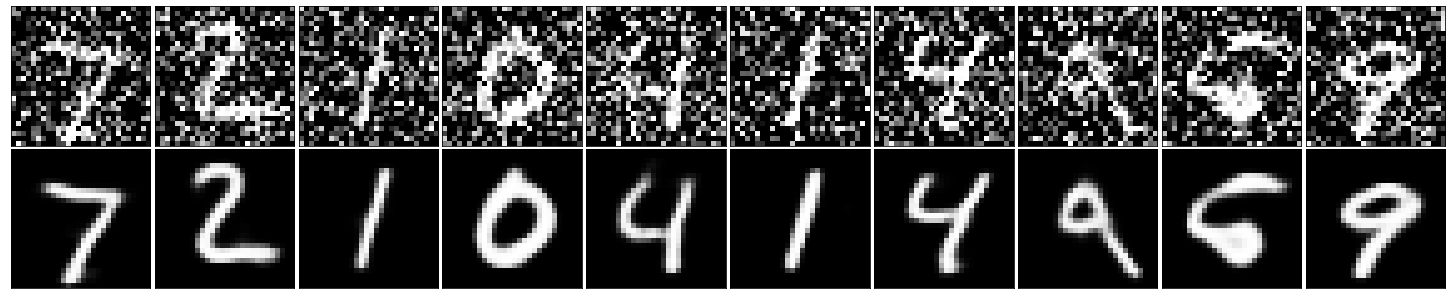

In [45]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

In [46]:
sess.close()